In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from sklearn import metrics, calibration

import pickle
import matplotlib.pyplot as plt

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

2023-04-18 15:55:10.525706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:55:12.763419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [4]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  8100
Total patient_id in calibration set:  1430
Total image_id in training set:  37219
Total image_id in calibration set:  6548


In [5]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6480
----Total image_id in training set:  29718
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7501
--Fold:  1
----Total patient_id in training set:  6480
----Total image_id in training set:  29758
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7461
--Fold:  2
----Total patient_id in training set:  6480
----Total image_id in training set:  29670
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7549
--Fold:  3
----Total patient_id in training set:  6480
----Total image_id in training set:  29887
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7332
--Fold:  4
----Total patient_id in training set:  6480
----Total image_id in training set:  29843
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7376


In [6]:
metadata = pd.read_csv('train.csv')

# Calibration set

In [7]:
print('Total patient_id in calibration set: ', len(splitter.calibset.keys()))
calib_img_ids = [img_id for k,v in splitter.calibset.items() for img_id in v]
print('Total image_id in calibration set: ', len(calib_img_ids))

Total patient_id in calibration set:  1430
Total image_id in calibration set:  6548


# PCA + Logistic Regression

## Image resolution 256 x 256

In [69]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 8764
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate'

pca_0 = pickle.load(open('models/PCA_50_42_256_0.pkl', 'rb'))

calib_gen = dl.DataGenerator(
    list_IDs = calib_img_ids,
    labels = splitter.labels,
    patient_img_dict = splitter.calibset,
    from_numpy=True,
    basepath=BASEPATH,
    
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE, 
    
    shuffle=True,
    normalize=(-1, 1),
    
    feature_extractor=pca_0,
    CNN_preprocess=None,
    return_id=False,
    verbose=True
)

X_calib, y_calib = calib_gen[0]

print(X_calib.shape, y_calib.shape)

with open('X_calib_PCA_256_0.npy','wb') as f:
     np.save(f, X_calib)
    
with open('y_calib_PCA_256_0.npy','wb') as f:
     np.save(f, y_calib)

(8764, 50) (8764,)


In [10]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = ''  # directory that preprocessed calibration set is stored
EXTRACTOR_PATH = '../feature_extractors' # directory that the trained feature extractors are kept
MODEL_PATH = '../predicitve_models' # directory that the predictive models are kept
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [13]:
pca_logit_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_logit_256.csv


In [19]:
pca_logit_256.head()

image_id  cancer  PCA_logit_256_0  PCA_logit_256_1  PCA_logit_256_2  \
0   111020467       0         0.224408         0.141438         0.332729   
1  1360770089       0         0.365185         0.376348         0.325499   
2    21872985       0         0.457760         0.122429         0.129010   
3  1924268326       0         0.312266         0.157474         0.261500   
4  1332075298       0         0.302204         0.225109         0.202447   

   PCA_logit_256_3  PCA_logit_256_4  
0         0.316287         0.325503  
1         0.145033         0.161009  
2         0.167977         0.248355  
3         0.171560         0.235179  
4         0.119682         0.141996

In [49]:
pca_logit_256[pca_logit_256.cancer==1].sample(5)

image_id  cancer  PCA_logit_256_0  PCA_logit_256_1  PCA_logit_256_2  \
7608  1764642297       1         0.203951         0.183314         0.225061   
1047   900604810       1         0.141436         0.387301         0.205560   
338   1570213179       1         0.255115         0.428794         0.310002   
4868   265835116       1         0.207038         0.210223         0.155166   
7251   103461181       1         0.144957         0.146413         0.239646   

      PCA_logit_256_3  PCA_logit_256_4  
7608         0.266825         0.537137  
1047         0.179805         0.134468  
338          0.262926         0.218019  
4868         0.240418         0.150642  
7251         0.506512         0.324653

###  Best threshold and scores

In [125]:
pca_logit_256 = pd.read_csv('PCA_logit_256.csv')
pca_logit_256_scores = ev.make_score_df(pca_logit_256, col_name='PCA_logit_256', fold_range=range(5))
pca_logit_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_logit_256_0   0.067657        0.398021  0.021923  0.476513  0.042322   
0  PCA_logit_256_1   0.402028        0.394336  0.022333  0.505899  0.047404   
0  PCA_logit_256_2   0.320474        0.398481  0.023430  0.501923  0.045748   
0  PCA_logit_256_3   0.292101        0.404403  0.022218  0.520784  0.047390   
0  PCA_logit_256_4   0.156768        0.414025  0.022776  0.507382  0.045179   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.989189   0.021624    [[120, 8280], [2, 183]]   120  8280    2  183   
0  0.113514   0.029957   [[7720, 680], [164, 21]]  7720   680  164   21   
0  0.210811   0.025658  [[6919, 1481], [146, 39]]  6919  1481  146   39   
0  0.318919   0.025597  [[6154, 2246], [126, 59]]  6154  2246  126   59   
0  0.886486   0.023180  [[1489, 6911], [21, 164]]  1489  6911   21  164   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.035294        0.576353        0.076867  
0  0.901689        0.579090        0.072756  
0  0.810483        0.572618        0.069661  
0  0.723704        0.564407        0.075131  
0  0.192545        0.557923        0.080383

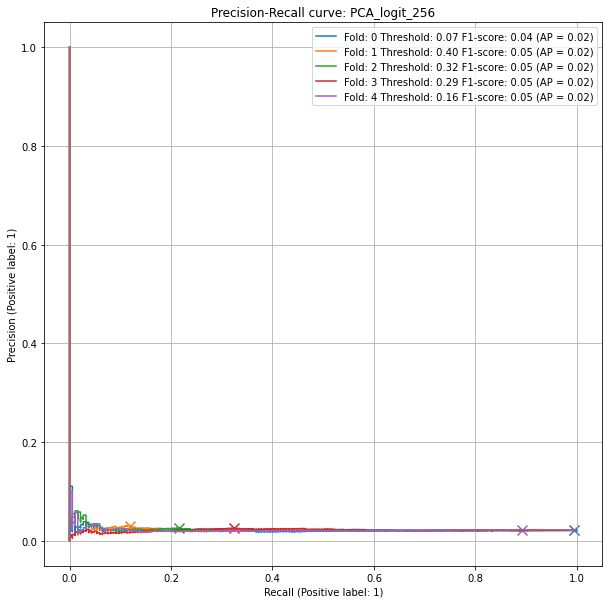

In [126]:
ev.vis_pr_curve(pca_logit_256, col_name='PCA_logit_256', fold_range=range(5))

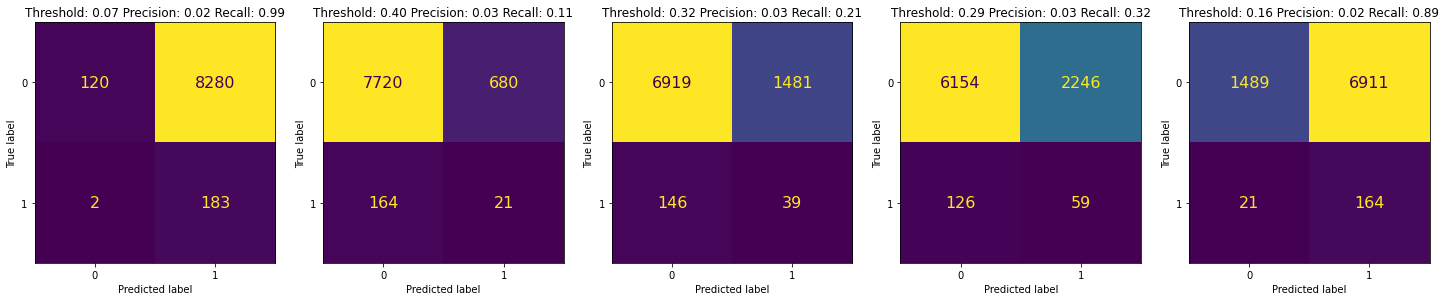

In [127]:
ev.vis_confusion_matrix(pca_logit_256, col_name='PCA_logit_256', fold_range=range(5))

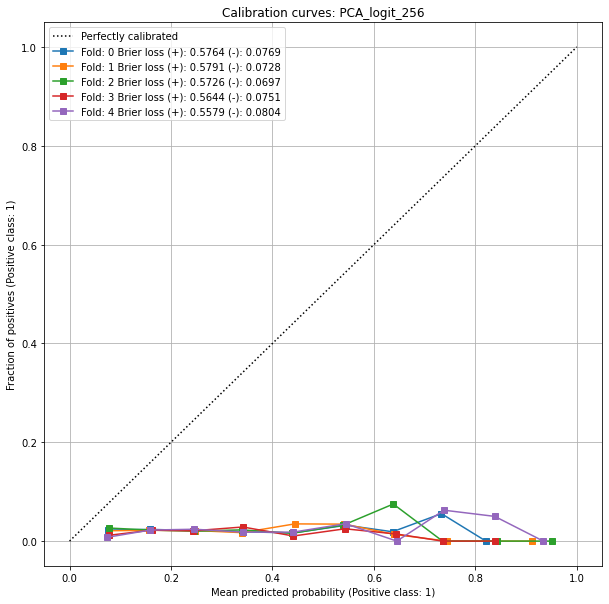

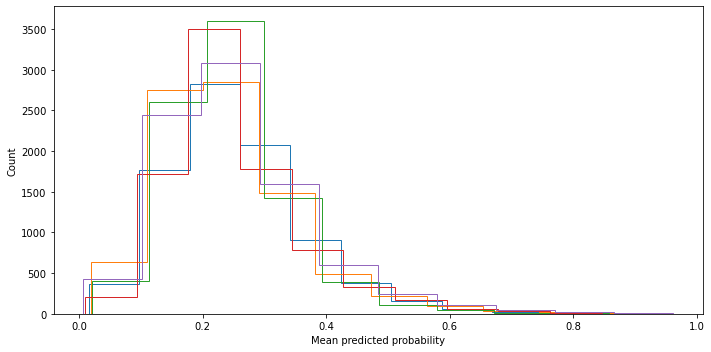

In [129]:
ev.vis_calibration_curve(pca_logit_256, col_name='PCA_logit_256', fold_range=range(5), n_bins=10, histogram=True)

### Use class weights

In [9]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '' 
EXTRACTOR_PATH = '../feature_extractors' # directory that the trained feature extractors are kept
MODEL_PATH = '../predicitve_models/use_class_weight' # directory that the predictive models are kept

N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [10]:
pca_logit_weighted_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='logit_weighted',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_logit_weighted_256.csv


In [11]:
pca_logit_weighted_256.head()

image_id  cancer  PCA_logit_weighted_256_0  PCA_logit_weighted_256_1  \
0   111020467       0                  0.017209                  0.440807   
1  1360770089       0                  0.346017                  0.283752   
2    21872985       0                  0.123253                  0.207689   
3  1924268326       0                  0.629382                  0.135093   
4  1332075298       0                  0.363074                  0.407289   

   PCA_logit_weighted_256_2  PCA_logit_weighted_256_3  \
0                  0.185892                  0.433192   
1                  0.061522                  0.063669   
2                  0.083531                  0.522848   
3                  0.160892                  0.099267   
4                  0.232714                  0.634052   

   PCA_logit_weighted_256_4  
0                  0.573468  
1                  0.728693  
2                  0.122257  
3                  0.093869  
4                  0.979159

In [12]:
pca_logit_weighted_256[pca_logit_weighted_256.cancer==1].sample(5)

image_id  cancer  PCA_logit_weighted_256_0  PCA_logit_weighted_256_1  \
130    809904326       1                  0.248663                  0.537721   
7252  1280544598       1                  0.180939                  0.108948   
5139  1446339465       1                  0.877363                  0.595577   
5460  1464760605       1                  0.484470                  0.855530   
4160  1063196710       1                  0.023649                  0.243943   

      PCA_logit_weighted_256_2  PCA_logit_weighted_256_3  \
130                   0.603141                  0.819299   
7252                  0.097792                  0.306102   
5139                  0.098333                  0.066834   
5460                  0.058952                  0.487374   
4160                  0.019391                  0.691671   

      PCA_logit_weighted_256_4  
130                   0.138832  
7252                  0.033023  
5139                  0.173903  
5460                  0.675332  
4160                  0.069002

### Best thresholds and scores

In [121]:
pca_logit_weighted_256 = pd.read_csv('PCA_logit_weighted_256.csv')
pca_logit_weighted_256_scores = ev.make_score_df(pca_logit_weighted_256, col_name='PCA_logit_weighted_256', fold_range=range(5))
pca_logit_weighted_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  PCA_logit_weighted_256_0   0.828672        0.555508  0.026322  0.542292   
0  PCA_logit_weighted_256_1   0.525645        0.503491  0.023147  0.510684   
0  PCA_logit_weighted_256_2   0.009719        0.440593  0.019487  0.469911   
0  PCA_logit_weighted_256_3   0.039209        0.490417  0.021093  0.490013   
0  PCA_logit_weighted_256_4   0.656280        0.487007  0.022774  0.516268   

   f1-score    recall  precision           confusion_matrix    tn    fp   fn  \
0  0.051765  0.118919   0.033083   [[7757, 643], [163, 22]]  7757   643  163   
0  0.045565  0.254054   0.025027  [[6569, 1831], [138, 47]]  6569  1831  138   
0  0.042461  0.956757   0.021712    [[425, 7975], [8, 177]]   425  7975    8   
0  0.043805  0.945946   0.022422   [[770, 7630], [10, 175]]   770  7630   10   
0  0.045343  0.200000   0.025570  [[6990, 1410], [148, 37]]  6990  1410  148   

    tp  accuracy  pos_brier_loss  neg_brier_loss  
0   22  0.906115        0.462934        0.195089  
0   47  0.770646        0.499232        0.166292  
0  177  0.070122        0.583138        0.182010  
0  175  0.110076        0.516347        0.188878  
0   37  0.818521        0.545923        0.179927

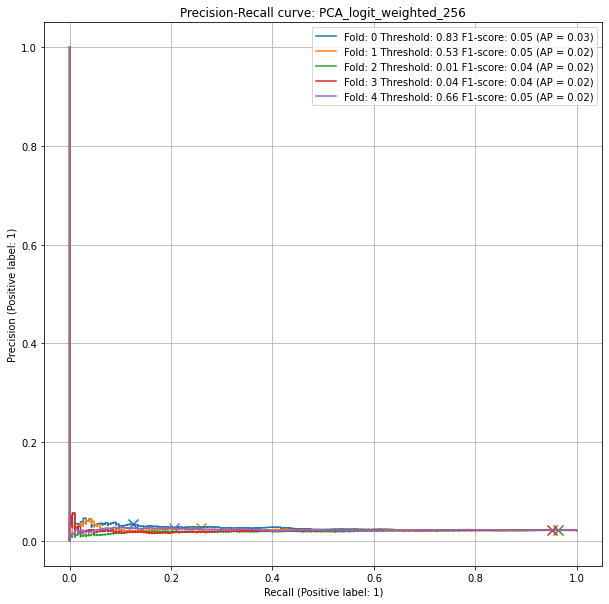

In [122]:
ev.vis_pr_curve(pca_logit_weighted_256, col_name='PCA_logit_weighted_256', fold_range=range(5))

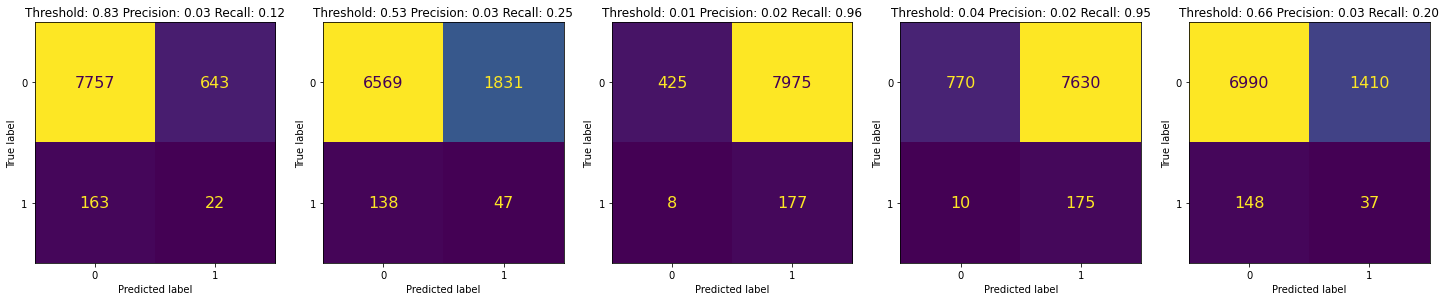

In [123]:
ev.vis_confusion_matrix(pca_logit_weighted_256, col_name='PCA_logit_weighted_256', fold_range=range(5))

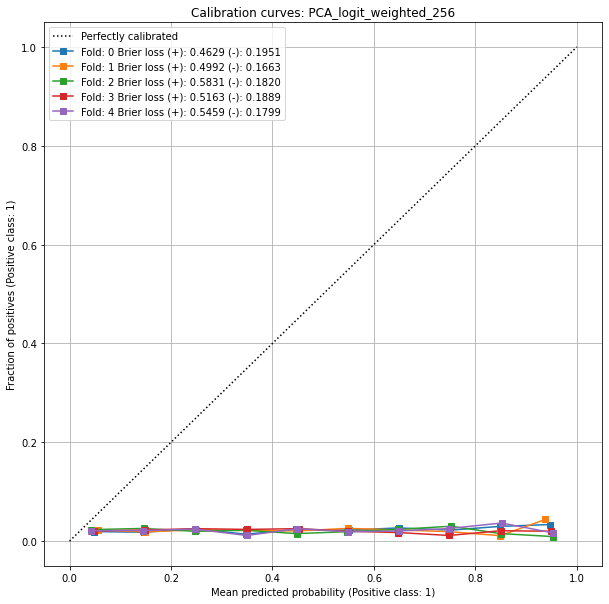

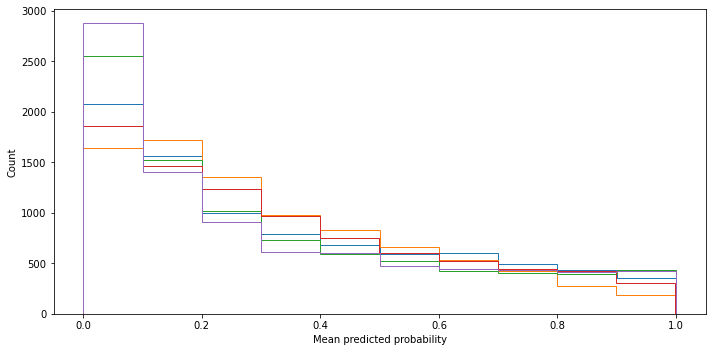

In [130]:
ev.vis_calibration_curve(pca_logit_weighted_256, col_name='PCA_logit_weighted_256', fold_range=range(5), n_bins=10, histogram=True)

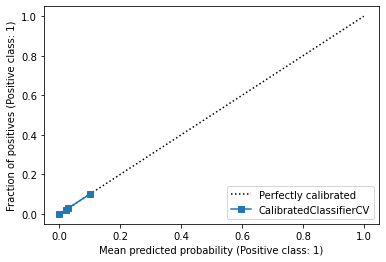

In [83]:
pca_logit_0 = pickle.load(open('models/PCA_50_logit_42_256_0.pkl', 'rb'))
pca_logit_0_calib = calibration.CalibratedClassifierCV(pca_logit_0, cv='prefit', method="isotonic")

pca_logit_0_calib.fit(X_calib, y_calib)
calibration.CalibrationDisplay.from_estimator(
    pca_logit_0_calib,
    X_calib,
    y_calib,
    n_bins=1000,
    strategy='quantile'
)

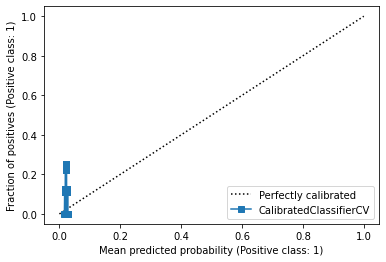

In [82]:
pca_logit_0_calib = calibration.CalibratedClassifierCV(pca_logit_0, cv='prefit', method="sigmoid")

pca_logit_0_calib.fit(X_calib, y_calib)
fig, ax = plt.subplots(figsize=(8, 8))
alibration.CalibrationDisplay.from_estimator(
    pca_logit_0_calib,
    X_calib,
    y_calib,
    n_bins=1000,
    strategy='quantile'
)

## Image resolution 512 x 512

In [14]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [16]:
pca_logit_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_logit_512.csv


In [20]:
pca_logit_512.head()

image_id  cancer  PCA_logit_512_0  PCA_logit_512_1  PCA_logit_512_2  \
0   111020467       0         0.396167         0.348775         0.382553   
1  1360770089       0         0.265301         0.506755         0.272261   
2    21872985       0         0.420139         0.330694         0.265494   
3  1924268326       0         0.374307         0.436727         0.278827   
4  1332075298       0         0.583084         0.415622         0.510425   

   PCA_logit_512_3  PCA_logit_512_4  
0         0.367532         0.541210  
1         0.514966         0.488033  
2         0.215415         0.334181  
3         0.328101         0.486500  
4         0.684831         0.489370

In [48]:
pca_logit_512[pca_logit_512.cancer==1].sample(5)

image_id  cancer  PCA_logit_512_0  PCA_logit_512_1  PCA_logit_512_2  \
7574  2000437485       1         0.383754         0.438233         0.529124   
1306   185869010       1         0.396758         0.640564         0.510142   
605    104113094       1         0.388957         0.273269         0.700109   
8558  1878879697       1         0.665076         0.406208         0.494034   
5675  1632383378       1         0.349581         0.374009         0.414958   

      PCA_logit_512_3  PCA_logit_512_4  
7574         0.351059         0.452977  
1306         0.146382         0.630120  
605          0.200001         0.304213  
8558         0.397535         0.369778  
5675         0.487584         0.260633

### Best threshold and scores

In [117]:
pca_logit_512 = pd.read_csv('PCA_logit_512.csv')
pca_logit_512_scores = ev.make_score_df(pca_logit_512, col_name='PCA_logit_512', fold_range=range(5))
pca_logit_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_logit_512_0   0.631008        0.601618  0.024226  0.537041  0.048832   
0  PCA_logit_512_1   0.490049        0.580577  0.021868  0.505303  0.045455   
0  PCA_logit_512_2   0.664873        0.592514  0.022892  0.508784  0.046893   
0  PCA_logit_512_3   0.605556        0.591326  0.022293  0.500647  0.044676   
0  PCA_logit_512_4   0.554079        0.593296  0.024274  0.515737  0.049599   

     recall  precision           confusion_matrix    tn    fp   fn  tp  \
0  0.124324   0.030383   [[7666, 734], [162, 23]]  7666   734  162  23   
0  0.302703   0.024572  [[6177, 2223], [129, 56]]  6177  2223  129  56   
0  0.108108   0.029940   [[7752, 648], [165, 20]]  7752   648  165  20   
0  0.162162   0.025907  [[7272, 1128], [155, 30]]  7272  1128  155  30   
0  0.183784   0.028668  [[7248, 1152], [151, 34]]  7248  1152  151  34   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.895632        0.341295        0.195385  
0  0.726034        0.363252        0.190819  
0  0.905300        0.357186        0.200857  
0  0.850553        0.359359        0.203949  
0  0.848224        0.347027        0.189193

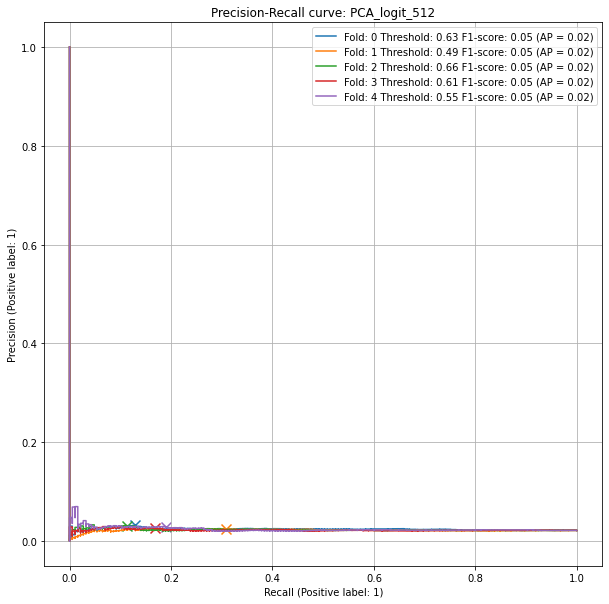

In [118]:
ev.vis_pr_curve(pca_logit_512, col_name='PCA_logit_512', fold_range=range(5))

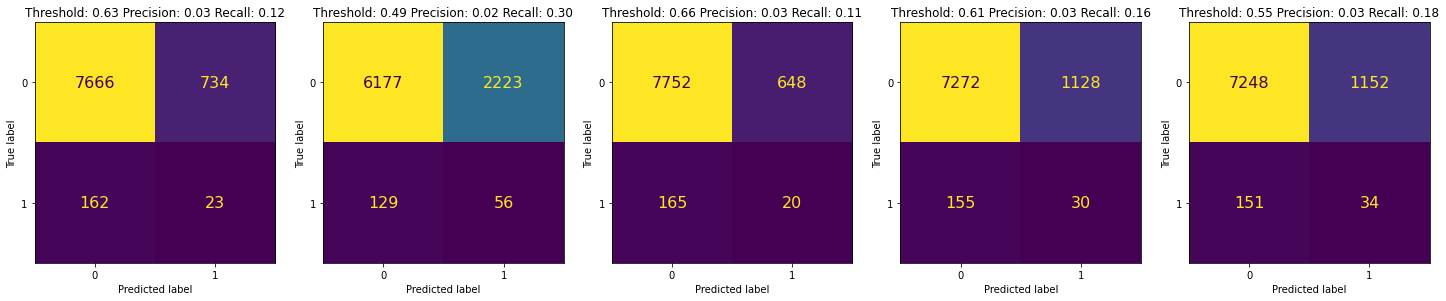

In [119]:
ev.vis_confusion_matrix(pca_logit_512, col_name='PCA_logit_512', fold_range=range(5))

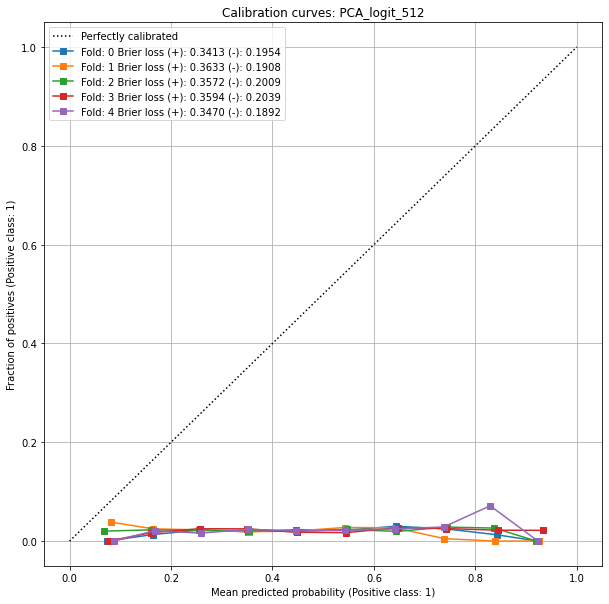

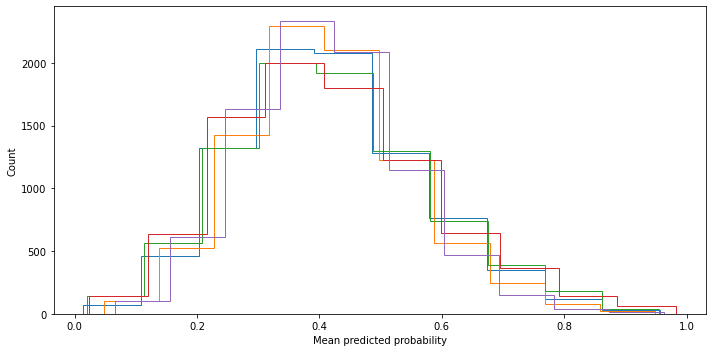

In [131]:
ev.vis_calibration_curve(pca_logit_512, col_name='PCA_logit_512', fold_range=range(5), n_bins=10, histogram=True)

### Use class weights

In [15]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models/use_class_weight'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [16]:
pca_logit_weighted_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='logit_weighted',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_logit_weighted_512.csv


In [17]:
pca_logit_weighted_512.head()

image_id  cancer  PCA_logit_weighted_512_0  PCA_logit_weighted_512_1  \
0   111020467       0                  0.168394                  0.772208   
1  1360770089       0                  0.267378                  0.141677   
2    21872985       0                  0.440746                  0.196506   
3  1924268326       0                  0.625568                  0.388615   
4  1332075298       0                  0.219527                  0.528406   

   PCA_logit_weighted_512_2  PCA_logit_weighted_512_3  \
0                  0.814012                  0.360219   
1                  0.121455                  0.217357   
2                  0.492755                  0.691572   
3                  0.311157                  0.394549   
4                  0.344086                  0.731081   

   PCA_logit_weighted_512_4  
0                  0.260068  
1                  0.200714  
2                  0.595309  
3                  0.676057  
4                  0.417770

In [18]:
pca_logit_weighted_512[pca_logit_weighted_512.cancer==1].sample(5)

image_id  cancer  PCA_logit_weighted_512_0  PCA_logit_weighted_512_1  \
2506  1858716768       1                  0.672750                  0.118791   
1501  1609200371       1                  0.897655                  0.214176   
579    972684809       1                  0.149618                  0.884233   
831    143752167       1                  0.480840                  0.191516   
2552  1059866275       1                  0.287320                  0.532177   

      PCA_logit_weighted_512_2  PCA_logit_weighted_512_3  \
2506                  0.389149                  0.336335   
1501                  0.308575                  0.433160   
579                   0.114472                  0.350973   
831                   0.253214                  0.010248   
2552                  0.325021                  0.924949   

      PCA_logit_weighted_512_4  
2506                  0.255432  
1501                  0.346745  
579                   0.240376  
831                   0.874649  
2552                  0.119877

### Best thresholds and scores

In [113]:
pca_logit_weighted_512 = pd.read_csv('PCA_logit_weighted_512.csv')
pca_logit_weighted_512_scores = ev.make_score_df(pca_logit_weighted_512, col_name='PCA_logit_weighted_512', fold_range=range(5))
pca_logit_weighted_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  PCA_logit_weighted_512_0   0.134989        0.615774  0.020948  0.486625   
0  PCA_logit_weighted_512_1   0.523481        0.635710  0.023572  0.521982   
0  PCA_logit_weighted_512_2   0.174712        0.612029  0.021110  0.496447   
0  PCA_logit_weighted_512_3   0.005313        0.576104  0.018716  0.449551   
0  PCA_logit_weighted_512_4   0.228100        0.619350  0.020813  0.499239   

   f1-score    recall  precision           confusion_matrix    tn    fp   fn  \
0  0.043950  0.886486   0.022534  [[1286, 7114], [21, 164]]  1286  7114   21   
0  0.047730  0.443243   0.025223  [[5231, 3169], [103, 82]]  5231  3169  103   
0  0.043422  0.816216   0.022304  [[1781, 6619], [34, 151]]  1781  6619   34   
0  0.042067  0.994595   0.021488     [[21, 8379], [1, 184]]    21  8379    1   
0  0.044905  0.843243   0.023067  [[1793, 6607], [29, 156]]  1793  6607   29   

    tp  accuracy  pos_brier_loss  neg_brier_loss  
0  164  0.168899        0.373205        0.292675  
0   82  0.618870        0.348657        0.271896  
0  151  0.225044        0.383323        0.283858  
0  184  0.023879        0.415579        0.277512  
0  156  0.227024        0.348606        0.265097

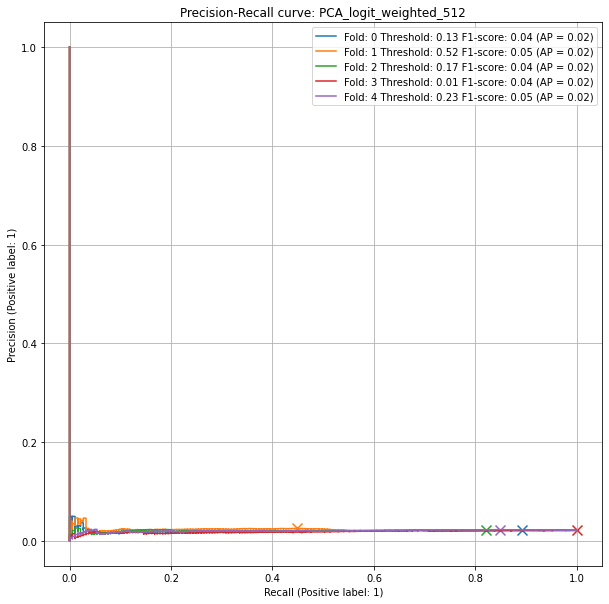

In [114]:
ev.vis_pr_curve(pca_logit_weighted_512, col_name='PCA_logit_weighted_512', fold_range=range(5))

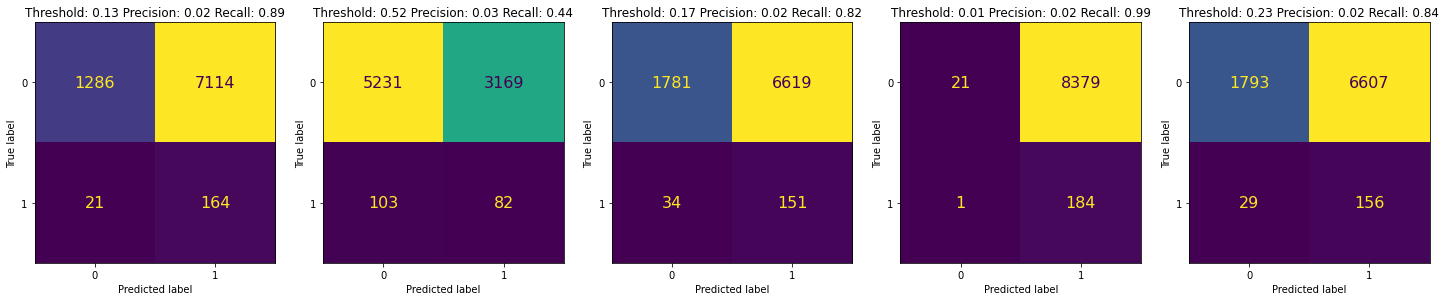

In [115]:
ev.vis_confusion_matrix(pca_logit_weighted_512, col_name='PCA_logit_weighted_512', fold_range=range(5))

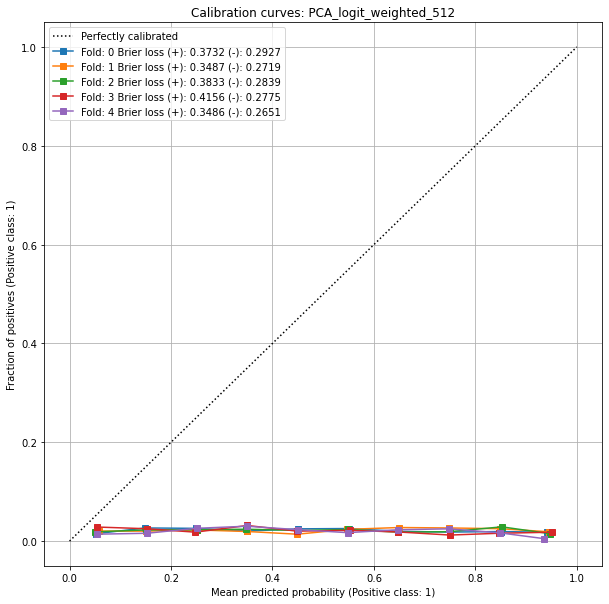

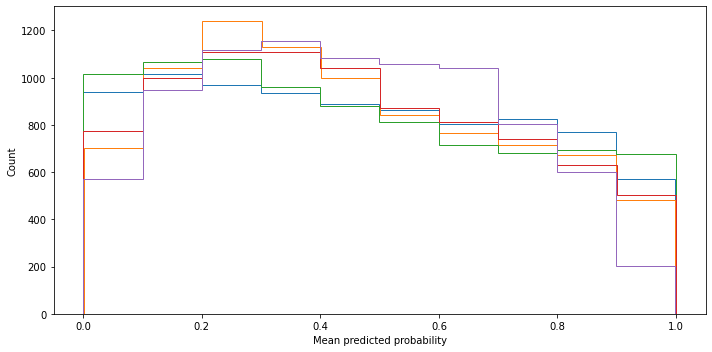

In [132]:
ev.vis_calibration_curve(pca_logit_weighted_512, col_name='PCA_logit_weighted_512', fold_range=range(5))

### Image resolution 1024 x 1024

In [17]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [18]:
pca_logit_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_logit_1024.csv


In [45]:
pca_logit_1024.head()

image_id  cancer  PCA_logit_1024_0  PCA_logit_1024_1  PCA_logit_1024_2  \
0   111020467       0          0.285386          0.626450          0.200119   
1  1360770089       0          0.415030          0.479158          0.595492   
2    21872985       0          0.528512          0.705343          0.576429   
3  1924268326       0          0.553441          0.488833          0.518552   
4  1332075298       0          0.398760          0.644286          0.346113   

   PCA_logit_1024_3  PCA_logit_1024_4  
0          0.456417          0.295022  
1          0.690355          0.457898  
2          0.522617          0.320196  
3          0.348370          0.413032  
4          0.410736          0.324415

In [47]:
pca_logit_1024[pca_logit_1024.cancer==1].sample(5)

image_id  cancer  PCA_logit_1024_0  PCA_logit_1024_1  \
8136  1811195939       1          0.455821          0.694060   
7574  2000437485       1          0.471339          0.496133   
6022  1410656943       1          0.477600          0.230587   
3769   669303826       1          0.337407          0.621994   
2494  1812305728       1          0.425276          0.487271   

      PCA_logit_1024_2  PCA_logit_1024_3  PCA_logit_1024_4  
8136          0.404434          0.440472          0.208302  
7574          0.465651          0.531125          0.423115  
6022          0.703756          0.568965          0.729012  
3769          0.522084          0.660751          0.782363  
2494          0.785239          0.662845          0.337525

In [109]:
pca_logit_1024 = pd.read_csv('PCA_logit_1024.csv')
pca_logit_1024_scores = ev.make_score_df(pca_logit_1024, col_name='PCA_logit_1024', fold_range=range(5))
pca_logit_1024_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_logit_1024_0   0.442809        0.658637  0.023754  0.540976  0.048410   
0  PCA_logit_1024_1   0.485652        0.626969  0.019987  0.474254  0.042170   
0  PCA_logit_1024_2   0.642798        0.647079  0.022215  0.504909  0.045260   
0  PCA_logit_1024_3   0.533514        0.648750  0.023125  0.529990  0.050374   
0  PCA_logit_1024_4   0.614799        0.649495  0.022089  0.506929  0.045313   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.654054   0.025135  [[3707, 4693], [64, 121]]  3707  4693   64  121   
0  0.481081   0.022052   [[4453, 3947], [96, 89]]  4453  3947   96   89   
0  0.200000   0.025517  [[6987, 1413], [148, 37]]  6987  1413  148   37   
0  0.400000   0.026880  [[5721, 2679], [111, 74]]  5721  2679  111   74   
0  0.275676   0.024685  [[6385, 2015], [134, 51]]  6385  2015  134   51   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.445894        0.276490        0.252475  
0  0.529062        0.315166        0.253901  
0  0.818171        0.292951        0.256626  
0  0.675015        0.282021        0.244801  
0  0.749680        0.294243        0.263256

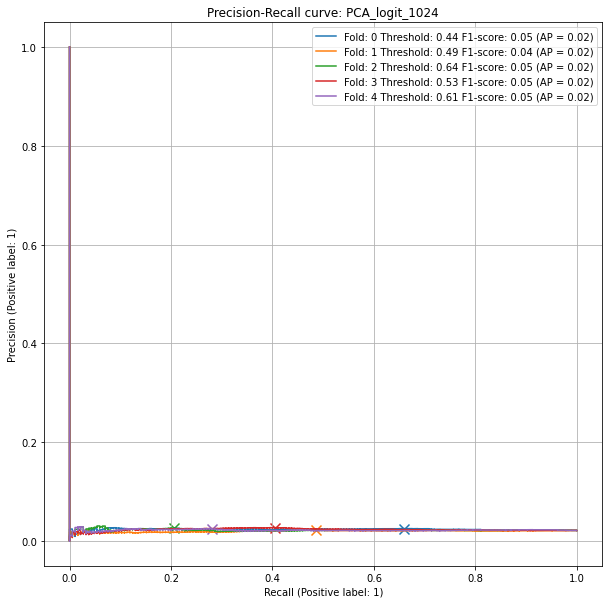

In [110]:
ev.vis_pr_curve(pca_logit_1024, col_name='PCA_logit_1024', fold_range=range(5))

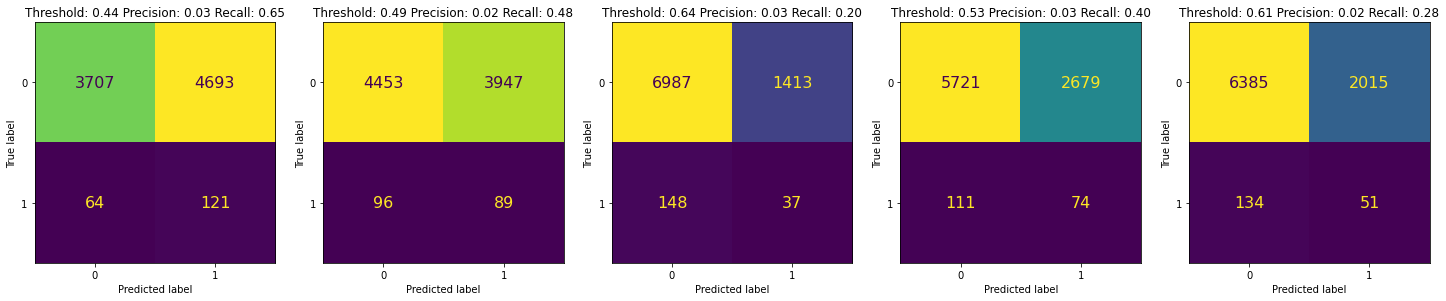

In [111]:
ev.vis_confusion_matrix(pca_logit_1024, col_name='PCA_logit_1024', fold_range=range(5))

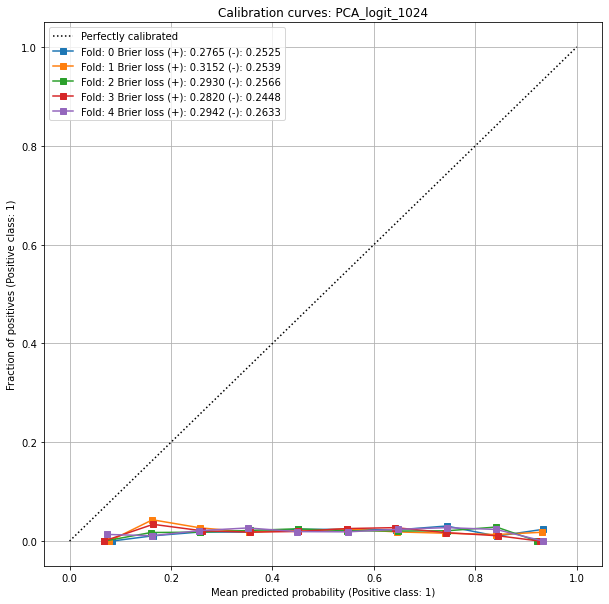

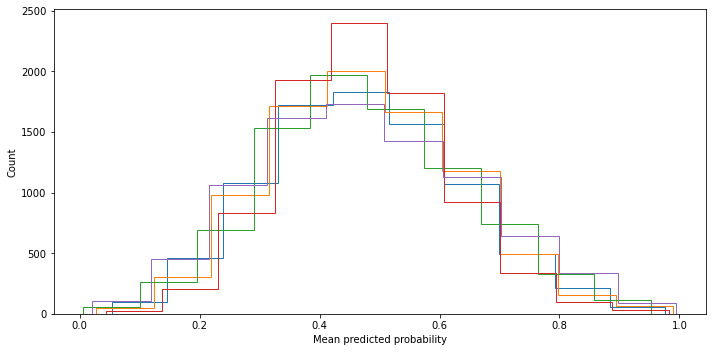

In [133]:
ev.vis_calibration_curve(pca_logit_1024, col_name='PCA_logit_1024', fold_range=range(5))

## PCA + Random Forest

### Image resolution 256 x 256

In [22]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  2
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  3
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  4
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


In [23]:
pca_rfc_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_rfc_256.csv


In [24]:
pca_rfc_256.head()

image_id  cancer  PCA_rfc_256_0  PCA_rfc_256_1  PCA_rfc_256_2  \
0   111020467       0       0.030357       0.000000       0.016561   
1  1360770089       0       0.005747       0.000000       0.029308   
2    21872985       0       0.005357       0.018382       0.028089   
3  1924268326       0       0.000000       0.006055       0.032086   
4  1332075298       0       0.006923       0.000000       0.031944   

   PCA_rfc_256_3  PCA_rfc_256_4  
0       0.014245       0.035952  
1       0.025000       0.000000  
2       0.012531       0.026667  
3       0.006477       0.010952  
4       0.001961       0.007143

In [50]:
pca_rfc_256[pca_rfc_256.cancer==1].sample(5)

image_id  cancer  PCA_rfc_256_0  PCA_rfc_256_1  PCA_rfc_256_2  \
6022  1410656943       1       0.028782       0.003340       0.058720   
8557   476723525       1       0.069048       0.050793       0.014135   
4363   259642159       1       0.002381       0.010185       0.002083   
5632   506550282       1       0.018920       0.006162       0.005355   
2747  1681368728       1       0.017788       0.017446       0.010000   

      PCA_rfc_256_3  PCA_rfc_256_4  
6022       0.031958       0.050000  
8557       0.022203       0.065000  
4363       0.018627       0.026888  
5632       0.052536       0.000000  
2747       0.002759       0.035952

In [105]:
pca_rfc_256 = pd.read_csv('PCA_rfc_256.csv')
pca_rfc_256_scores = ev.make_score_df(pca_rfc_256, col_name='PCA_rfc_256', fold_range=range(5))
pca_rfc_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_rfc_256_0   0.017357        0.045742  0.022307  0.499511  0.043570   
0  PCA_rfc_256_1   0.006484        0.041759  0.021428  0.513269  0.044890   
0  PCA_rfc_256_2   0.000000        0.042111  0.020753  0.467919  0.041327   
0  PCA_rfc_256_3   0.025000        0.038349  0.021924  0.494870  0.039454   
0  PCA_rfc_256_4   0.003125        0.034465  0.019262  0.471594  0.044154   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.502703   0.022772   [[4409, 3991], [92, 93]]  4409  3991   92   93   
0  0.605405   0.023309  [[3707, 4693], [73, 112]]  3707  4693   73  112   
0  0.891892   0.021154   [[765, 7635], [20, 165]]   765  7635   20  165   
0  0.281081   0.021216  [[6001, 2399], [133, 52]]  6001  2399  133   52   
0  0.729730   0.022766  [[2605, 5795], [50, 135]]  2605  5795   50  135   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.524403        0.954257        0.001058  
0  0.444846        0.958350        0.001228  
0  0.108328        0.957964        0.001067  
0  0.705067        0.961725        0.000881  
0  0.319161        0.965714        0.001236

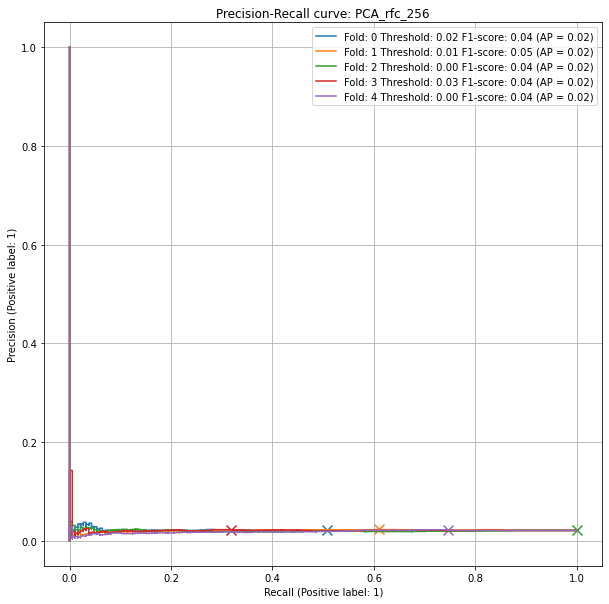

In [106]:
ev.vis_pr_curve(pca_rfc_256, col_name='PCA_rfc_256', fold_range=range(5))

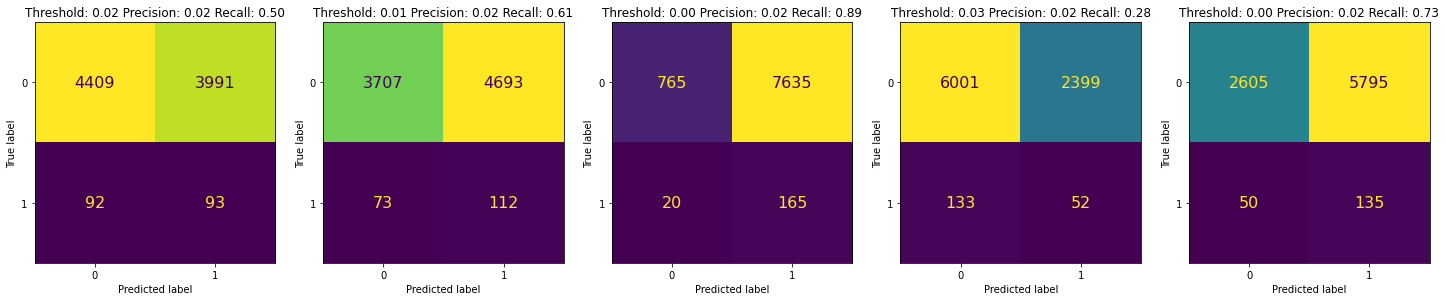

In [107]:
ev.vis_confusion_matrix(pca_rfc_256, col_name='PCA_rfc_256', fold_range=range(5))

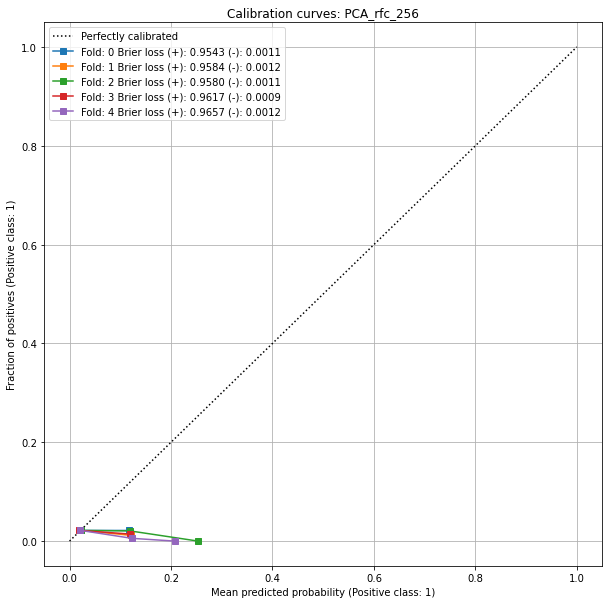

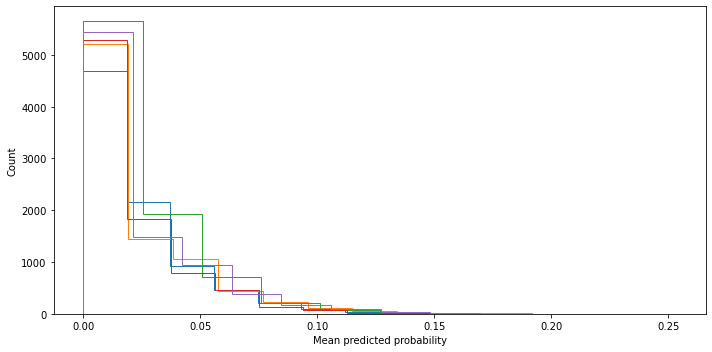

In [134]:
ev.vis_calibration_curve(pca_rfc_256, col_name='PCA_rfc_256', fold_range=range(5))

### Image resolution 512 x 512

In [25]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  2
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  3
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  4
---Loading PCA feature extractor...
---Loading rfc model...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


In [26]:
pca_rfc_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_rfc_512.csv


In [27]:
pca_rfc_512.head()

image_id  cancer  PCA_rfc_512_0  PCA_rfc_512_1  PCA_rfc_512_2  \
0   111020467       0       0.006264       0.069077       0.003333   
1  1360770089       0       0.000602       0.029791       0.016372   
2    21872985       0       0.030618       0.064218       0.020556   
3  1924268326       0       0.002649       0.026122       0.013485   
4  1332075298       0       0.103515       0.076605       0.021535   

   PCA_rfc_512_3  PCA_rfc_512_4  
0       0.000000       0.110714  
1       0.008031       0.001499  
2       0.001579       0.029005  
3       0.001579       0.002048  
4       0.001579       0.033922

In [51]:
pca_rfc_512[pca_rfc_512.cancer==1].sample(5)

image_id  cancer  PCA_rfc_512_0  PCA_rfc_512_1  PCA_rfc_512_2  \
7123   914306111       1       0.037318       0.011718       0.011688   
8556   400752214       1       0.072000       0.032243       0.003333   
7509  1511749844       1       0.022198       0.002778       0.017729   
4435   306442803       1       0.000000       0.181220       0.036669   
2937   424911657       1       0.012913       0.000000       0.011235   

      PCA_rfc_512_3  PCA_rfc_512_4  
7123       0.010425       0.000000  
8556       0.000000       0.023824  
7509       0.000000       0.007186  
4435       0.001579       0.090476  
2937       0.034912       0.007895

In [100]:
pca_rfc_512 = pd.read_csv('PCA_rfc_512.csv')
pca_rfc_512_scores = ev.make_score_df(pca_rfc_512, col_name='PCA_rfc_512', fold_range=range(5))
pca_rfc_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_rfc_512_0   0.003053        0.046982  0.021340  0.507156  0.044884   
0  PCA_rfc_512_1   0.026049        0.059202  0.023509  0.529816  0.047227   
0  PCA_rfc_512_2   0.000000        0.038349  0.020279  0.467558  0.041881   
0  PCA_rfc_512_3   0.034375        0.043685  0.021645  0.499565  0.045514   
0  PCA_rfc_512_4   0.000588        0.043557  0.019884  0.470956  0.041871   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.772973   0.023113  [[2356, 6044], [42, 143]]  2356  6044   42  143   
0  0.481081   0.024833   [[4905, 3495], [96, 89]]  4905  3495   96   89   
0  0.881081   0.021450   [[964, 7436], [22, 163]]   964  7436   22  163   
0  0.281081   0.024762  [[6352, 2048], [133, 52]]  6352  2048  133   52   
0  0.854054   0.021462  [[1196, 7204], [27, 158]]  1196  7204   27  158   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.291089        0.953167        0.001492  
0  0.581712        0.940700        0.001673  
0  0.131275        0.961819        0.001093  
0  0.745952        0.956391        0.001161  
0  0.157717        0.956725        0.001604

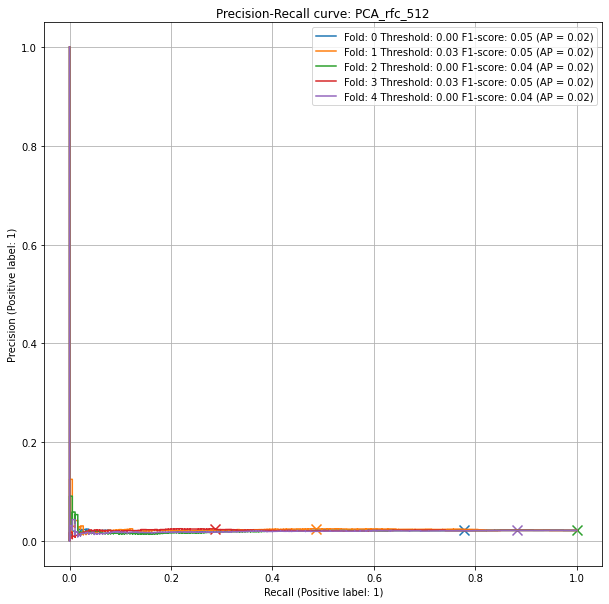

In [102]:
ev.vis_pr_curve(pca_rfc_512, col_name='PCA_rfc_512', fold_range=range(5))

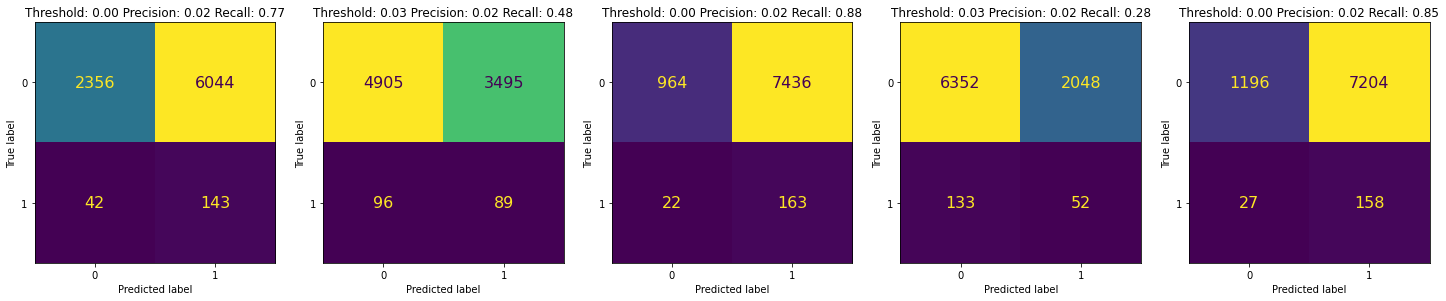

In [103]:
ev.vis_confusion_matrix(pca_rfc_512, col_name='PCA_rfc_512', fold_range=range(5))

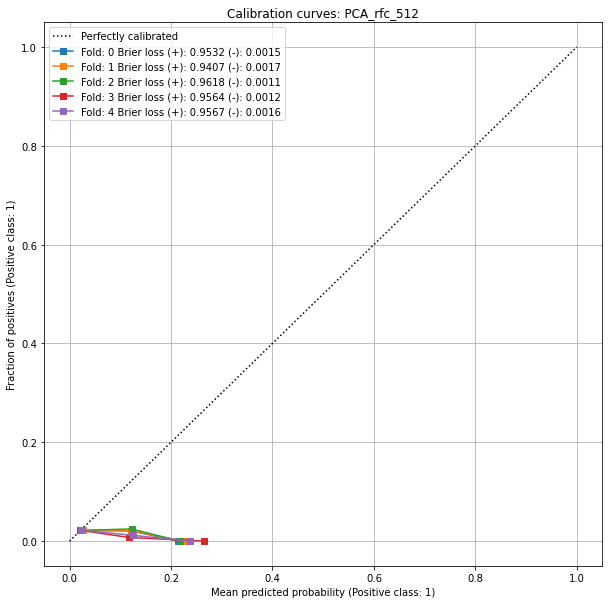

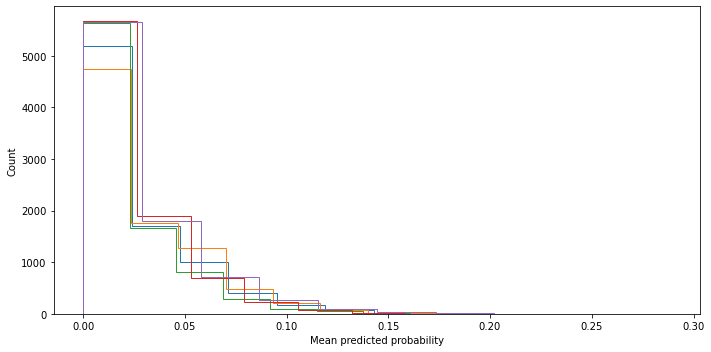

In [135]:
ev.vis_calibration_curve(pca_rfc_512, col_name='PCA_rfc_512', fold_range=range(5))

### Image resolution 1024 x 1024

In [28]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 50
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'PCA',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Loading PCA feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  2


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  4


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  10


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


In [29]:
pca_rfc_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='PCA', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  PCA_rfc_1024.csv


In [34]:
pca_rfc_1024.head()

image_id  cancer  PCA_rfc_1024_0  PCA_rfc_1024_1  PCA_rfc_1024_2  \
0   111020467       0        0.000000        0.002402        0.007812   
1  1360770089       0        0.016544        0.052500        0.008333   
2    21872985       0        0.041667        0.007914        0.017750   
3  1924268326       0        0.003448        0.009711        0.007895   
4  1332075298       0        0.021429        0.061377        0.000000   

   PCA_rfc_1024_3  PCA_rfc_1024_4  
0        0.022744        0.009406  
1        0.009255        0.002635  
2        0.000000        0.000000  
3        0.021571        0.006014  
4        0.030000        0.003378

In [52]:
pca_rfc_1024[pca_rfc_1024.cancer==1].sample(5)

image_id  cancer  PCA_rfc_1024_0  PCA_rfc_1024_1  PCA_rfc_1024_2  \
2339  1186509485       1        0.053808        0.000000        0.000000   
2506  1858716768       1        0.016667        0.002778        0.000000   
2340  1306638994       1        0.010011        0.000806        0.041040   
7640  2075900290       1        0.006226        0.010446        0.003540   
2505  1532464574       1        0.023333        0.039052        0.002381   

      PCA_rfc_1024_3  PCA_rfc_1024_4  
2339        0.001563        0.007740  
2506        0.000000        0.051786  
2340        0.059091        0.005968  
7640        0.001316        0.003659  
2505        0.030000        0.056667

In [97]:
pca_rfc_1024 = pd.read_csv('PCA_rfc_1024.csv')
pca_rfc_1024_scores = ev.make_score_df(pca_rfc_1024, col_name='PCA_rfc_1024', fold_range=range(5))
pca_rfc_1024_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  PCA_rfc_1024_0   0.000000        0.043274  0.020364  0.470783  0.039719   
0  PCA_rfc_1024_1   0.009711        0.044918  0.021701  0.505778  0.044132   
0  PCA_rfc_1024_2   0.003540        0.041852  0.022086  0.521098  0.045231   
0  PCA_rfc_1024_3   0.000000        0.033848  0.020360  0.446599  0.040093   
0  PCA_rfc_1024_4   0.038794        0.043651  0.024157  0.517576  0.046486   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.778378   0.020379  [[1478, 6922], [41, 144]]  1478  6922   41  144   
0  0.594595   0.022917  [[3710, 4690], [75, 110]]  3710  4690   75  110   
0  0.697297   0.023374  [[3010, 5390], [56, 129]]  3010  5390   56  129   
0  0.794595   0.020565  [[1399, 7001], [38, 147]]  1399  7001   38  147   
0  0.232432   0.025826  [[6778, 1622], [142, 43]]  6778  1622  142   43   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.188934        0.956904        0.001340  
0  0.444962        0.955202        0.001275  
0  0.365638        0.958288        0.001142  
0  0.180082        0.966462        0.001121  
0  0.794525        0.956599        0.001028

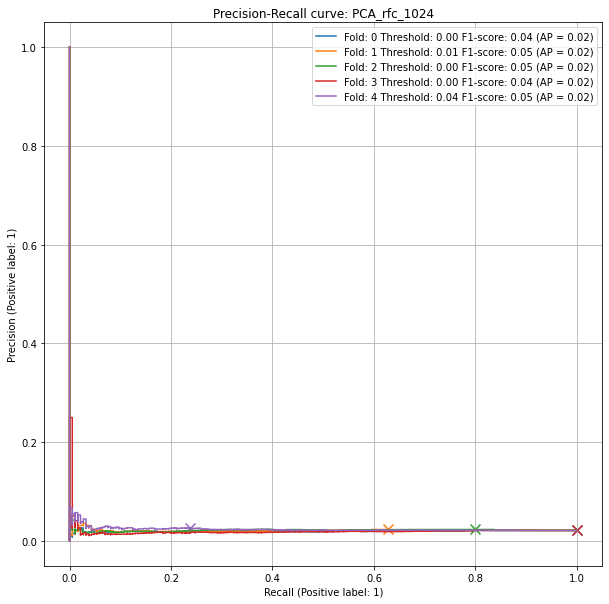

In [98]:
ev.vis_pr_curve(pca_rfc_1024, col_name='PCA_rfc_1024', fold_range=range(5))

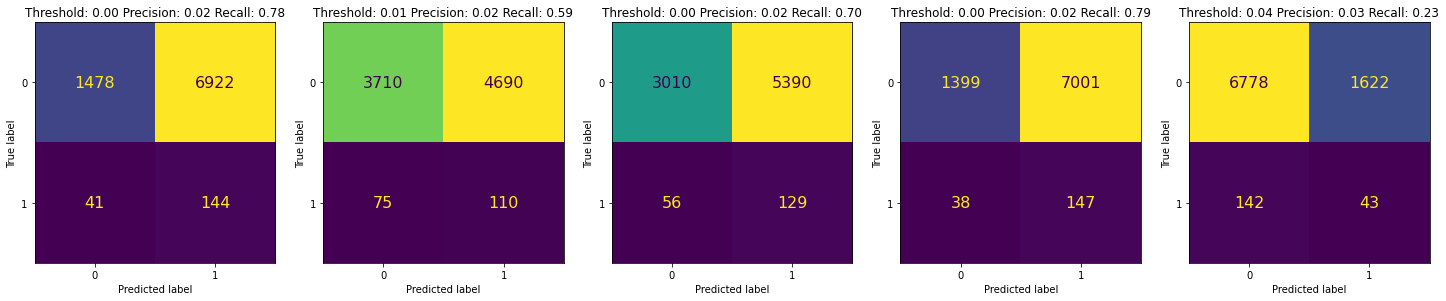

In [124]:
ev.vis_confusion_matrix(pca_rfc_1024, col_name='PCA_rfc_1024', fold_range=range(5))

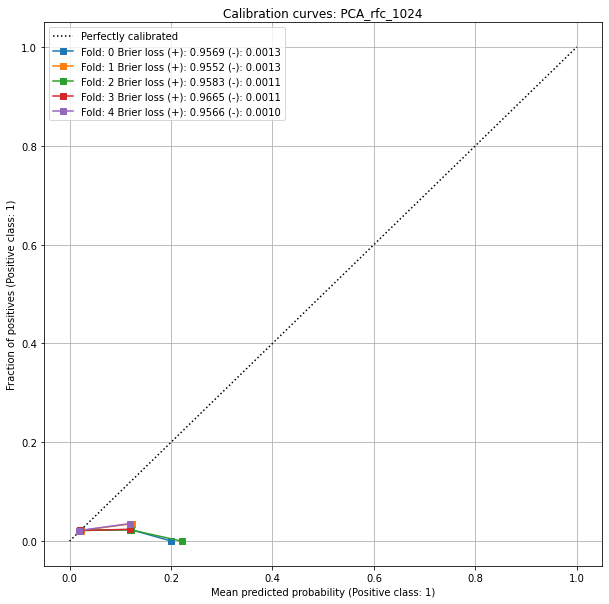

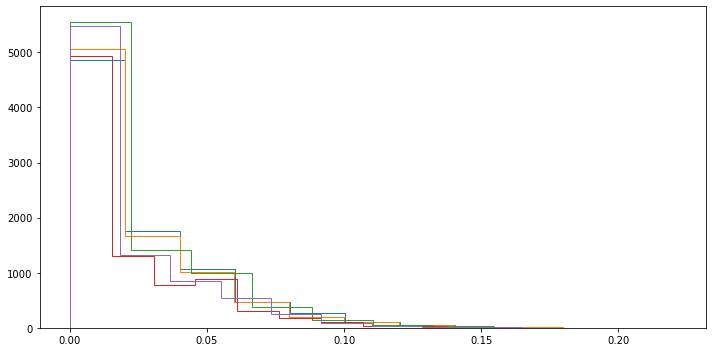

In [99]:
ev.vis_calibration_curve(pca_rfc_1024, col_name='PCA_rfc_1024', fold_range=range(5))

## NMF + Logistic Regression

### Image resolution 256 x 256

In [31]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading NMF feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading NMF feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---

In [32]:
nmf_logit_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  NMF_logit_256.csv


In [33]:
nmf_logit_256.head()

image_id  cancer  NMF_logit_256_0  NMF_logit_256_1  NMF_logit_256_2  \
0   111020467       0         0.016250         0.040185         0.021706   
1  1360770089       0         0.015201         0.037975         0.023163   
2    21872985       0         0.015296         0.040618         0.013375   
3  1924268326       0         0.014850         0.038532         0.015828   
4  1332075298       0         0.015607         0.038834         0.026346   

   NMF_logit_256_3  NMF_logit_256_4  
0         0.021355         0.013943  
1         0.023037         0.014921  
2         0.022982         0.013898  
3         0.024345         0.014765  
4         0.022355         0.014564

In [54]:
nmf_logit_256[nmf_logit_256.cancer==1].sample(5)

image_id  cancer  NMF_logit_256_0  NMF_logit_256_1  NMF_logit_256_2  \
100     32033063       1         0.016169         0.040016         0.020126   
4777  1312979917       1         0.014889         0.037313         0.022449   
4778  1663628589       1         0.015596         0.038811         0.022712   
6021  1082753612       1         0.014913         0.038522         0.015843   
2451  1360800566       1         0.015974         0.039606         0.021454   

      NMF_logit_256_3  NMF_logit_256_4  
100          0.021463         0.014009  
4777         0.023591         0.015248  
4778         0.022373         0.014539  
6021         0.024102         0.014769  
2451         0.021774         0.014186

In [92]:
nmf_logit_256 = pd.read_csv('NMF_logit_256.csv')
nmf_logit_256_scores = ev.make_score_df(nmf_logit_256, col_name='NMF_logit_256', fold_range=range(5))
nmf_logit_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_logit_256_0   0.014880        0.032006  0.029077  0.482362  0.044130   
0  NMF_logit_256_1   0.038770        0.078460  0.023147  0.470232  0.042800   
0  NMF_logit_256_2   0.022102        0.034324  0.024771  0.534582  0.053108   
0  NMF_logit_256_3   0.021774        0.042868  0.021258  0.515380  0.047490   
0  NMF_logit_256_4   0.014181        0.027490  0.022589  0.528477  0.049316   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.827027   0.022670  [[1804, 6596], [32, 153]]  1804  6596   32  153   
0  0.637838   0.022143  [[3189, 5211], [67, 118]]  3189  5211   67  118   
0  0.237838   0.029891  [[6972, 1428], [141, 44]]  6972  1428  141   44   
0  0.756757   0.024514  [[2829, 5571], [45, 140]]  2829  5571   45  140   
0  0.691892   0.025569  [[3522, 4878], [57, 128]]  3522  4878   57  128   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.227956        0.967732        0.000272  
0  0.385207        0.919958        0.001715  
0  0.817239        0.965397        0.000313  
0  0.345836        0.956661        0.000487  
0  0.425160        0.972316        0.000194

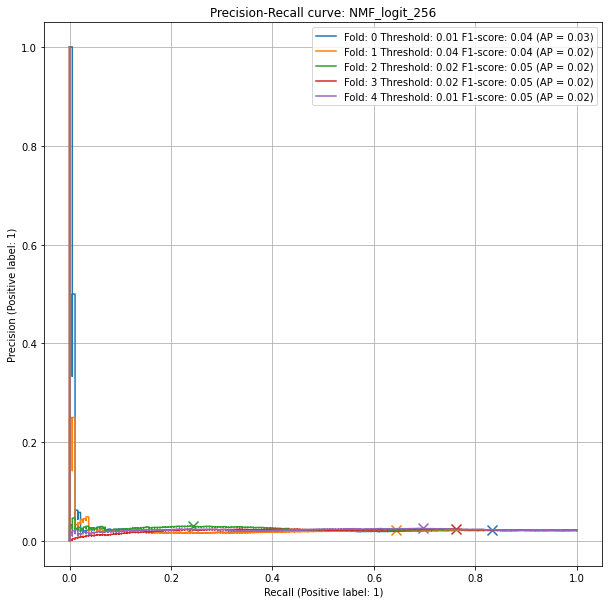

In [93]:
ev.vis_pr_curve(nmf_logit_256, col_name='NMF_logit_256', fold_range=range(5))

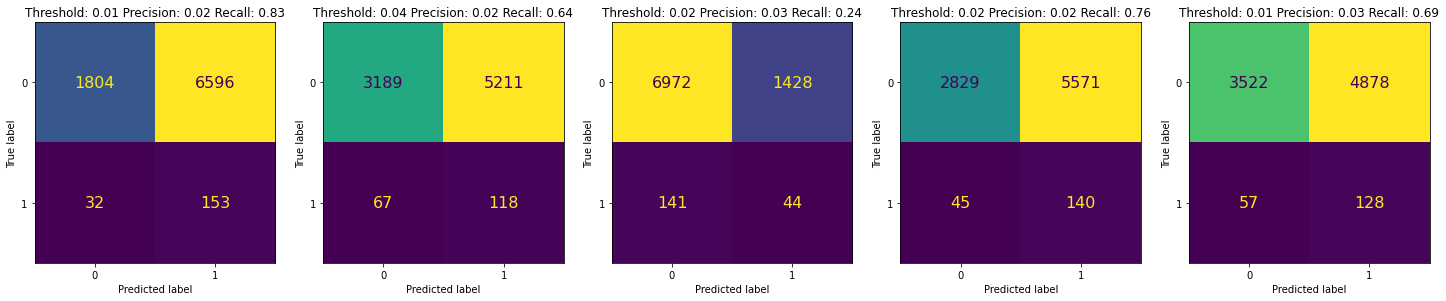

In [94]:
ev.vis_confusion_matrix(nmf_logit_256, col_name='NMF_logit_256', fold_range=range(5))

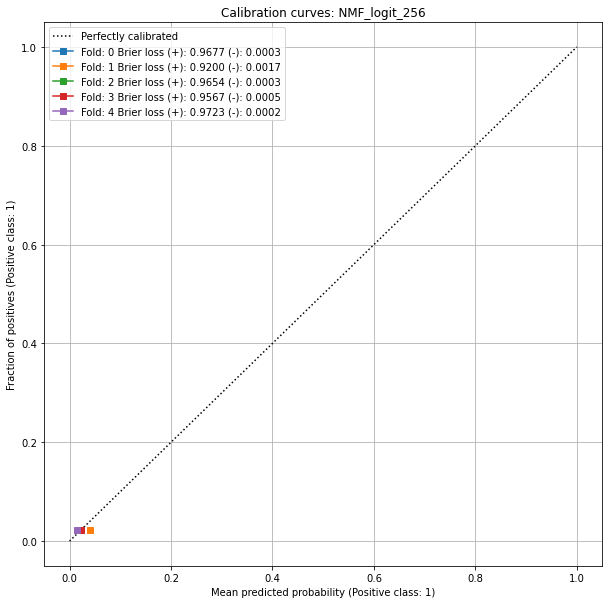

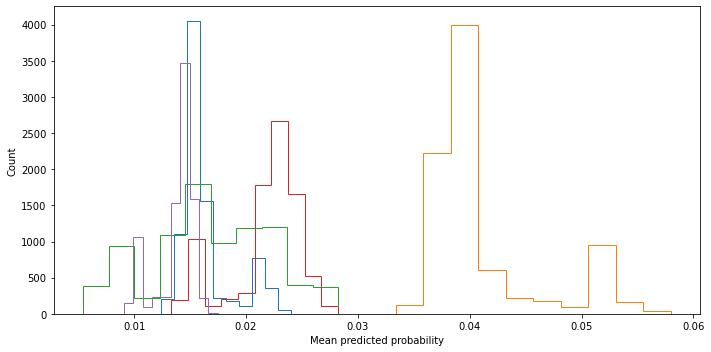

In [136]:
ev.vis_calibration_curve(nmf_logit_256, col_name='NMF_logit_256', fold_range=range(5))

### Image resolution 512 x 512

In [8]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading NMF feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
Finish all batches!
Fold:  1
---Loading NMF feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Gett

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1268678/2135621300.py", line 10, in <module>
    img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
  File "/home/irinb/eval_model.py", line 458, in get_prediction_from_pipeline
    img_id_fold, y_true_fold, y_pred_proba_fold = get_aggregated_predictions(
  File "/home/irinb/eval_model.py", line 286, in get_aggregated_predictions
    for i, data in enumerate(val_gen):
  File "/home/irinb/.local/lib/python3.9/site-packages/keras/utils/data_utils.py", line 566, in __iter__
    for item in (self[i] for i in range(len(self))):
  File "/home/irinb/.local/lib/python3.9/site-packages/keras/utils/data_utils.py", line 566, in <genexpr>
    for item in (self[i] for i in range(len(self))):
  File "/home/irinb/data_loader.py", line 336, in __g

TypeError: object of type 'NoneType' has no len()

In [ ]:
nmf_logit_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='logit',
    img_size=IMG_SIZE
)

In [38]:
nmf_logit_512.head()

image_id  cancer  NMF_logit_512_0  NMF_logit_512_1  NMF_logit_512_2
0   111020467       0         0.003920         0.019137         0.005932
1  1360770089       0         0.005727         0.019257         0.009244
2    21872985       0         0.005292         0.019115         0.021819
3  1924268326       0         0.006805         0.019226         0.025855
4  1332075298       0         0.004685         0.019210         0.007748

In [55]:
nmf_logit_512[nmf_logit_512.cancer==1].sample(5)

image_id  cancer  NMF_logit_512_0  NMF_logit_512_1  NMF_logit_512_2
4160  1063196710       1         0.003225         0.019072         0.004672
5631   382116832       1         0.005458         0.019146         0.010907
3771  1030603813       1         0.006411         0.019200         0.027904
4884   156027166       1         0.004953         0.019213         0.007847
831    143752167       1         0.001318         0.018627         0.002879

In [10]:
nmf_logit_512 = pd.read_csv('NMF_logit_512.csv')
nmf_logit_512_scores = ev.make_score_df(nmf_logit_512, col_name='NMF_logit_512', fold_range=range(3))
nmf_logit_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_logit_512_0   0.005805        0.010112  0.021630  0.516838  0.046367   
0  NMF_logit_512_1   0.019166        0.037500  0.022670  0.529753  0.049363   
0  NMF_logit_512_2   0.006642        0.026186  0.020184  0.493613  0.044867   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.443243   0.024463  [[5130, 3270], [103, 82]]  5130  3270  103   82   
0  0.659459   0.025641  [[3764, 4636], [63, 122]]  3764  4636   63  122   
0  0.778378   0.023099  [[2310, 6090], [41, 144]]  2310  6090   41  144   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.607105        0.989866        0.000030  
0  0.452650        0.962133        0.000365  
0  0.285847        0.973715        0.000300

In [ ]:
ev.vis_pr_curve(nmf_logit_512, col_name='NMF_logit_512', fold_range=range(5))

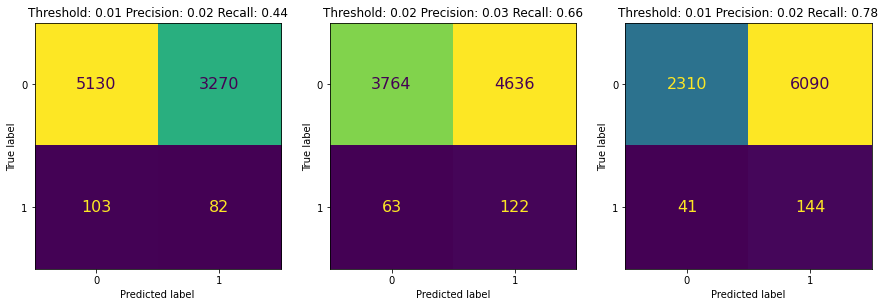

In [130]:
ev.vis_confusion_matrix(nmf_logit_512, col_name='NMF_logit_512', fold_range=range(5))

In [ ]:
ev.vis_calibration_curve(nmf_logit_512, col_name='NMF_logit_512', fold_range=range(5))

### Image resolution 1024 x 1024

In [39]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading NMF feature extractor...
---Loading logit model...
---Getting predictions for batch  0
---Getting predictions for batch  1
---Getting predictions for batch  2
---Getting predictions for batch  3
---Getting predictions for batch  4
---Getting predictions for batch  5
---Getting predictions for batch  6
---Getting predictions for batch  7
---Getting predictions for batch  8
---Getting predictions for batch  9
---Getting predictions for batch  10
---Getting predictions for batch  11
---Getting predictions for batch  12
---Getting predictions for batch  13
---Getting predictions for batch  14
---Getting predictions for batch  15
---Getting predictions for batch  16
Finish all batches!


In [40]:
nmf_logit_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  NMF_logit_1024.csv


In [41]:
nmf_logit_1024.head()

image_id  cancer  NMF_logit_1024_0
0   111020467       0          0.018935
1  1360770089       0          0.017604
2    21872985       0          0.019196
3  1924268326       0          0.017938
4  1332075298       0          0.018120

In [56]:
nmf_logit_1024[nmf_logit_1024.cancer==1].sample(5)

image_id  cancer  NMF_logit_1024_0
8555    88710137       1          0.016362
2697   791267021       1          0.017029
8174   145170954       1          0.017226
1475  1557228175       1          0.019033
5529  1646496367       1          0.018206

In [87]:
nmf_logit_1024 = pd.read_csv('NMF_logit_1024.csv')
nmf_logit_1024_scores = ev.make_score_df(nmf_logit_1024, col_name='NMF_logit_1024', fold_range=range(1))
nmf_logit_1024_scores 

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_logit_1024_0   0.018083        0.038056  0.023149  0.470247  0.042792   

     recall  precision           confusion_matrix    tn    fp  fn   tp  \
0  0.637838   0.022139  [[3188, 5212], [67, 118]]  3188  5212  67  118   

   accuracy  pos_brier_loss  neg_brier_loss  
0   0.38509        0.961576        0.000392

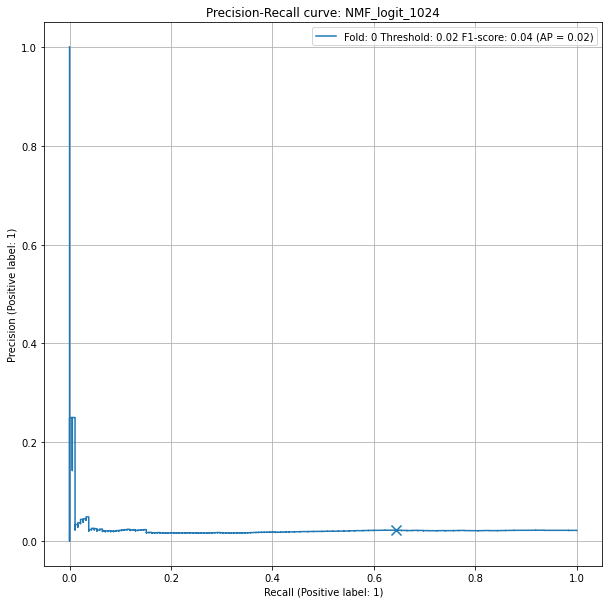

In [90]:
ev.vis_pr_curve(nmf_logit_1024, col_name='NMF_logit_1024', fold_range=range(1))

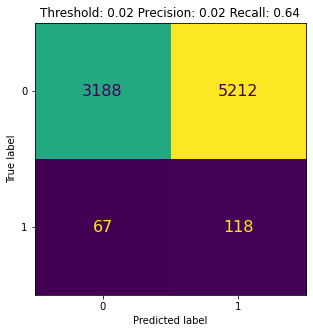

In [88]:
ev.vis_confusion_matrix(nmf_logit_1024, col_name='NMF_logit_1024', fold_range=range(1))

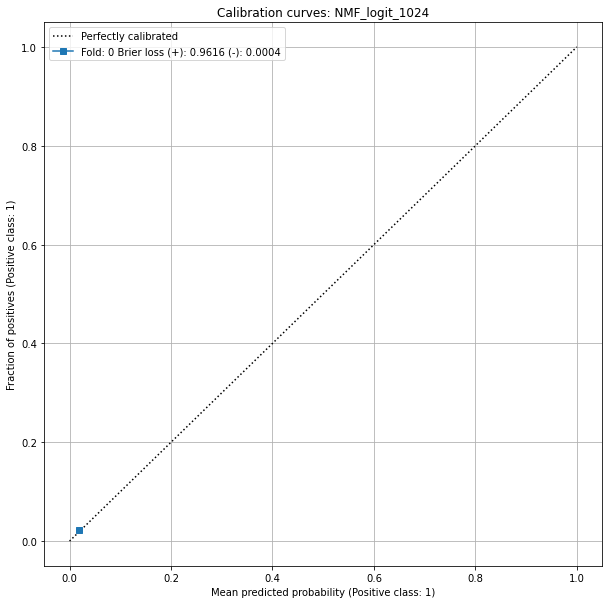

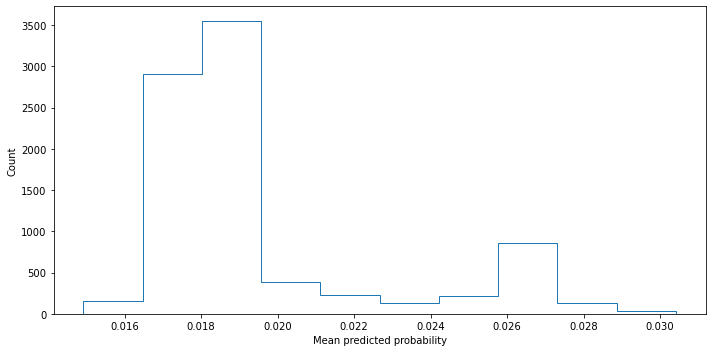

In [137]:
ev.vis_calibration_curve(nmf_logit_1024, col_name='NMF_logit_1024', fold_range=range(1))

## NMF + Random Forest

### Image resolution 256 x 256

In [57]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading NMF feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  1
---Loading NMF feature extractor...
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  2
---Loading NMF feature extractor...
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  3
---Loading NMF feature extractor...
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  16
Finish all batches!
Fold:  4
---Loading NMF feature extractor...
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


In [58]:
nmf_rfc_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  NMF_rfc_256.csv


In [59]:
nmf_rfc_256.head()

image_id  cancer  NMF_rfc_256_0  NMF_rfc_256_1  NMF_rfc_256_2  \
0   111020467       0       0.027323       0.019112       0.035020   
1  1360770089       0       0.004142       0.032483       0.031468   
2    21872985       0       0.037238       0.039740       0.069367   
3  1924268326       0       0.018768       0.024237       0.004318   
4  1332075298       0       0.048371       0.021233       0.038988   

   NMF_rfc_256_3  NMF_rfc_256_4  
0       0.045696       0.036596  
1       0.025629       0.004651  
2       0.011501       0.001136  
3       0.005969       0.002076  
4       0.022222       0.029841

In [60]:
nmf_rfc_256[nmf_rfc_256.cancer==1].sample(5)

image_id  cancer  NMF_rfc_256_0  NMF_rfc_256_1  NMF_rfc_256_2  \
4006  1912780715       1       0.020809       0.060200       0.006468   
4138  1922119353       1       0.014964       0.013165       0.016667   
8331   583119542       1       0.010875       0.015677       0.004484   
102   1084546948       1       0.024853       0.002445       0.055020   
5836   998306444       1       0.003853       0.019983       0.016667   

      NMF_rfc_256_3  NMF_rfc_256_4  
4006       0.008962       0.004651  
4138       0.010482       0.018839  
8331       0.000000       0.005426  
102        0.021587       0.017593  
5836       0.007918       0.018839

In [82]:
nmf_rfc_256 = pd.read_csv('NMF_rfc_256.csv')
nmf_rfc_256_scores = ev.make_score_df(nmf_rfc_256, col_name='NMF_rfc_256', fold_range=range(5))
nmf_rfc_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_rfc_256_0   0.025538        0.042133  0.022182  0.508917  0.043537   
0  NMF_rfc_256_1   0.011884        0.042406  0.021415  0.494007  0.043207   
0  NMF_rfc_256_2   0.002273        0.029589  0.019168  0.469503  0.043020   
0  NMF_rfc_256_3   0.000000        0.031965  0.019099  0.460655  0.039764   
0  NMF_rfc_256_4   0.046672        0.034276  0.023275  0.492776  0.044444   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.351351   0.023206  [[5664, 2736], [120, 65]]  5664  2736  120   65   
0  0.654054   0.022341  [[3105, 5295], [64, 121]]  3105  5295   64  121   
0  0.794595   0.022109  [[1898, 6502], [38, 147]]  1898  6502   38  147   
0  0.891892   0.020335   [[451, 7949], [20, 165]]   451  7949   20  165   
0  0.081081   0.030612   [[7925, 475], [170, 15]]  7925   475  170   15   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.667327        0.957728        0.000794  
0  0.375772        0.957431        0.000798  
0  0.238206        0.970383        0.000589  
0  0.071753        0.968028        0.000842  
0  0.924869        0.965741        0.000559

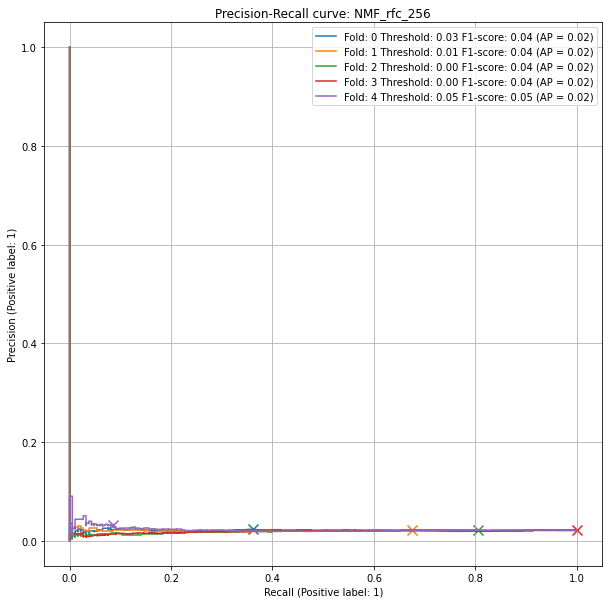

In [84]:
ev.vis_pr_curve(nmf_rfc_256, col_name='NMF_rfc_256', fold_range=range(5))

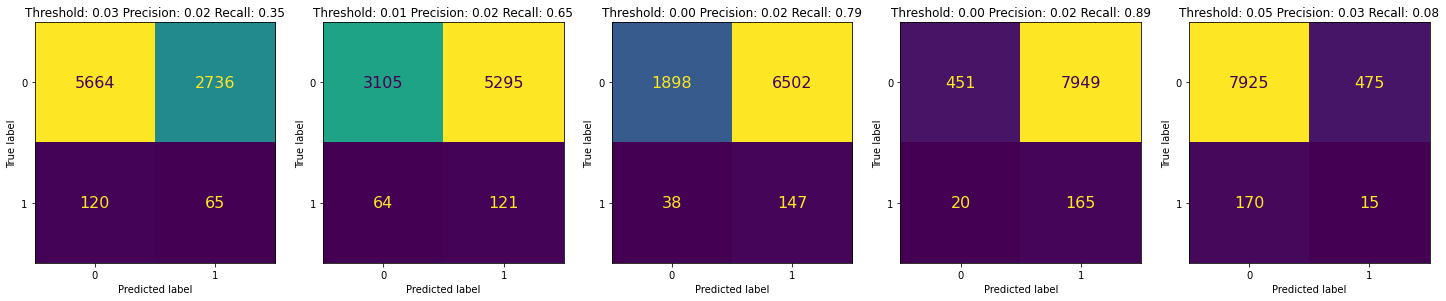

In [83]:
ev.vis_confusion_matrix(nmf_rfc_256, col_name='NMF_rfc_256', fold_range=range(5))

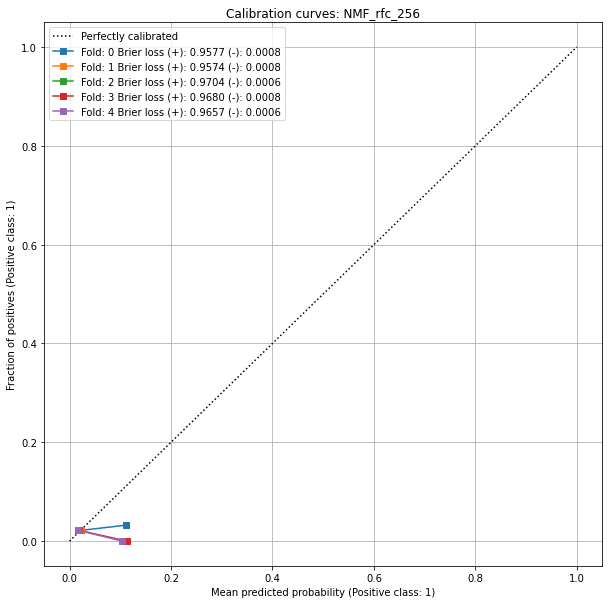

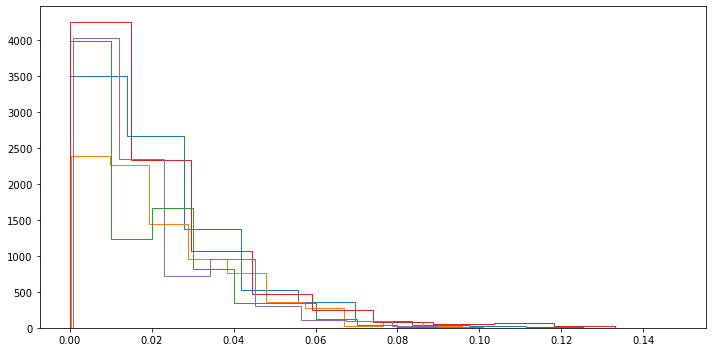

In [86]:
ev.vis_calibration_curve(nmf_rfc_256, col_name='NMF_rfc_256', fold_range=range(5))

### Image resolution 512 x 512

In [ ]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(3),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

In [ ]:
nmf_rfc_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='rfc',
    img_size=IMG_SIZE
)

In [10]:
nmf_rfc_512.head()

image_id  cancer  NMF_rfc_512_0  NMF_rfc_512_1  NMF_rfc_512_2
0   111020467       0       0.018254       0.025188       0.022994
1  1360770089       0       0.004876       0.039032       0.039183
2    21872985       0       0.007787       0.018434       0.002612
3  1924268326       0       0.044211       0.040319       0.028636
4  1332075298       0       0.027778       0.022404       0.084043

In [11]:
nmf_rfc_512[nmf_rfc_512.cancer==1].sample(5)

image_id  cancer  NMF_rfc_512_0  NMF_rfc_512_1  NMF_rfc_512_2
8136  1811195939       1       0.008036       0.023472       0.019014
4136   358240402       1       0.012688       0.026306       0.045303
335    334248774       1       0.002961       0.008465       0.022857
8331   583119542       1       0.017373       0.028307       0.002624
5631   382116832       1       0.002369       0.003193       0.016667

In [78]:
nmf_rfc_512 = pd.read_csv('NMF_rfc_512.csv')
nmf_rfc_512_scores = ev.make_score_df(nmf_rfc_512, col_name='NMF_rfc_512', fold_range=range(3))
nmf_rfc_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_rfc_512_0   0.021944        0.038894  0.021693  0.507576  0.046556   
0  NMF_rfc_512_1   0.026103        0.036126  0.021211  0.506400  0.045094   
0  NMF_rfc_512_2   0.002624        0.034966  0.019656  0.480520  0.043161   

     recall  precision           confusion_matrix    tn    fp   fn   tp  \
0  0.400000   0.024716  [[5480, 2920], [111, 74]]  5480  2920  111   74   
0  0.291892   0.024434  [[6244, 2156], [131, 54]]  6244  2156  131   54   
0  0.816216   0.022167  [[1739, 6661], [34, 151]]  1739  6661   34  151   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.646942        0.961018        0.000799  
0  0.733605        0.963760        0.000661  
0  0.220151        0.964956        0.000725

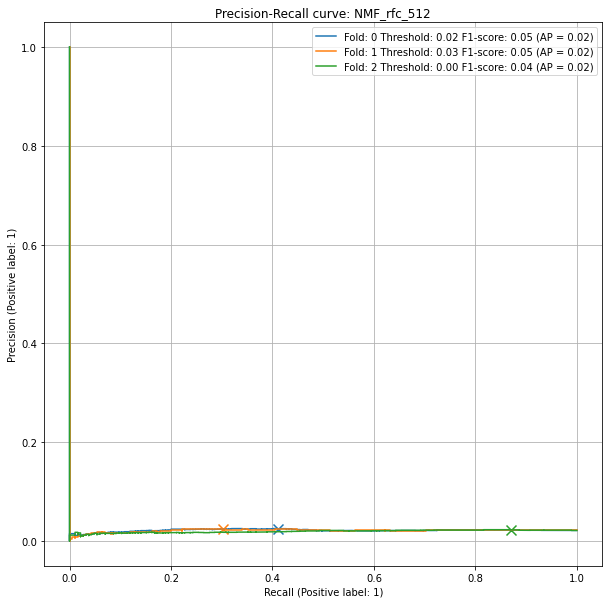

In [80]:
ev.vis_pr_curve(nmf_rfc_512, col_name='NMF_rfc_512', fold_range=range(3))

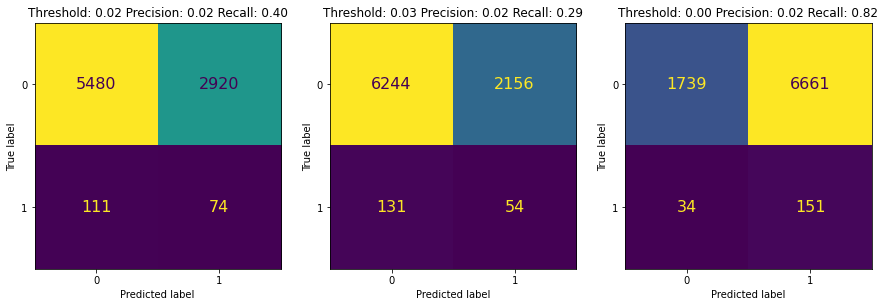

In [79]:
ev.vis_confusion_matrix(nmf_rfc_512, col_name='NMF_rfc_512', fold_range=range(3))

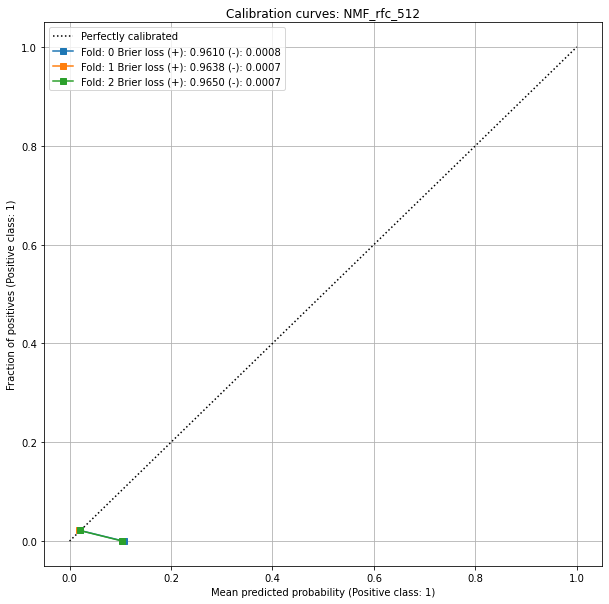

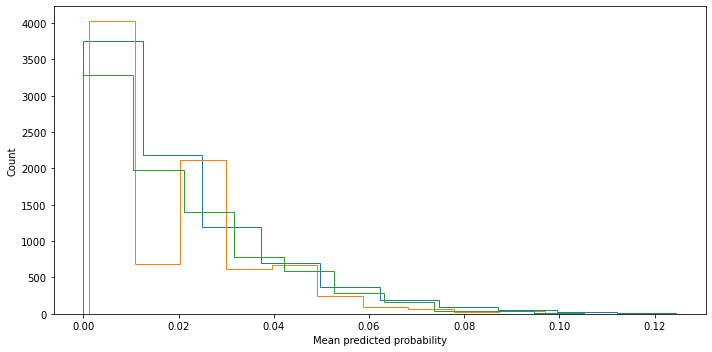

In [138]:
ev.vis_calibration_curve(nmf_rfc_512, col_name='NMF_rfc_512', fold_range=range(3))

### Image resolution 1024 x 1024

In [12]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 26
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'NMF',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = None,
    CNN_preprocess = None,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
---Loading NMF feature extractor...
---Loading rfc model...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished


In [13]:
nmf_rfc_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='NMF', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  NMF_rfc_1024.csv


In [14]:
nmf_rfc_1024.head()

image_id  cancer  NMF_rfc_1024_0
0   111020467       0        0.006154
1  1360770089       0        0.006233
2    21872985       0        0.019075
3  1924268326       0        0.021149
4  1332075298       0        0.060852

In [15]:
nmf_rfc_1024[nmf_rfc_1024.cancer==1].sample(5)

image_id  cancer  NMF_rfc_1024_0
7122   295341643       1        0.005851
5530  1873677554       1        0.004714
8331   583119542       1        0.024866
7252  1280544598       1        0.021205
8174   145170954       1        0.025084

In [74]:
nmf_rfc_1024 = pd.read_csv('NMF_rfc_1024.csv')
nmf_rfc_1024_scores = ev.make_score_df(nmf_rfc_1024, col_name='NMF_rfc_1024', fold_range=range(1))
nmf_rfc_1024_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  f1-score  \
0  NMF_rfc_1024_0   0.024866         0.04402  0.024558  0.529736  0.048632   

     recall  precision           confusion_matrix    tn    fp   fn  tp  \
0  0.345946   0.026154  [[6017, 2383], [121, 64]]  6017  2383  121  64   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.708328        0.955894        0.000746

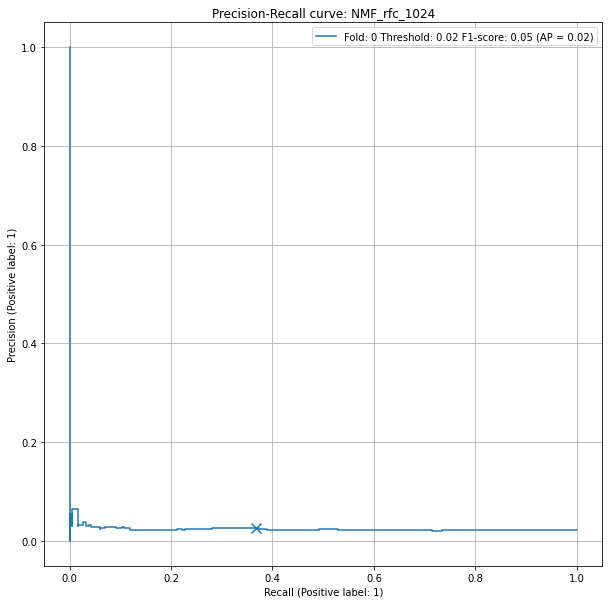

In [75]:
ev.vis_pr_curve(nmf_rfc_1024, col_name='NMF_rfc_1024', fold_range=range(1))

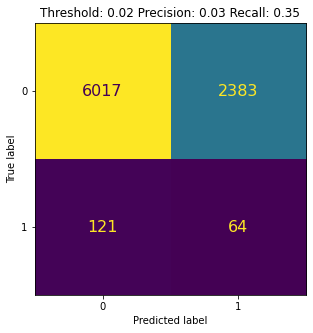

In [76]:
ev.vis_confusion_matrix(nmf_rfc_1024, col_name='NMF_rfc_1024', fold_range=range(1))

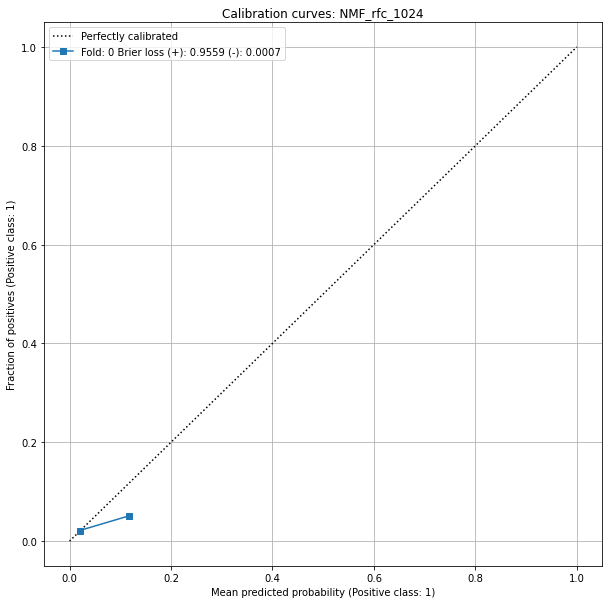

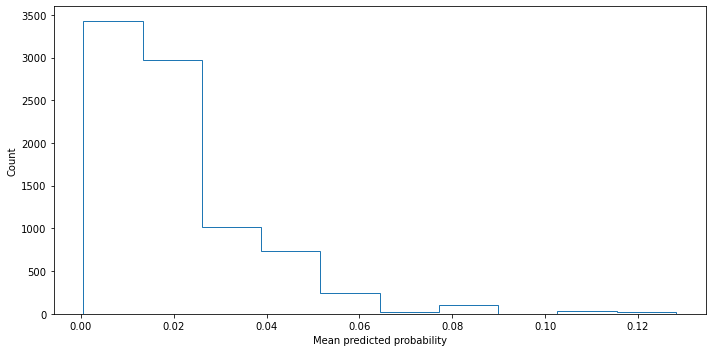

In [139]:
ev.vis_calibration_curve(nmf_rfc_1024, col_name='NMF_rfc_1024', fold_range=range(1))

## InceptionV3 (ImageNet)

### Image resolution 256 x 256

**1st Candidate**
- Batch size: 128
- Optimizer: Adam
- Learning rate: 1e-2
- From epoch: 19
- Validation loss: 0.1319

In [23]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_imagenet_checkpoint/selected_models/imagenet_256_batch128_adam_lr1e-2_epoch19_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 4s 202ms/step
---Getting predictions for batch  1
16/16 [==============================] - 3s 201ms/step
---Getting predictions for batch  2
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  3
16/16 [==============================] - 3s 193ms/step
---Getting predictions for batch  4
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  5
16/16 [==============================] - 3s 200ms/step
---Getting predictions for batch  6
16/16 [==============================] - 3s 196ms/step
---Getting predictions for batch  7
16/16 [==============================] - 3s 198ms/step
---Getting predictions for batch  8
16/16 [==============================] - 3s 193ms/step
---Getting predictions for batch  9
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  10
16/16 [==========

In [34]:
imagenet_lr1e_2_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_ImageNet_lr1e_2',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  _InceptionV3_ImageNet_lr1e_2_256.csv


In [35]:
imagenet_lr1e_2_256.head()

image_id  cancer  _InceptionV3_ImageNet_lr1e_2_256_0
0   111020467       0                            0.108191
1  1360770089       0                            0.154536
2    21872985       0                            0.209974
3  1924268326       0                            0.149648
4  1332075298       0                            0.068020

In [36]:
imagenet_lr1e_2_256[imagenet_lr1e_2_256.cancer==1].sample(5)

image_id  cancer  _InceptionV3_ImageNet_lr1e_2_256_0
2084   513700051       1                            0.009802
5837  1319601220       1                            0.024527
5634  1880776532       1                            0.069319
2376  2075727945       1                            0.050159
8564  1696075167       1                            0.036914

In [50]:
imagenet_lr1e_2_256 = pd.read_csv('InceptionV3_ImageNet_lr1e_2_256.csv')
imagenet_lr1e_2_256_scores = ev.make_score_df(imagenet_lr1e_2_256, col_name='InceptionV3_ImageNet_lr1e_2_256', fold_range=range(1))
imagenet_lr1e_2_256_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_lr1e_2_256_0   0.004639        0.099195  0.017552   

    roc_auc  f1-score    recall  precision        confusion_matrix  tn    fp  \
0  0.419701  0.042072  0.994595    0.02149  [[22, 8378], [1, 184]]  22  8378   

   fn   tp  accuracy  pos_brier_loss  neg_brier_loss  
0   1  184  0.023995         0.90016        0.006871

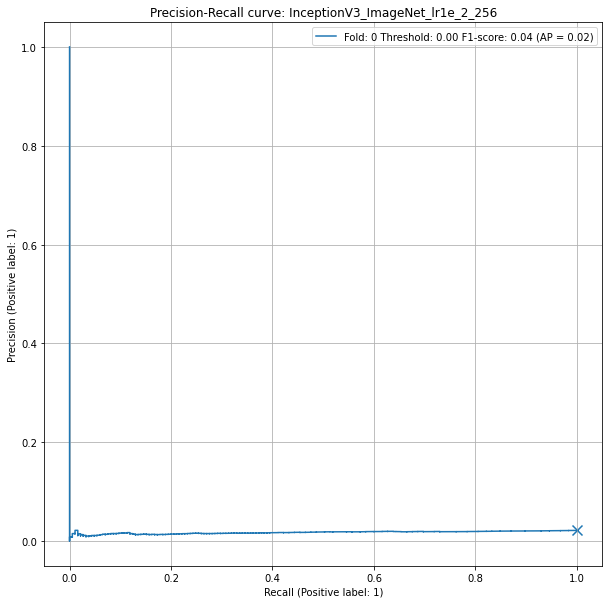

In [73]:
ev.vis_pr_curve(imagenet_lr1e_2_256, col_name='InceptionV3_ImageNet_lr1e_2_256', fold_range=range(1))

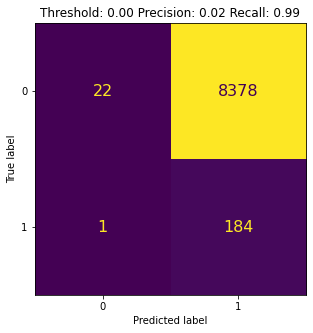

In [51]:
ev.vis_confusion_matrix(imagenet_lr1e_2_256, col_name='InceptionV3_ImageNet_lr1e_2_256', fold_range=range(1))

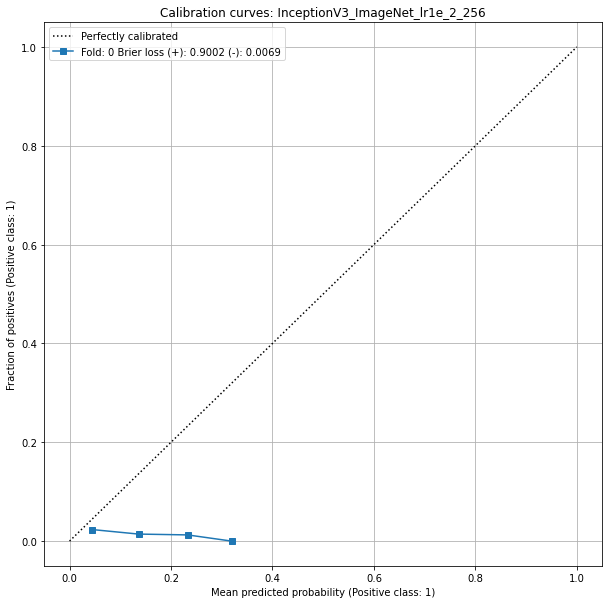

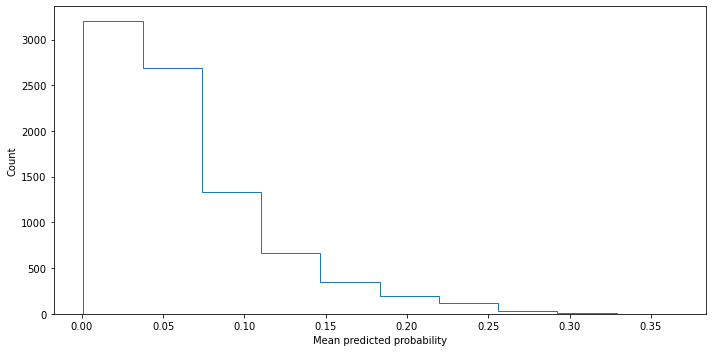

In [140]:
ev.vis_calibration_curve(imagenet_lr1e_2_256, col_name='InceptionV3_ImageNet_lr1e_2_256', fold_range=range(1))

**2nd Candidate**
- Batch size: 256
- Optimizer: Adam
- Learning rate: 1e-5
- From epoch: 11
- Validation loss: 0.5208

In [39]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_imagenet_checkpoint/selected_models/imagenet_256_batch256_adam_lr1e-5_epoch11_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 4s 203ms/step
---Getting predictions for batch  1
16/16 [==============================] - 3s 200ms/step
---Getting predictions for batch  2
16/16 [==============================] - 3s 198ms/step
---Getting predictions for batch  3
16/16 [==============================] - 3s 205ms/step
---Getting predictions for batch  4
16/16 [==============================] - 3s 197ms/step
---Getting predictions for batch  5
16/16 [==============================] - 3s 198ms/step
---Getting predictions for batch  6
16/16 [==============================] - 3s 199ms/step
---Getting predictions for batch  7
16/16 [==============================] - 3s 196ms/step
---Getting predictions for batch  8
16/16 [==============================] - 3s 197ms/step
---Getting predictions for batch  9
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  10
16/16 [==========

In [40]:
imagenet_lr1e_5_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_ImageNet_lr1e_5',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  _InceptionV3_ImageNet_lr1e_5_256.csv


In [41]:
imagenet_lr1e_5_256.head()

image_id  cancer  _InceptionV3_ImageNet_lr1e_5_256_0
0   111020467       0                            0.274367
1  1360770089       0                            0.453732
2    21872985       0                            0.478063
3  1924268326       0                            0.415320
4  1332075298       0                            0.288846

In [44]:
imagenet_lr1e_5_256[imagenet_lr1e_5_256.cancer==1].sample(5)

image_id  cancer  _InceptionV3_ImageNet_lr1e_5_256_0
5459   914043890       1                            0.307582
6022  1410656943       1                            0.342738
7121   192415761       1                            0.419423
3355  1605876492       1                            0.530046
2727  1362919630       1                            0.451230

In [42]:
imagenet_lr1e_5_256 = pd.read_csv('InceptionV3_ImageNet_lr1e_5_256.csv')
imagenet_lr1e_5_256_scores = ev.make_score_df(imagenet_lr1e_5_256, col_name='InceptionV3_ImageNet_lr1e_5_256', fold_range=range(1))
imagenet_lr1e_5_256_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_lr1e_5_256_0   0.165903        0.550379  0.020261   

    roc_auc  f1-score    recall  precision        confusion_matrix  tn    fp  \
0  0.460225   0.04211  0.994595    0.02151  [[30, 8370], [1, 184]]  30  8370   

   fn   tp  accuracy  pos_brier_loss  neg_brier_loss  
0   1  184  0.024927        0.389836        0.164081

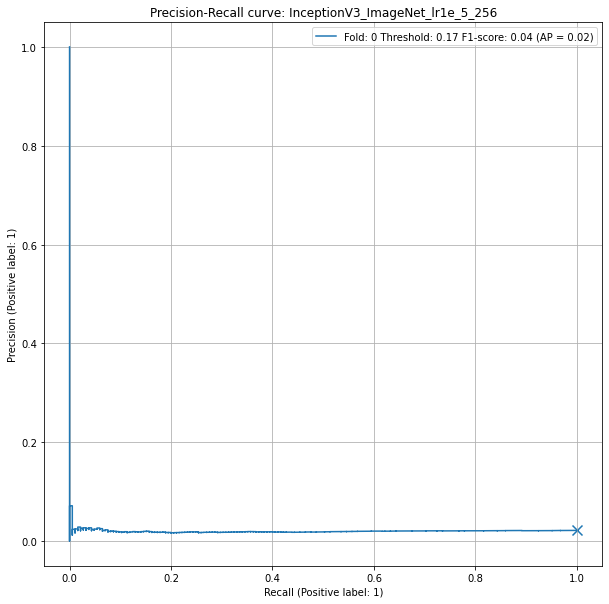

In [72]:
ev.vis_pr_curve(imagenet_lr1e_5_256, col_name='InceptionV3_ImageNet_lr1e_5_256', fold_range=range(1))

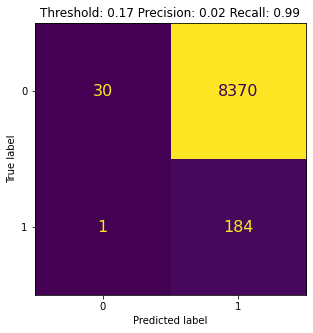

In [44]:
ev.vis_confusion_matrix(imagenet_lr1e_5_256, col_name='InceptionV3_ImageNet_lr1e_5_256', fold_range=range(1))

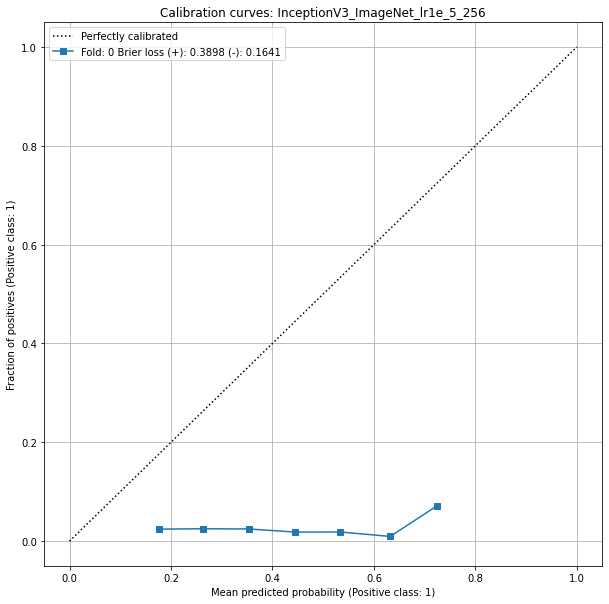

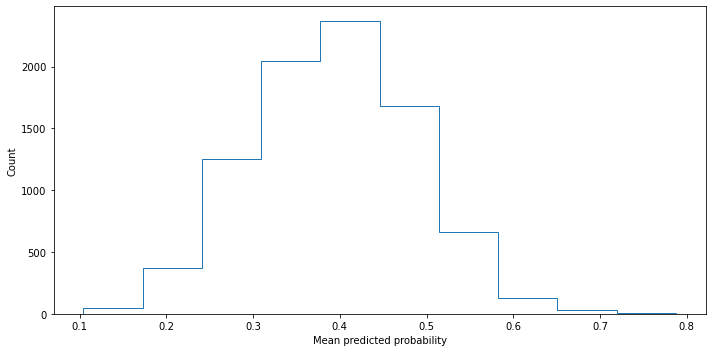

In [141]:
ev.vis_calibration_curve(imagenet_lr1e_5_256, col_name='InceptionV3_ImageNet_lr1e_5_256', fold_range=range(1))

### Image resolution 512 x 512

In [89]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_imagenet_checkpoint/selected_models/imagenet_512_batch128_adam_lr1e-5_epoch16_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 15s 899ms/step
---Getting predictions for batch  1
16/16 [==============================] - 15s 908ms/step
---Getting predictions for batch  2
16/16 [==============================] - 15s 919ms/step
---Getting predictions for batch  3
16/16 [==============================] - 14s 888ms/step
---Getting predictions for batch  4
16/16 [==============================] - 15s 909ms/step
---Getting predictions for batch  5
16/16 [==============================] - 15s 908ms/step
---Getting predictions for batch  6
16/16 [==============================] - 14s 891ms/step
---Getting predictions for batch  7
16/16 [==============================] - 14s 886ms/step
---Getting predictions for batch  8
16/16 [==============================] - 14s 879ms/step
---Getting predictions for batch  9
16/16 [==============================] - 14s 889ms/step
---Getting predictions for batch  10
16/16 [

In [90]:
imagenet_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_ImageNet',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  _InceptionV3_ImageNet_512.csv


In [95]:
imagenet_512.head()

image_id  cancer  InceptionV3_ImageNet_512_0
0   111020467       0                    0.509243
1  1360770089       0                    0.543226
2    21872985       0                    0.566387
3  1924268326       0                    0.524909
4  1332075298       0                    0.538060

In [96]:
imagenet_512[imagenet_512.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_512_0
2494  1812305728       1                    0.547851
6165  1949604033       1                    0.525831
7123   914306111       1                    0.502149
4138  1922119353       1                    0.509925
2553  2129233566       1                    0.603337

In [38]:
imagenet_512 = pd.read_csv('InceptionV3_ImageNet_512.csv')
imagenet_512_scores = ev.make_score_df(imagenet_512, col_name='InceptionV3_ImageNet_512', fold_range=range(1))
imagenet_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  InceptionV3_ImageNet_512_0   0.571413        0.665349  0.019664  0.442381   

   f1-score    recall  precision          confusion_matrix    tn   fp   fn  \
0  0.041379  0.081081   0.027778  [[7875, 525], [170, 15]]  7875  525  170   

   tp  accuracy  pos_brier_loss  neg_brier_loss  
0  15  0.919045        0.247555        0.261857

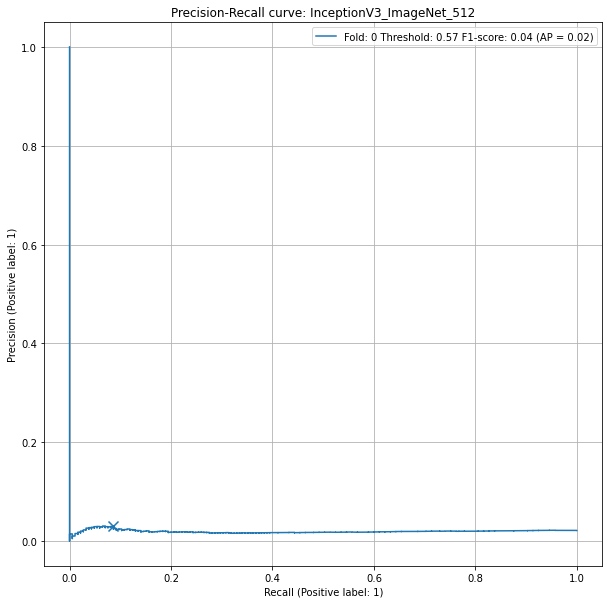

In [71]:
ev.vis_pr_curve(imagenet_512, col_name='InceptionV3_ImageNet_512', fold_range=range(1))

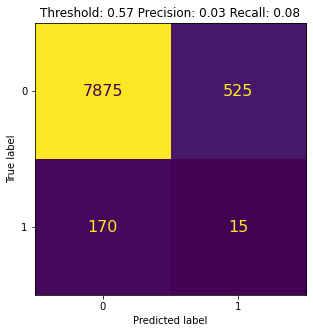

In [39]:
ev.vis_confusion_matrix(imagenet_512, col_name='InceptionV3_ImageNet_512', fold_range=range(1))

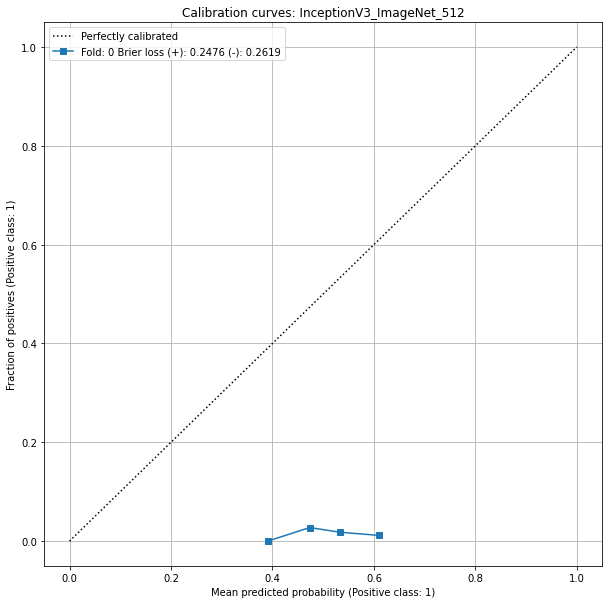

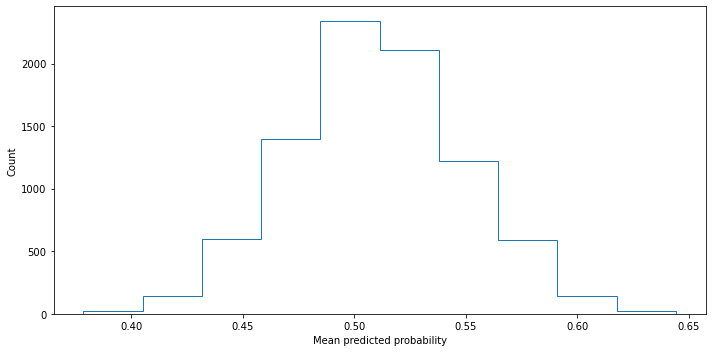

In [142]:
ev.vis_calibration_curve(imagenet_512, col_name='InceptionV3_ImageNet_512', fold_range=range(1))

## Image resolution 1024 x 1024

In [143]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_imagenet_checkpoint/selected_models/imagenet_1024_batch64_sgd_lr1e-5_epoch7_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 73s 4s/step
---Getting predictions for batch  1
16/16 [==============================] - 68s 4s/step
---Getting predictions for batch  2
16/16 [==============================] - 68s 4s/step
---Getting predictions for batch  3
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  4
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  5
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  6
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  7
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  8
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  9
16/16 [==============================] - 67s 4s/step
---Getting predictions for batch  10
16/16 [==============================

In [150]:
imagenet_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_ImageNet',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  InceptionV3_ImageNet_1024.csv


In [145]:
imagenet_1024.head()

image_id  cancer  InceptionV3_ImageNet_1024_0
0   111020467       0                     0.528464
1  1360770089       0                     0.542867
2    21872985       0                     0.547072
3  1924268326       0                     0.533940
4  1332075298       0                     0.520474

In [146]:
imagenet_1024[imagenet_1024.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_1024_0
2506  1858716768       1                     0.527472
7252  1280544598       1                     0.516838
7051   657242412       1                     0.551221
1048  2053280259       1                     0.557043
7607  1294872933       1                     0.545188

In [152]:
imagenet_1024 = pd.read_csv('InceptionV3_ImageNet_1024.csv')
imagenet_1024_scores = ev.make_score_df(imagenet_1024, col_name='InceptionV3_ImageNet_1024', fold_range=range(1))
imagenet_1024_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  InceptionV3_ImageNet_1024_0   0.547399        0.690532  0.024173  0.525568   

   f1-score    recall  precision           confusion_matrix    tn    fp   fn  \
0   0.04934  0.232432   0.027599  [[6885, 1515], [142, 43]]  6885  1515  142   

   tp  accuracy  pos_brier_loss  neg_brier_loss  
0  43  0.806989        0.217854        0.283648

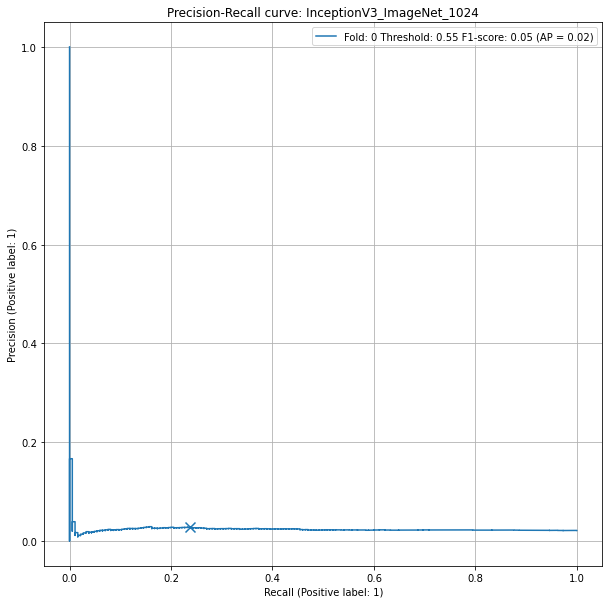

In [153]:
ev.vis_pr_curve(imagenet_1024, col_name='InceptionV3_ImageNet_1024', fold_range=range(1))

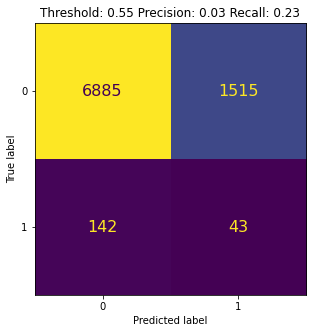

In [154]:
ev.vis_confusion_matrix(imagenet_1024, col_name='InceptionV3_ImageNet_1024', fold_range=range(1))

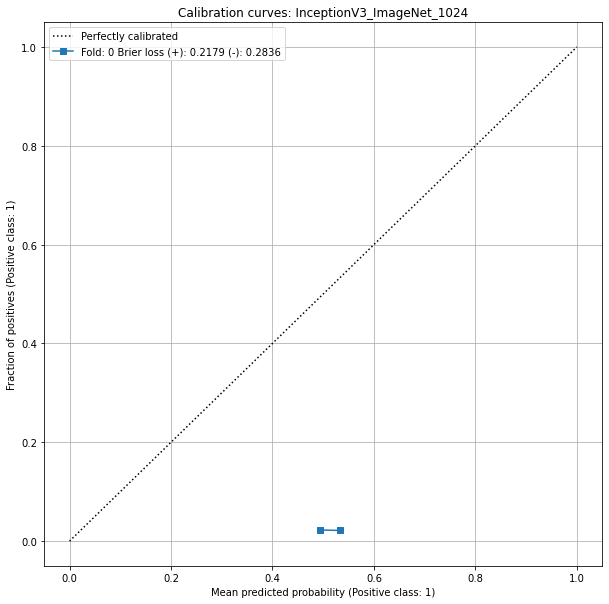

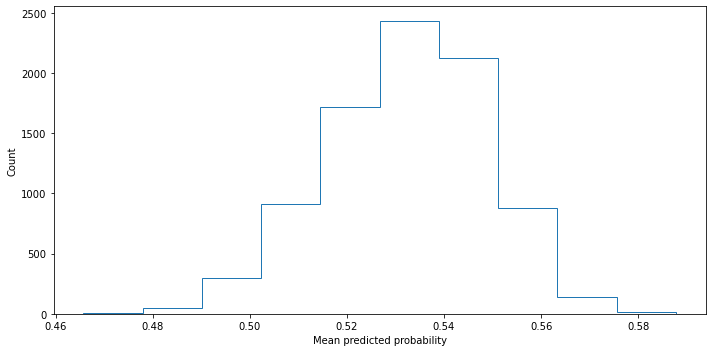

In [155]:
ev.vis_calibration_curve(imagenet_1024, col_name='InceptionV3_ImageNet_1024', fold_range=range(1))

## InceptionV3 (ImageNet) + Logistic Regression

### Image resolution 256 x 256

In [109]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading logit model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0
--->>> Tranforming X with CNN...
---Getting predictions for batch  1
--->>> Tranforming X with CNN...
---Getting predictions for batch  2
--->>> Tranforming X with CNN...
---Getting predictions for batch  3
--->>> Tranforming X with CNN...
---Getting predictions for batch  4
--->>> Tranforming X with CNN...
---Getting predictions for batch  5
--->>> Tranforming X with CNN...
---Getting predictions for batch  6
--->>> Tranforming X with CNN...
---Getting predictions for batch  7
--->>> Tranforming X with CNN...
---Getting predictions for batch  8
--->>> Tranforming X with CNN...
---Getting predictions for batch  9
--->>> Tranforming X with CNN...
---Getting predictions for batch  10
--->>> Tranforming X with CNN...
---Getting predictions for batch  11
--->>> Tranforming X with CNN...
---Getting predictions for batch  12
--->>> Tranforming X with CNN...

In [110]:
imagenet_logit_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  InceptionV3_ImageNet_logit_256.csv


In [111]:
imagenet_logit_256.head()

image_id  cancer  InceptionV3_ImageNet_logit_256_0  \
0   111020467       0                          0.010792   
1  1360770089       0                          0.009456   
2    21872985       0                          0.017878   
3  1924268326       0                          0.023320   
4  1332075298       0                          0.035142   

   InceptionV3_ImageNet_logit_256_1  InceptionV3_ImageNet_logit_256_2  \
0                          0.016235                          0.020868   
1                          0.009334                          0.016997   
2                          0.017454                          0.042315   
3                          0.010808                          0.022448   
4                          0.019765                          0.022158   

   InceptionV3_ImageNet_logit_256_3  InceptionV3_ImageNet_logit_256_4  
0                          0.007454                          0.019076  
1                          0.015743                          0.011136  
2                          0.015223                          0.021566  
3                          0.010091                          0.011159  
4                          0.005299                          0.024637

In [112]:
imagenet_logit_256[imagenet_logit_256.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_logit_256_0  \
3769   669303826       1                          0.008579   
2452  1949261883       1                          0.053389   
4777  1312979917       1                          0.007071   
339   1802895010       1                          0.009458   
7640  2075900290       1                          0.012732   

      InceptionV3_ImageNet_logit_256_1  InceptionV3_ImageNet_logit_256_2  \
3769                          0.012066                          0.023358   
2452                          0.025893                          0.022924   
4777                          0.027884                          0.043653   
339                           0.005586                          0.019029   
7640                          0.010360                          0.038270   

      InceptionV3_ImageNet_logit_256_3  InceptionV3_ImageNet_logit_256_4  
3769                          0.016882                          0.007273  
2452                          0.018897                          0.024709  
4777                          0.022901                          0.062580  
339                           0.006414                          0.019950  
7640                          0.024979                          0.010482

In [34]:
imagenet_logit_256 = pd.read_csv('InceptionV3_ImageNet_logit_256.csv')
imagenet_logit_256_scores = ev.make_score_df(imagenet_logit_256, col_name='InceptionV3_ImageNet_logit_256', fold_range=range(5))
imagenet_logit_256_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_logit_256_0   0.030824        0.043011  0.027438   
0  InceptionV3_ImageNet_logit_256_1   0.035421        0.044193  0.025671   
0  InceptionV3_ImageNet_logit_256_2   0.037986        0.057637  0.023893   
0  InceptionV3_ImageNet_logit_256_3   0.046106        0.041252  0.028160   
0  InceptionV3_ImageNet_logit_256_4   0.024526        0.032888  0.023653   

    roc_auc  f1-score    recall  precision           confusion_matrix    tn  \
0  0.551096  0.058628  0.237838   0.033435  [[7128, 1272], [141, 44]]  7128   
0  0.553209  0.053883  0.183784   0.031569  [[7357, 1043], [151, 34]]  7357   
0  0.539660  0.052356  0.297297   0.028706  [[6539, 1861], [130, 55]]  6539   
0  0.575395  0.054140  0.091892   0.038375   [[7974, 426], [168, 17]]  7974   
0  0.521956  0.049102  0.221622   0.027609  [[6956, 1444], [144, 41]]  6956   

     fp   fn  tp  accuracy  pos_brier_loss  neg_brier_loss  
0  1272  141  44  0.835411        0.956749        0.000567  
0  1043  151  34  0.860920        0.955509        0.000669  
0  1861  130  55  0.768084        0.941931        0.001380  
0   426  168  17  0.930810        0.958606        0.000552  
0  1444  144  41  0.815026        0.966978        0.000401

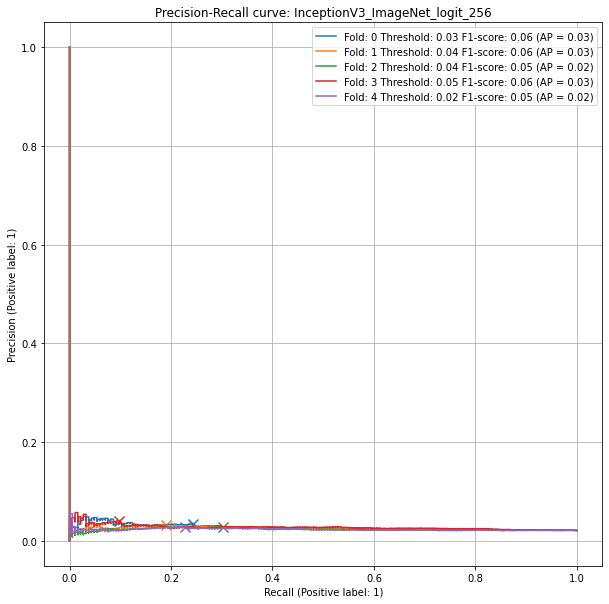

In [68]:
ev.vis_pr_curve(imagenet_logit_256, col_name='InceptionV3_ImageNet_logit_256', fold_range=range(5))

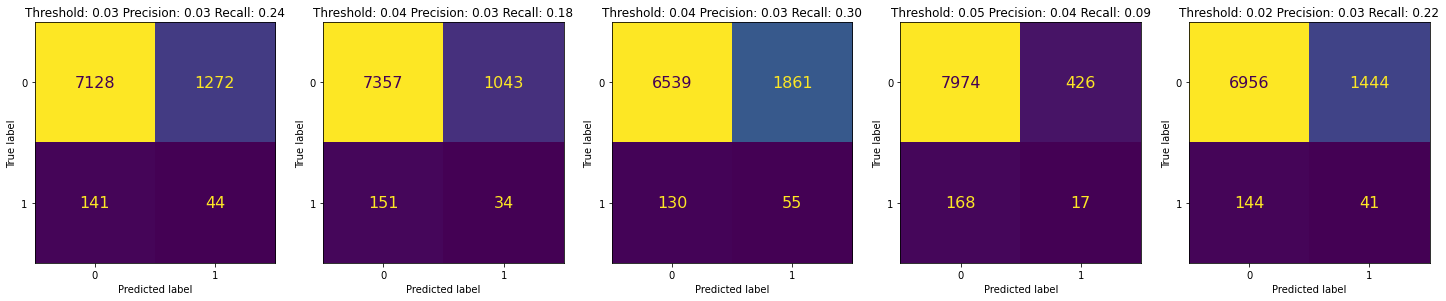

In [35]:
ev.vis_confusion_matrix(imagenet_logit_256, col_name='InceptionV3_ImageNet_logit_256', fold_range=range(5))

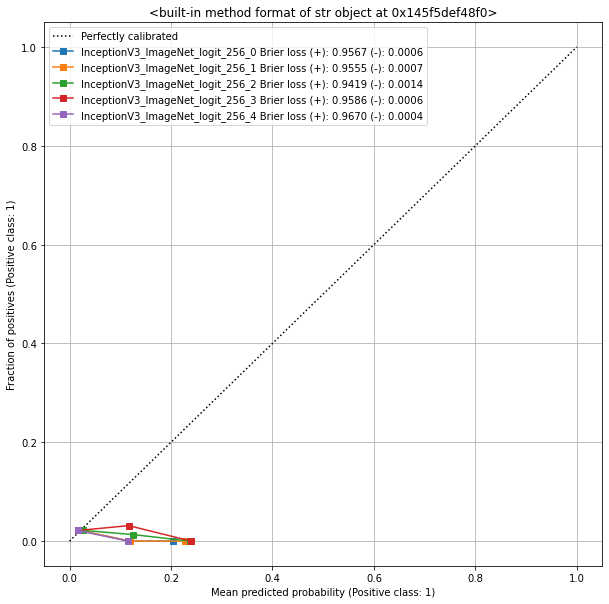

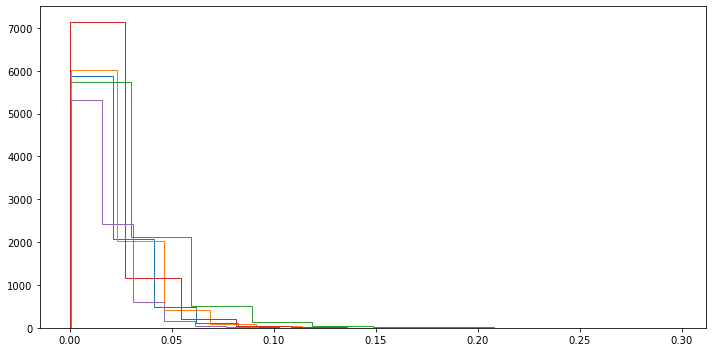

In [36]:
ev.vis_calibration_curve(imagenet_logit_256, col_name='InceptionV3_ImageNet_logit_256', fold_range=range(5))

### Image resolution 512 x 512

In [156]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading logit model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0
--->>> Tranforming X with CNN...
---Getting predictions for batch  1
--->>> Tranforming X with CNN...
---Getting predictions for batch  2
--->>> Tranforming X with CNN...
---Getting predictions for batch  3
--->>> Tranforming X with CNN...
---Getting predictions for batch  4
--->>> Tranforming X with CNN...
---Getting predictions for batch  5
--->>> Tranforming X with CNN...
---Getting predictions for batch  6
--->>> Tranforming X with CNN...
---Getting predictions for batch  7
--->>> Tranforming X with CNN...
---Getting predictions for batch  8
--->>> Tranforming X with CNN...
---Getting predictions for batch  9
--->>> Tranforming X with CNN...
---Getting predictions for batch  10
--->>> Tranforming X with CNN...
---Getting predictions for batch  11
--->>> Tranforming X with CNN...
---Getting predictions for batch  12
--->>> Tranforming X with CNN...

In [157]:
imagenet_logit_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='logit',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  InceptionV3_ImageNet_logit_512.csv


In [158]:
imagenet_logit_512.head()

image_id  cancer  InceptionV3_ImageNet_logit_512_0  \
0   111020467       0                          0.013493   
1  1360770089       0                          0.013377   
2    21872985       0                          0.010394   
3  1924268326       0                          0.024875   
4  1332075298       0                          0.016993   

   InceptionV3_ImageNet_logit_512_1  InceptionV3_ImageNet_logit_512_2  \
0                          0.037627                          0.015935   
1                          0.029485                          0.016912   
2                          0.049412                          0.004924   
3                          0.051052                          0.005386   
4                          0.014480                          0.004857   

   InceptionV3_ImageNet_logit_512_3  InceptionV3_ImageNet_logit_512_4  
0                          0.014439                          0.048403  
1                          0.008994                          0.042835  
2                          0.006263                          0.051650  
3                          0.011257                          0.037276  
4                          0.007276                          0.013517

In [159]:
imagenet_logit_512[imagenet_logit_512.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_logit_512_0  \
5458   442815464       1                          0.011604   
831    143752167       1                          0.010722   
130    809904326       1                          0.047750   
2646  1060299310       1                          0.064237   
2859  1214090918       1                          0.004338   

      InceptionV3_ImageNet_logit_512_1  InceptionV3_ImageNet_logit_512_2  \
5458                          0.016415                          0.003988   
831                           0.051776                          0.013182   
130                           0.099533                          0.015018   
2646                          0.174509                          0.006367   
2859                          0.028206                          0.011235   

      InceptionV3_ImageNet_logit_512_3  InceptionV3_ImageNet_logit_512_4  
5458                          0.019728                          0.054994  
831                           0.007071                          0.049160  
130                           0.026812                          0.053623  
2646                          0.016785                          0.022634  
2859                          0.006734                          0.052313

In [160]:
imagenet_logit_512 = pd.read_csv('InceptionV3_ImageNet_logit_512.csv')
imagenet_logit_512_scores = ev.make_score_df(imagenet_logit_512, col_name='InceptionV3_ImageNet_logit_512', fold_range=range(5))
imagenet_logit_512_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_logit_512_0   0.041211        0.052082  0.024653   
0  InceptionV3_ImageNet_logit_512_1   0.073218        0.105301  0.026109   
0  InceptionV3_ImageNet_logit_512_2   0.029293        0.023742  0.025632   
0  InceptionV3_ImageNet_logit_512_3   0.028775        0.029568  0.034454   
0  InceptionV3_ImageNet_logit_512_4   0.045033        0.079320  0.024380   

    roc_auc  f1-score    recall  precision           confusion_matrix    tn  \
0  0.548630  0.050070  0.194595   0.028731  [[7183, 1217], [149, 36]]  7183   
0  0.549731  0.055352  0.286486   0.030636  [[6723, 1677], [132, 53]]  6723   
0  0.531823  0.059701  0.086486   0.045584   [[8065, 335], [169, 16]]  8065   
0  0.577371  0.063604  0.097297   0.047244   [[8037, 363], [167, 18]]  8037   
0  0.526005  0.049964  0.378378   0.026748  [[5853, 2547], [115, 70]]  5853   

     fp   fn  tp  accuracy  pos_brier_loss  neg_brier_loss  
0  1217  149  36  0.840885        0.947501        0.000908  
0  1677  132  53  0.789284        0.894093        0.004384  
0   335  169  16  0.941293        0.976205        0.000192  
0   363  167  18  0.938264        0.970360        0.000216  
0  2547  115  70  0.689924        0.919913        0.002269

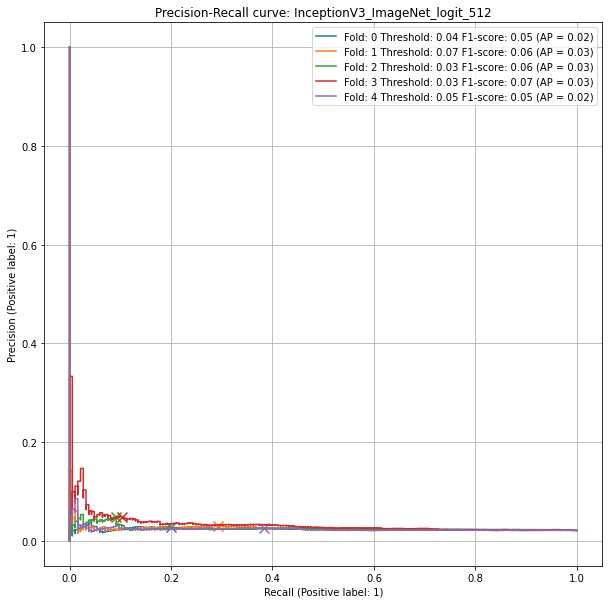

In [161]:
ev.vis_pr_curve(imagenet_logit_512, col_name='InceptionV3_ImageNet_logit_512', fold_range=range(5))

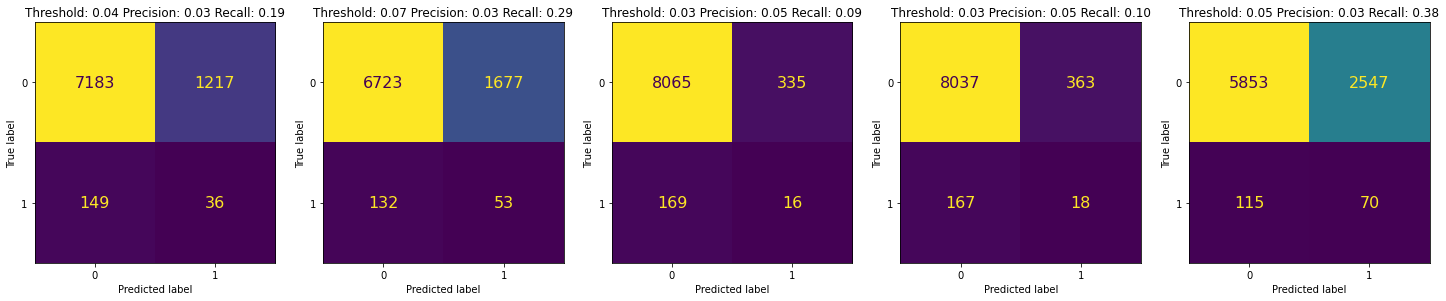

In [162]:
ev.vis_confusion_matrix(imagenet_logit_512, col_name='InceptionV3_ImageNet_logit_512', fold_range=range(5))

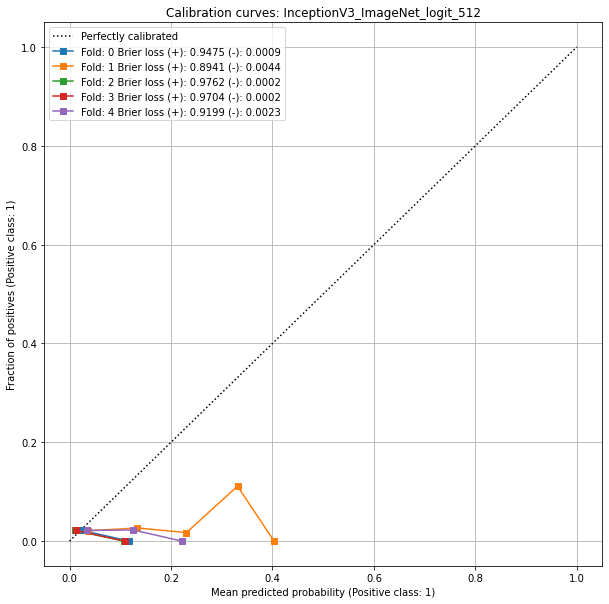

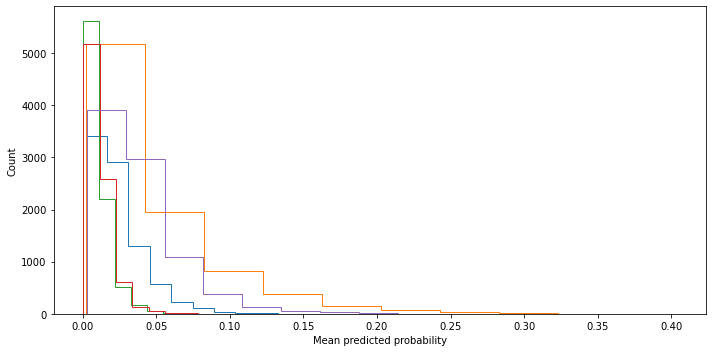

In [163]:
ev.vis_calibration_curve(imagenet_logit_512, col_name='InceptionV3_ImageNet_logit_512', fold_range=range(5))

### Image resolution 1024 x 1024

In [ ]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'logit',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    minibatch = True,
    minibatch_size = 128,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading logit model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0
--->>> Tranforming X with CNN...
---Getting predictions for batch  1
--->>> Tranforming X with CNN...
---Getting predictions for batch  2
--->>> Tranforming X with CNN...
---Getting predictions for batch  3
--->>> Tranforming X with CNN...
---Getting predictions for batch  4
--->>> Tranforming X with CNN...
---Getting predictions for batch  5
--->>> Tranforming X with CNN...
---Getting predictions for batch  6
--->>> Tranforming X with CNN...
---Getting predictions for batch  7
--->>> Tranforming X with CNN...
---Getting predictions for batch  8
--->>> Tranforming X with CNN...
---Getting predictions for batch  9
--->>> Tranforming X with CNN...
---Getting predictions for batch  10
--->>> Tranforming X with CNN...
---Getting predictions for batch  11
--->>> Tranforming X with CNN...
---Getting predictions for batch  12
--->>> Tranforming X with CNN...

In [8]:
imagenet_logit_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='logit',
    img_size=IMG_SIZE
)

In [9]:
imagenet_logit_1024.head()

image_id  cancer  InceptionV3_ImageNet_logit_1024_0  \
0   111020467       0                           0.024061   
1  1360770089       0                           0.017873   
2    21872985       0                           0.002535   
3  1924268326       0                           0.015255   
4  1332075298       0                           0.044894   

   InceptionV3_ImageNet_logit_1024_1  InceptionV3_ImageNet_logit_1024_2  \
0                           0.025402                           0.008971   
1                           0.014778                           0.004534   
2                           0.010723                           0.006044   
3                           0.010538                           0.005913   
4                           0.020287                           0.032673   

   InceptionV3_ImageNet_logit_1024_3  InceptionV3_ImageNet_logit_1024_4  
0                           0.007513                           0.007704  
1                           0.005914                           0.011458  
2                           0.002220                           0.012373  
3                           0.005277                           0.022520  
4                           0.013194                           0.017609

In [10]:
imagenet_logit_1024[imagenet_logit_1024.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_logit_1024_0  \
101    593509035       1                           0.008901   
5460  1464760605       1                           0.022623   
8176  1564214908       1                           0.009139   
7573  1327695628       1                           0.027568   
7000   953630878       1                           0.021101   

      InceptionV3_ImageNet_logit_1024_1  InceptionV3_ImageNet_logit_1024_2  \
101                            0.004057                           0.017655   
5460                           0.018513                           0.019477   
8176                           0.006754                           0.011566   
7573                           0.013887                           0.012342   
7000                           0.024762                           0.026646   

      InceptionV3_ImageNet_logit_1024_3  InceptionV3_ImageNet_logit_1024_4  
101                            0.004427                           0.003879  
5460                           0.011298                           0.012237  
8176                           0.023494                           0.019114  
7573                           0.004664                           0.007432  
7000                           0.017894                           0.012254

In [11]:
imagenet_logit_1024 = pd.read_csv('InceptionV3_ImageNet_logit_1024.csv')
imagenet_logit_1024_scores = ev.make_score_df(imagenet_logit_1024, col_name='InceptionV3_ImageNet_logit_1024', fold_range=range(5))
imagenet_logit_1024_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_logit_1024_0   0.041347        0.057992  0.027902   
0  InceptionV3_ImageNet_logit_1024_1   0.042574        0.045498  0.029119   
0  InceptionV3_ImageNet_logit_1024_2   0.037569        0.043007  0.039124   
0  InceptionV3_ImageNet_logit_1024_3   0.027392        0.044231  0.038143   
0  InceptionV3_ImageNet_logit_1024_4   0.019760        0.035030  0.021688   

    roc_auc  f1-score    recall  precision           confusion_matrix    tn  \
0  0.553096  0.062591  0.232432   0.036165  [[7254, 1146], [142, 43]]  7254   
0  0.557480  0.064156  0.124324   0.043233   [[7891, 509], [162, 23]]  7891   
0  0.562185  0.073684  0.151351   0.048696   [[7853, 547], [157, 28]]  7853   
0  0.625855  0.070931  0.302703   0.040172  [[7062, 1338], [129, 56]]  7062   
0  0.503135  0.044582  0.351351   0.023801  [[5734, 2666], [120, 65]]  5734   

     fp   fn  tp  accuracy  pos_brier_loss  neg_brier_loss  
0  1146  142  43  0.849971        0.941744        0.001068  
0   509  162  23  0.921840        0.954243        0.000593  
0   547  157  28  0.917997        0.956945        0.000456  
0  1338  129  56  0.829121        0.955637        0.000505  
0  2666  120  65  0.675480        0.964845        0.000579

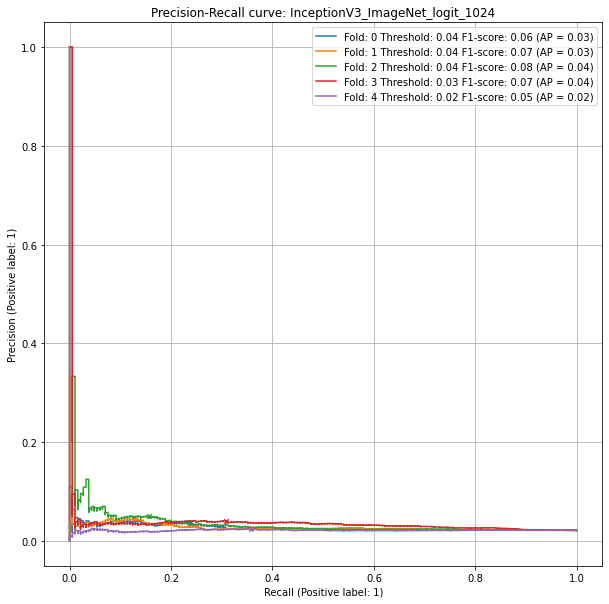

In [12]:
ev.vis_pr_curve(imagenet_logit_1024, col_name='InceptionV3_ImageNet_logit_1024', fold_range=range(5))

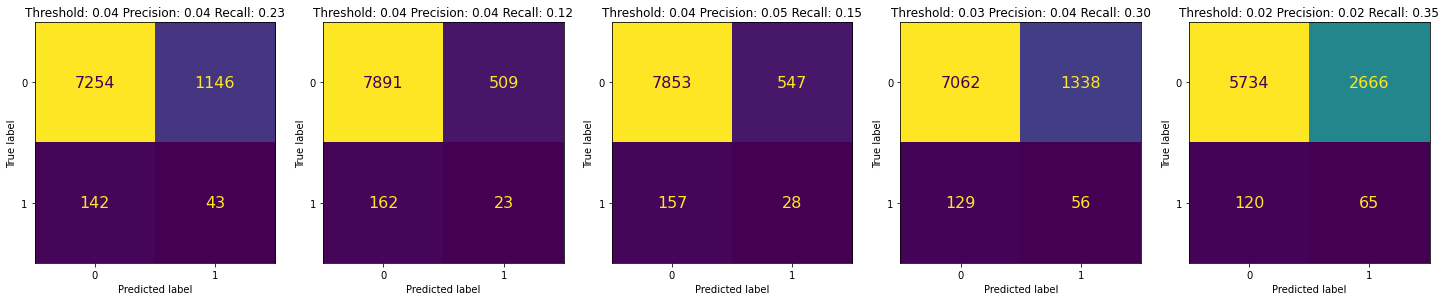

In [13]:
ev.vis_confusion_matrix(imagenet_logit_1024, col_name='InceptionV3_ImageNet_logit_1024', fold_range=range(5))

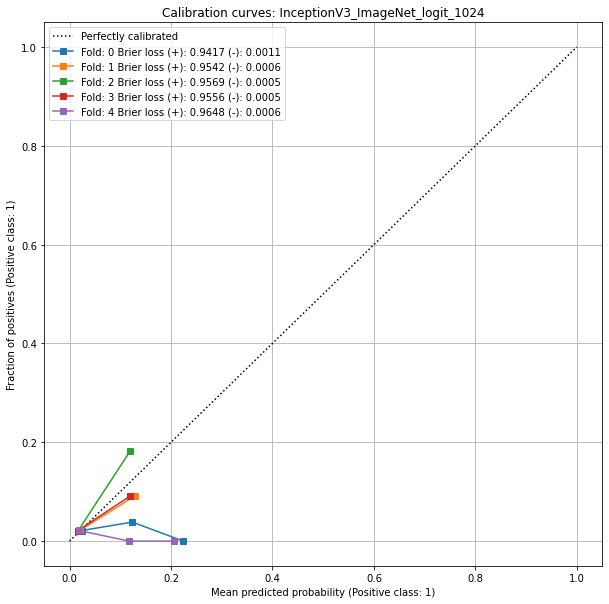

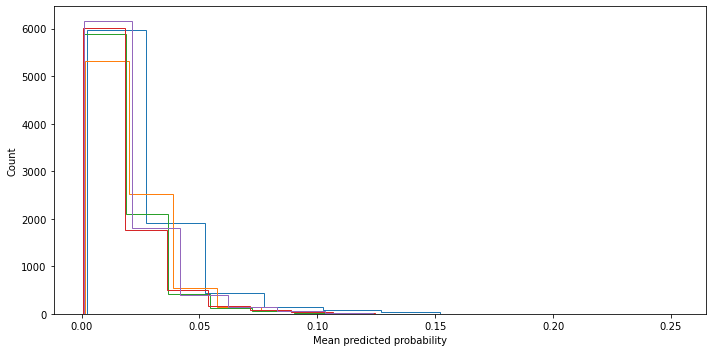

In [14]:
ev.vis_calibration_curve(imagenet_logit_1024, col_name='InceptionV3_ImageNet_logit_1024', fold_range=range(5))

## InceptionV3 (ImageNet) + Random Forest

## Image resolution 256 x 256

In [15]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!
Fold:  1
Feature extractor:  CNN_imagenet
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!
Fold:  2
Feature extractor:  CNN_imagenet
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!
Fold:  3
Feature extractor:  CNN_imagenet
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!
Fold:  4
Feature extractor:  CNN_imagenet
---Loading rfc model...


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.0s finished


In [16]:
imagenet_rfc_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  InceptionV3_ImageNet_rfc_256.csv


In [17]:
imagenet_rfc_256.head()

image_id  cancer  InceptionV3_ImageNet_rfc_256_0  \
0   111020467       0                        0.034101   
1  1360770089       0                        0.003876   
2    21872985       0                        0.001330   
3  1924268326       0                        0.000768   
4  1332075298       0                        0.005968   

   InceptionV3_ImageNet_rfc_256_1  InceptionV3_ImageNet_rfc_256_2  \
0                        0.063312                        0.014783   
1                        0.027993                        0.035918   
2                        0.003123                        0.001449   
3                        0.025437                        0.003870   
4                        0.008675                        0.019924   

   InceptionV3_ImageNet_rfc_256_3  InceptionV3_ImageNet_rfc_256_4  
0                        0.036245                        0.000219  
1                        0.001890                        0.039372  
2                        0.002777                        0.001431  
3                        0.002777                        0.001104  
4                        0.016961                        0.018098

In [18]:
imagenet_rfc_256[imagenet_rfc_256.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_rfc_256_0  \
1306   185869010       1                        0.013438   
6449  2068570916       1                        0.017997   
4778  1663628589       1                        0.009305   
2726   218134651       1                        0.040633   
4868   265835116       1                        0.023131   

      InceptionV3_ImageNet_rfc_256_1  InceptionV3_ImageNet_rfc_256_2  \
1306                        0.001667                        0.017748   
6449                        0.002939                        0.016714   
4778                        0.120181                        0.007900   
2726                        0.075543                        0.004820   
4868                        0.037924                        0.004607   

      InceptionV3_ImageNet_rfc_256_3  InceptionV3_ImageNet_rfc_256_4  
1306                        0.004112                        0.029463  
6449                        0.002110                        0.003932  
4778                        0.018721                        0.001096  
2726                        0.072988                        0.013705  
4868                        0.007062                        0.020570

In [19]:
imagenet_rfc_256 = pd.read_csv('InceptionV3_ImageNet_rfc_256.csv')
imagenet_rfc_256_scores = ev.make_score_df(imagenet_rfc_256, col_name='InceptionV3_ImageNet_rfc_256', fold_range=range(5))
imagenet_rfc_256_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_rfc_256_0   0.047628        0.047870  0.026275   
0  InceptionV3_ImageNet_rfc_256_1   0.093622        0.054712  0.028698   
0  InceptionV3_ImageNet_rfc_256_2   0.003704        0.042001  0.021654   
0  InceptionV3_ImageNet_rfc_256_3   0.050000        0.047970  0.023756   
0  InceptionV3_ImageNet_rfc_256_4   0.038630        0.051763  0.028005   

    roc_auc  f1-score    recall  precision           confusion_matrix    tn  \
0  0.537974  0.053378  0.172973   0.031558   [[7418, 982], [153, 32]]  7418   
0  0.550563  0.061017  0.048649   0.081818    [[8299, 101], [176, 9]]  8299   
0  0.493197  0.043090  0.756757   0.022176  [[2227, 6173], [45, 140]]  2227   
0  0.514342  0.048062  0.167568   0.028054  [[7326, 1074], [154, 31]]  7326   
0  0.549999  0.057834  0.297297   0.032033  [[6738, 1662], [130, 55]]  6738   

     fp   fn   tp  accuracy  pos_brier_loss  neg_brier_loss  
0   982  153   32  0.867793        0.952094        0.000909  
0   101  176    9  0.967734        0.945213        0.001074  
0  6173   45  140  0.275713        0.958048        0.000996  
0  1074  154   31  0.856960        0.952018        0.001052  
0  1662  130   55  0.791264        0.948130        0.000998

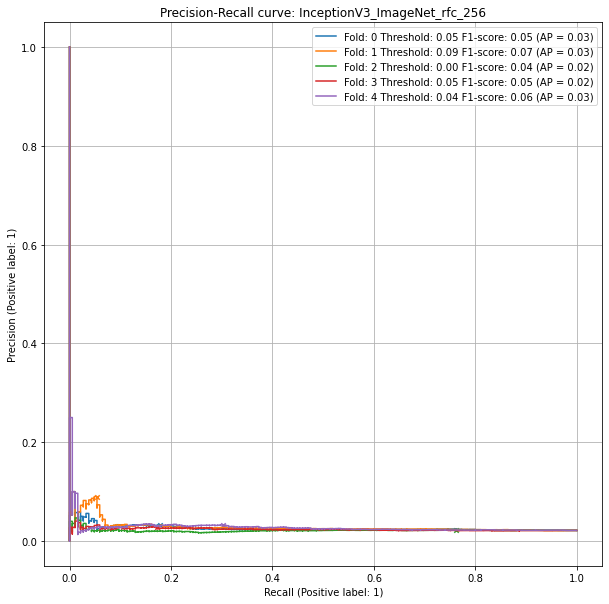

In [20]:
ev.vis_pr_curve(imagenet_rfc_256, col_name='InceptionV3_ImageNet_rfc_256', fold_range=range(5))

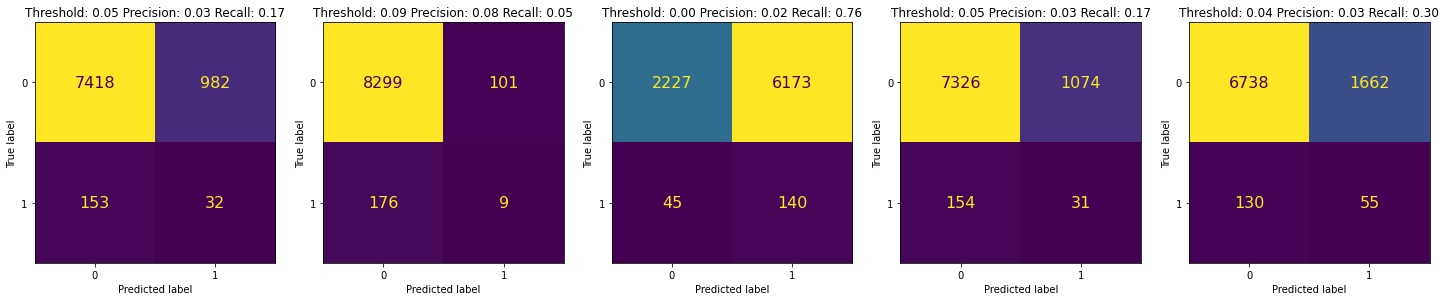

In [21]:
ev.vis_confusion_matrix(imagenet_rfc_256, col_name='InceptionV3_ImageNet_rfc_256', fold_range=range(5))

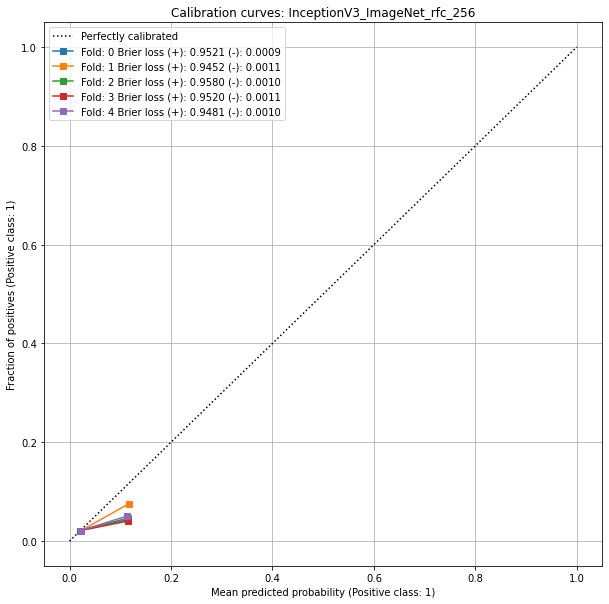

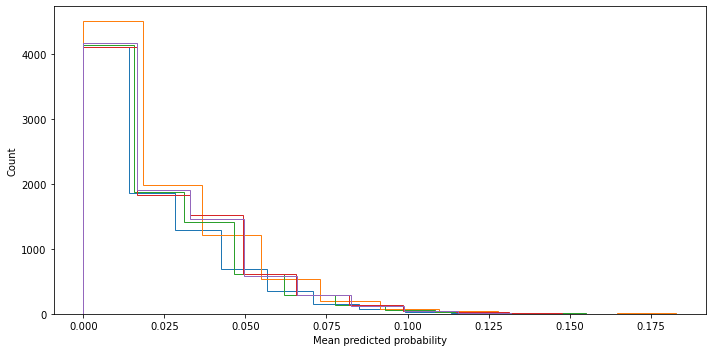

In [22]:
ev.vis_calibration_curve(imagenet_rfc_256, col_name='InceptionV3_ImageNet_rfc_256', fold_range=range(5))

## Image resolution 512 x 512

In [23]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Fold:  1
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Fold:  2
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!
Fold: 

[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


 3
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Fold:  4
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16
Finish all batches!


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


In [24]:
imagenet_rfc_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='rfc',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
(8585,) (8585,) (8585,)
Saved to  InceptionV3_ImageNet_rfc_512.csv


In [25]:
imagenet_rfc_512.head()

image_id  cancer  InceptionV3_ImageNet_rfc_512_0  \
0   111020467       0                        0.001663   
1  1360770089       0                        0.006424   
2    21872985       0                        0.001995   
3  1924268326       0                        0.038629   
4  1332075298       0                        0.013043   

   InceptionV3_ImageNet_rfc_512_1  InceptionV3_ImageNet_rfc_512_2  \
0                        0.032709                        0.004567   
1                        0.000183                        0.020463   
2                        0.022151                        0.001281   
3                        0.018628                        0.002957   
4                        0.009095                        0.000301   

   InceptionV3_ImageNet_rfc_512_3  InceptionV3_ImageNet_rfc_512_4  
0                        0.014344                        0.024642  
1                        0.066816                        0.014918  
2                        0.023543                        0.069421  
3                        0.038031                        0.049897  
4                        0.036055                        0.048793

In [26]:
imagenet_rfc_512[imagenet_rfc_512.cancer==1].sample(5)

image_id  cancer  InceptionV3_ImageNet_rfc_512_0  \
8556   400752214       1                        0.002669   
3735  2019927981       1                        0.018222   
5675  1632383378       1                        0.019596   
5543  1361547019       1                        0.020138   
2859  1214090918       1                        0.004588   

      InceptionV3_ImageNet_rfc_512_1  InceptionV3_ImageNet_rfc_512_2  \
8556                        0.000687                        0.006877   
3735                        0.002244                        0.021715   
5675                        0.004705                        0.005477   
5543                        0.002709                        0.002750   
2859                        0.001021                        0.000633   

      InceptionV3_ImageNet_rfc_512_3  InceptionV3_ImageNet_rfc_512_4  
8556                        0.002225                        0.037076  
3735                        0.003916                        0.008082  
5675                        0.018291                        0.008124  
5543                        0.005898                        0.001392  
2859                        0.072044                        0.020419

In [28]:
imagenet_rfc_512 = pd.read_csv('InceptionV3_ImageNet_rfc_512.csv')
imagenet_rfc_512_scores = ev.make_score_df(imagenet_rfc_512, col_name='InceptionV3_ImageNet_rfc_512', fold_range=range(5))
imagenet_rfc_512_scores

model  threshold  proba_f1-score    pr_auc  \
0  InceptionV3_ImageNet_rfc_512_0   0.050375        0.047189  0.025093   
0  InceptionV3_ImageNet_rfc_512_1   0.027088        0.038802  0.023507   
0  InceptionV3_ImageNet_rfc_512_2   0.052212        0.040259  0.022672   
0  InceptionV3_ImageNet_rfc_512_3   0.024898        0.045359  0.022823   
0  InceptionV3_ImageNet_rfc_512_4   0.056324        0.046404  0.025461   

    roc_auc  f1-score    recall  precision           confusion_matrix    tn  \
0  0.520802  0.057354  0.167568   0.034598   [[7535, 865], [154, 31]]  7535   
0  0.511761  0.049960  0.335135   0.026992  [[6165, 2235], [123, 62]]  6165   
0  0.481155  0.044496  0.102703   0.028401   [[7750, 650], [166, 19]]  7750   
0  0.519850  0.045670  0.416216   0.024161  [[5290, 3110], [108, 77]]  5290   
0  0.520451  0.058981  0.118919   0.039216   [[7861, 539], [163, 22]]  7861   

     fp   fn  tp  accuracy  pos_brier_loss  neg_brier_loss  
0   865  154  31  0.881305        0.952747        0.000904  
0  2235  123  62  0.725335        0.961234        0.000745  
0   650  166  19  0.904950        0.959765        0.000836  
0  3110  108  77  0.625160        0.954527        0.000932  
0   539  163  22  0.918229        0.953526        0.000853

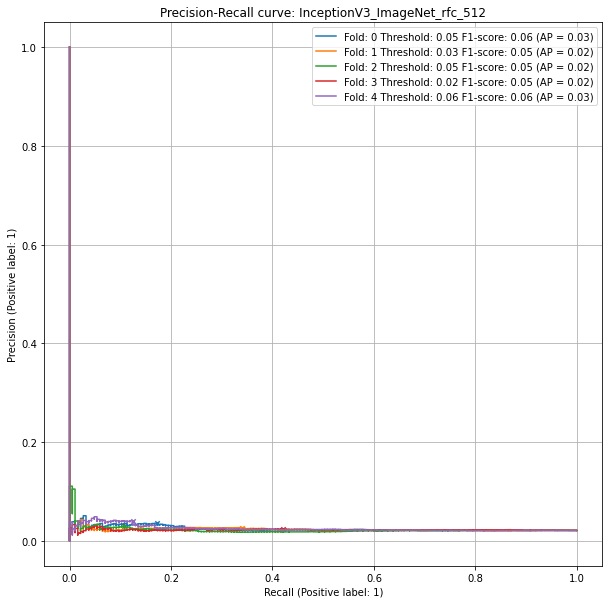

In [29]:
ev.vis_pr_curve(imagenet_rfc_512, col_name='InceptionV3_ImageNet_rfc_512', fold_range=range(5))

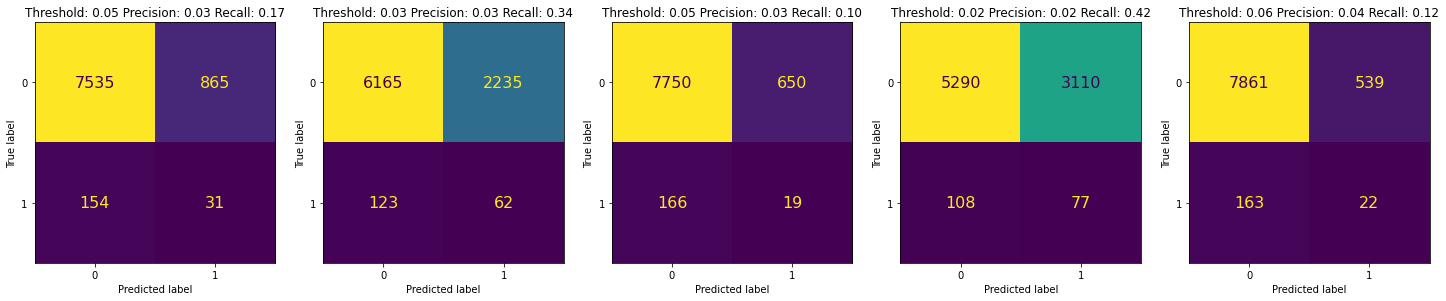

In [30]:
ev.vis_confusion_matrix(imagenet_rfc_512, col_name='InceptionV3_ImageNet_rfc_512', fold_range=range(5))

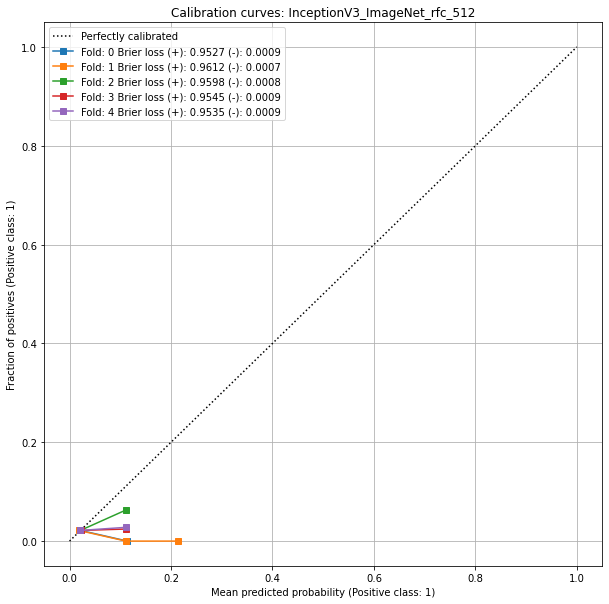

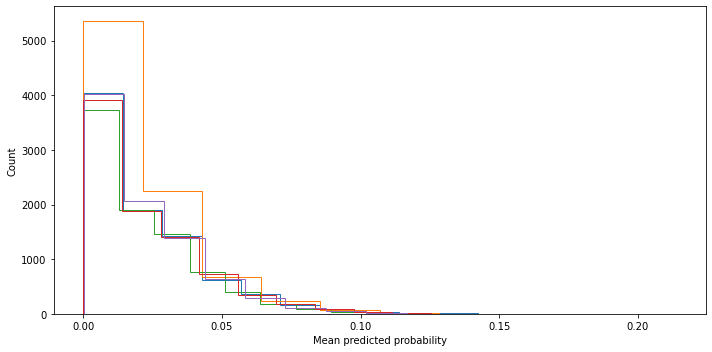

In [31]:
ev.vis_calibration_curve(imagenet_rfc_512, col_name='InceptionV3_ImageNet_rfc_512', fold_range=range(5))

## Image resolution 1024 x 1024

In [ ]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 505

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
)


BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = '/home/irinb/models'
MODEL_PATH = '/home/irinb/models'
N_COMPONENTS = 'output'
RANDOM_STATE = 42

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'rfc',
    model_path = MODEL_PATH,
    
    feature_extractor_name = 'CNN_imagenet',
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(5),
    
    cnn = inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    minibatch = True,
    minibatch_size = 128,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Finish all batches!
Fold:  1
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Finish all batches!
Fold:  2
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Finish all batches!
Fold:  3
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  9


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  10


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  11


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  12


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  13


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  14


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  15


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  16


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


Finish all batches!
Fold:  4
Feature extractor:  CNN_imagenet
---Loading rfc model...
--->>> Tranforming X with CNN...
---Getting predictions for batch  0


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  1


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  2


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  3


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  4


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  5


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  6


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  7


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...
---Getting predictions for batch  8


[Parallel(n_jobs=31)]: Using backend ThreadingBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done   2 out of  31 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=31)]: Done  31 out of  31 | elapsed:    0.0s finished


--->>> Tranforming X with CNN...


In [ ]:
imagenet_rfc_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor='InceptionV3_ImageNet', 
    model_name='rfc',
    img_size=IMG_SIZE
)

In [ ]:
imagenet_rfc_1024.head()

In [ ]:
imagenet_rfc_1024[imagenet_rfc_1024.cancer==1].sample(5)

In [ ]:
imagenet_rfc_1024 = pd.read_csv('InceptionV3_ImageNet_rfc_1024.csv')
imagenet_rfc_1024_scores = ev.make_score_df(imagenet_logit_1024, col_name='InceptionV3_ImageNet_rfc_1024', fold_range=range(5))
imagenet_rfc_1024_scores

In [ ]:
ev.vis_pr_curve(imagenet_rfc_1024, col_name='InceptionV3_ImageNet_rfc_1024', fold_range=range(5))

In [ ]:
ev.vis_confusion_matrix(imagenet_rfc_1024, col_name='InceptionV3_ImageNet_rfc_1024', fold_range=range(5))

In [ ]:
ev.vis_calibration_curve(imagenet_rfc_1024, col_name='InceptionV3_ImageNet_rfc_1024', fold_range=range(5))

## InceptionV3 (RSNA)

### Image resolution 256 x 256

**1st Candidate**
- Batch size: 256
- Optimizer: SGD with momentum 0.9
- Learning rate: 1e-5
- From epoch: 1
- Validation loss: 0.1875

In [45]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_256_batch256_sgd_lr1e-5_epoch1_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 4s 195ms/step
---Getting predictions for batch  1
16/16 [==============================] - 3s 196ms/step
---Getting predictions for batch  2
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  3
16/16 [==============================] - 3s 196ms/step
---Getting predictions for batch  4
16/16 [==============================] - 3s 196ms/step
---Getting predictions for batch  5
16/16 [==============================] - 3s 204ms/step
---Getting predictions for batch  6
16/16 [==============================] - 3s 195ms/step
---Getting predictions for batch  7
16/16 [==============================] - 3s 192ms/step
---Getting predictions for batch  8
16/16 [==============================] - 3s 193ms/step
---Getting predictions for batch  9
16/16 [==============================] - 3s 190ms/step
---Getting predictions for batch  10
16/16 [==========

In [46]:
rsna_sgd_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_SGD',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  _InceptionV3_RSNA_SGD_256.csv


In [47]:
rsna_sgd_256.head()

image_id  cancer  _InceptionV3_RSNA_SGD_256_0
0   111020467       0                     0.218606
1  1360770089       0                     0.126225
2    21872985       0                     0.116032
3  1924268326       0                     0.047454
4  1332075298       0                     0.296221

In [48]:
rsna_sgd_256[rsna_sgd_256.cancer==1].sample(5)

image_id  cancer  _InceptionV3_RSNA_SGD_256_0
7883  2048614595       1                     0.028906
2374  1859372199       1                     0.123135
8176  1564214908       1                     0.097321
4887  1435663649       1                     0.289558
336    743851181       1                     0.164867

In [29]:
rsna_sgd_256 = pd.read_csv('InceptionV3_RSNA_SGD_256.csv')
rsna_sgd_256_scores = ev.make_score_df(rsna_sgd_256, col_name='InceptionV3_RSNA_SGD_256', fold_range=range(1))
rsna_sgd_256_scores

model  threshold  proba_f1-score   pr_auc   roc_auc  \
0  InceptionV3_RSNA_SGD_256_0   0.322526        0.276606  0.02976  0.589129   

   f1-score    recall  precision          confusion_matrix    tn   fp   fn  \
0  0.062969  0.113514   0.043568  [[7939, 461], [164, 21]]  7939  461  164   

   tp  accuracy  pos_brier_loss  neg_brier_loss  
0  21  0.927199        0.715929        0.027698

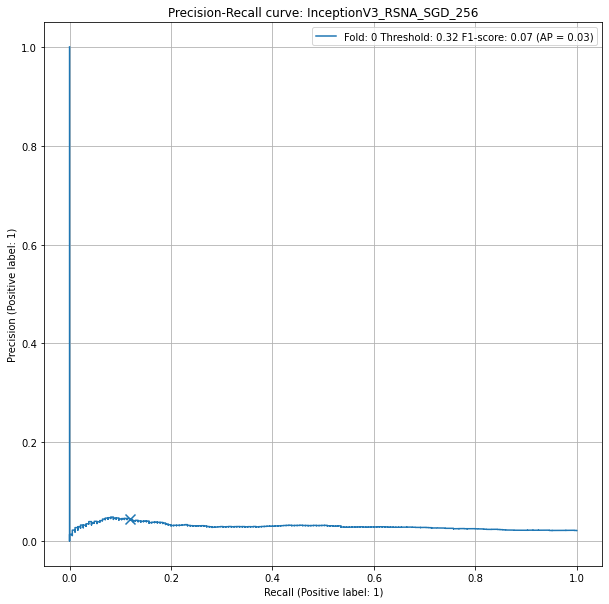

In [69]:
ev.vis_pr_curve(rsna_sgd_256, col_name='InceptionV3_RSNA_SGD_256', fold_range=range(1))

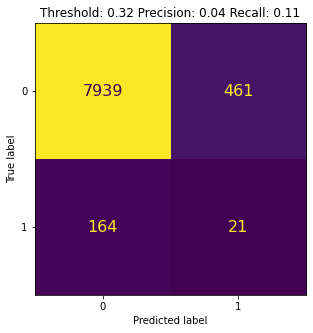

In [11]:
ev.vis_confusion_matrix(rsna_sgd_256, col_name='InceptionV3_RSNA_SGD_256', fold_range=range(1))

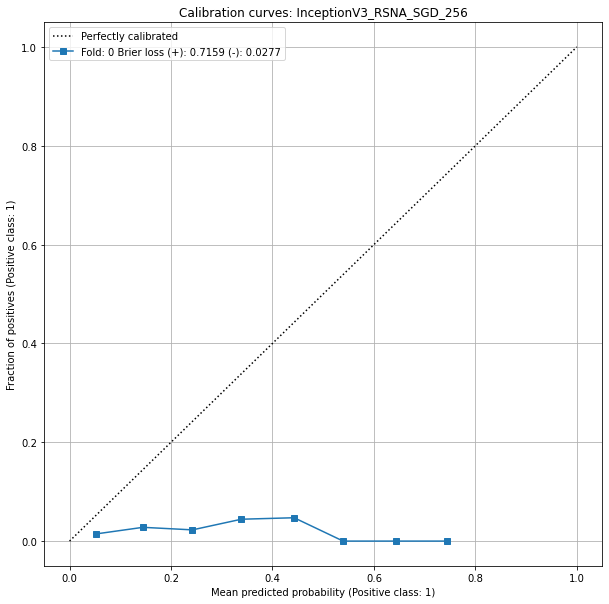

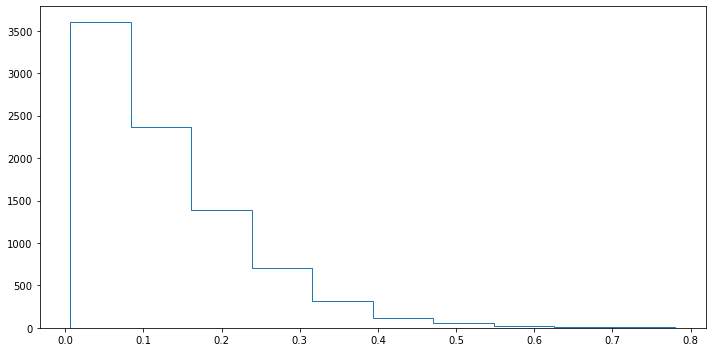

In [57]:
ev.vis_calibration_curve(rsna_sgd_256, col_name='InceptionV3_RSNA_SGD_256', fold_range=range(1))

**2nd Candidate**
- Batch size: 256
- Optimizer: Adam
- Learning rate: 1e-6
- From epoch 1

In [49]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 505

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_256_batch256_adam_lr1e-6_epoch1_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
16/16 [==============================] - 4s 210ms/step
---Getting predictions for batch  1
16/16 [==============================] - 3s 206ms/step
---Getting predictions for batch  2
16/16 [==============================] - 3s 207ms/step
---Getting predictions for batch  3
16/16 [==============================] - 3s 208ms/step
---Getting predictions for batch  4
16/16 [==============================] - 3s 209ms/step
---Getting predictions for batch  5
16/16 [==============================] - 3s 203ms/step
---Getting predictions for batch  6
16/16 [==============================] - 3s 206ms/step
---Getting predictions for batch  7
16/16 [==============================] - 3s 203ms/step
---Getting predictions for batch  8
16/16 [==============================] - 3s 208ms/step
---Getting predictions for batch  9
16/16 [==============================] - 3s 211ms/step
---Getting predictions for batch  10
16/16 [==========

In [50]:
rsna_adam_256 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_Adam',
    img_size=IMG_SIZE
)

(8585,) (8585,) (8585,)
Saved to  _InceptionV3_RSNA_Adam_256.csv


In [51]:
rsna_adam_256.head()

image_id  cancer  _InceptionV3_RSNA_Adam_256_0
0   111020467       0                      0.989537
1  1360770089       0                      0.968398
2    21872985       0                      0.974639
3  1924268326       0                      0.983334
4  1332075298       0                      0.979524

In [52]:
rsna_adam_256[rsna_adam_256.cancer==1].sample(5)

image_id  cancer  _InceptionV3_RSNA_Adam_256_0
8175  1231101161       1                      0.916582
6999   172743476       1                      0.967898
2552  1059866275       1                      0.985322
3356  1982596702       1                      0.955359
3355  1605876492       1                      0.950711

In [24]:
rsna_adam_256 = pd.read_csv('InceptionV3_RSNA_Adam_256.csv')
rsna_adam_256_scores = ev.make_score_df(rsna_adam_256, col_name='InceptionV3_RSNA_Adam_256', fold_range=range(1))
rsna_adam_256_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  InceptionV3_RSNA_Adam_256_0   0.743055        0.957032  0.018421  0.449297   

   f1-score    recall  precision        confusion_matrix  tn    fp  fn   tp  \
0  0.042279  0.994595   0.021599  [[65, 8335], [1, 184]]  65  8335   1  184   

   accuracy  brier_loss  
0  0.029004    0.006505

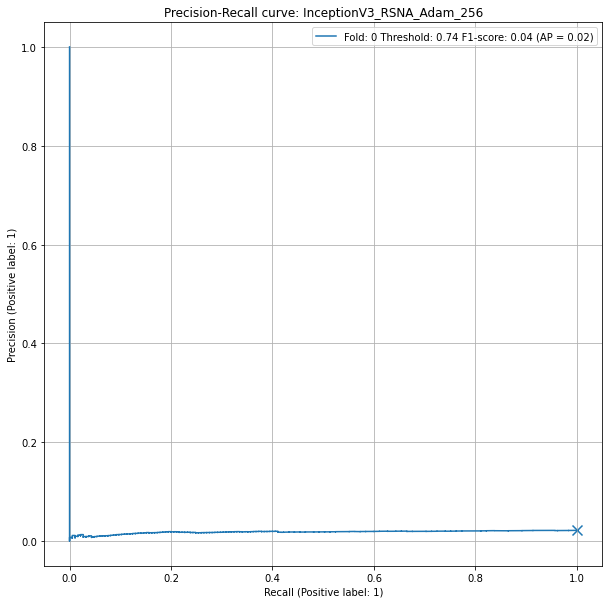

In [70]:
ev.vis_pr_curve(rsna_adam_256, col_name='InceptionV3_RSNA_Adam_256', fold_range=range(1))

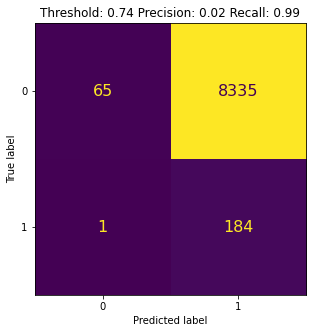

In [25]:
ev.vis_confusion_matrix(rsna_adam_256, col_name='InceptionV3_RSNA_Adam_256', fold_range=range(1))

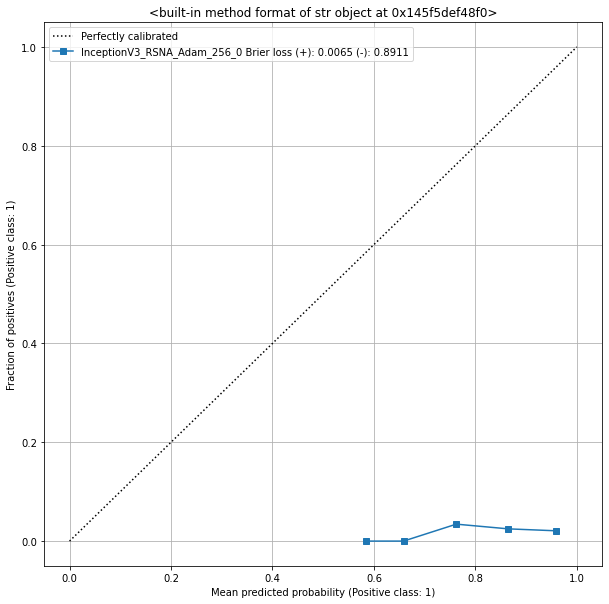

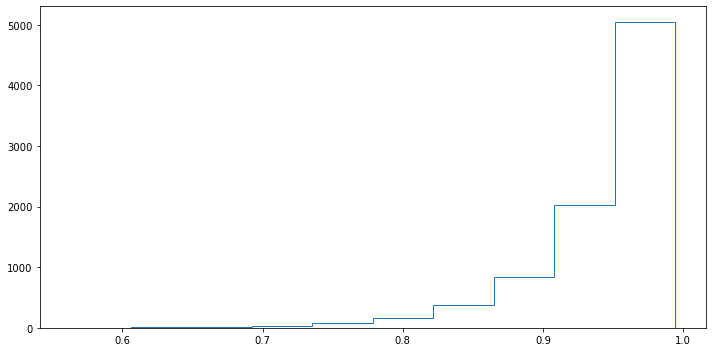

In [33]:
ev.vis_calibration_curve(rsna_adam_256, col_name='InceptionV3_RSNA_Adam_256', fold_range=range(1))

## Image resolution 512 x 512

**1st Candidate**
- Batch size: 128
- Optimizer: SGD with momentum 0.9
- Learning rate: 1e-3
- From epoch: 1
- Validation loss: 0.2078

In [9]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 313

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_512_batch128_sgd_lr1e-3_epoch1_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
10/10 [==============================] - 10s 847ms/step
---Getting predictions for batch  1
10/10 [==============================] - 9s 861ms/step
---Getting predictions for batch  2
10/10 [==============================] - 9s 856ms/step
---Getting predictions for batch  3
10/10 [==============================] - 9s 856ms/step
---Getting predictions for batch  4
10/10 [==============================] - 9s 859ms/step
---Getting predictions for batch  5
10/10 [==============================] - 9s 853ms/step
---Getting predictions for batch  6
10/10 [==============================] - 9s 855ms/step
---Getting predictions for batch  7
10/10 [==============================] - 9s 851ms/step
---Getting predictions for batch  8
10/10 [==============================] - 9s 861ms/step
---Getting predictions for batch  9
10/10 [==============================] - 9s 859ms/step
---Getting predictions for batch  10
10/10 [=========

In [10]:
rsna_sgd_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_SGD',
    img_size=IMG_SIZE
)

(8764,) (8764,) (8764,)
Saved to  _InceptionV3_RSNA_SGD_512.csv


In [11]:
rsna_sgd_512.head()

image_id  cancer  InceptionV3_RSNA_SGD_512_0
0   111020467       0                    0.000021
1  1360770089       0                    0.000034
2    21872985       0                    0.000141
3  1924268326       0                    0.000160
4  1332075298       0                    0.000004

In [12]:
rsna_sgd_512[rsna_sgd_512.cancer==1].sample(5)

image_id  cancer  InceptionV3_RSNA_SGD_512_0
5674  1312846125       1                    0.000032
5404  1420153030       1                    0.000054
4757  1662724073       1                    0.000074
2084   513700051       1                    0.000028
4137  1562088774       1                    0.000078

In [14]:
rsna_sgd_512 = pd.read_csv('InceptionV3_RSNA_SGD_512.csv')
rsna_sgd_512_scores = ev.make_score_df(rsna_sgd_512, col_name='InceptionV3_RSNA_SGD_512', fold_range=range(1))
rsna_sgd_512_scores

model  threshold  proba_f1-score    pr_auc   roc_auc  \
0  InceptionV3_RSNA_SGD_512_0   0.000179        0.000127  0.023289  0.514069   

   f1-score    recall  precision          confusion_matrix    tn   fp   fn  \
0   0.04798  0.101064   0.031457  [[7991, 585], [169, 19]]  7991  585  169   

   tp  accuracy  pos_brier_loss  neg_brier_loss  
0  19  0.913966        0.999873    9.101928e-09

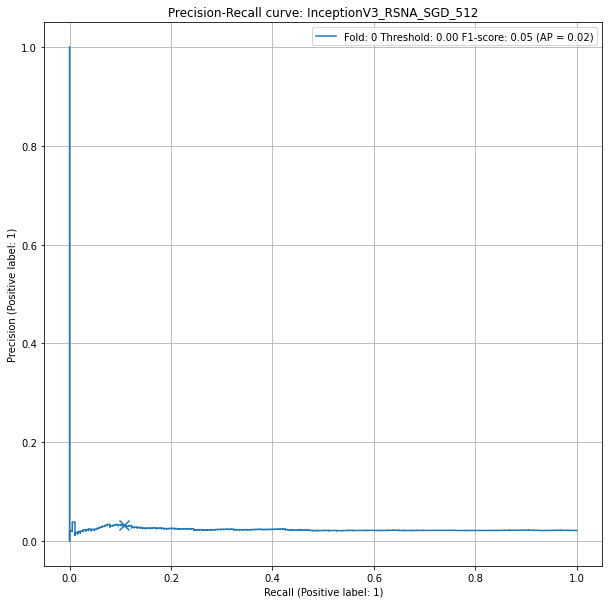

In [18]:
ev.vis_pr_curve(rsna_sgd_512, col_name='InceptionV3_RSNA_SGD_512', fold_range=range(1))

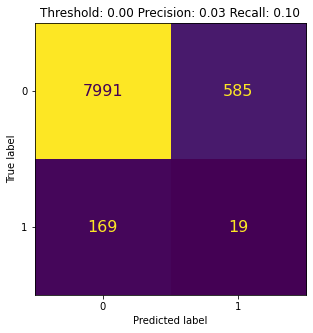

In [16]:
ev.vis_confusion_matrix(rsna_sgd_512, col_name='InceptionV3_RSNA_SGD_512', fold_range=range(1))

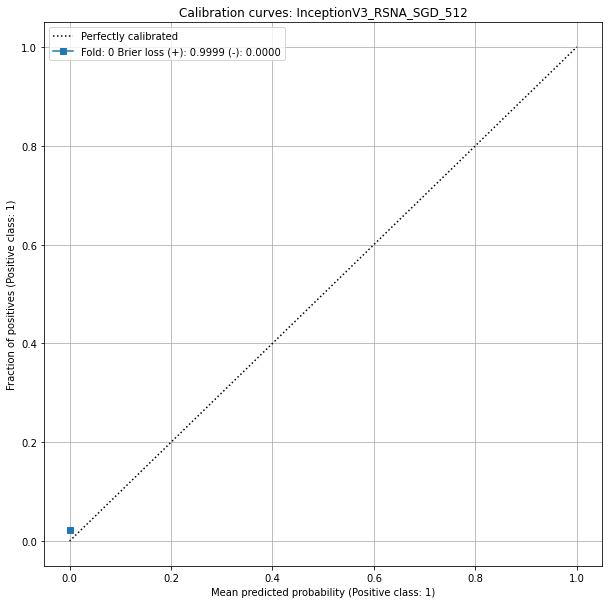

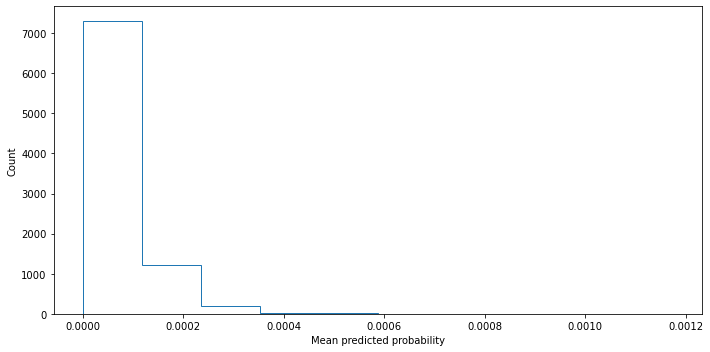

In [17]:
ev.vis_calibration_curve(rsna_sgd_512, col_name='InceptionV3_RSNA_SGD_512', fold_range=range(1))

**2nd Candidate**
- Batch size: 128
- Optimizer: Adam
- Learning rate: 1e-2
- From epoch: 7
- Validation loss: 17081.0723

In [36]:
IMG_SIZE = (512, 512, 1)
BATCH_SIZE = 313

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_512_batch128_adam_lr1e-2_epoch7_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
10/10 [==============================] - 10s 863ms/step
---Getting predictions for batch  1
10/10 [==============================] - 9s 862ms/step
---Getting predictions for batch  2
10/10 [==============================] - 9s 857ms/step
---Getting predictions for batch  3
10/10 [==============================] - 9s 862ms/step
---Getting predictions for batch  4
10/10 [==============================] - 9s 861ms/step
---Getting predictions for batch  5
10/10 [==============================] - 9s 875ms/step
---Getting predictions for batch  6
10/10 [==============================] - 9s 874ms/step
---Getting predictions for batch  7
10/10 [==============================] - 9s 868ms/step
---Getting predictions for batch  8
10/10 [==============================] - 9s 869ms/step
---Getting predictions for batch  9
10/10 [==============================] - 9s 881ms/step
---Getting predictions for batch  10
10/10 [=========

In [26]:
rsna_adam_512 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_Adam',
    img_size=IMG_SIZE
)

(8764,) (8764,) (8764,)
Saved to  InceptionV3_RSNA_Adam_512.csv


In [37]:
rsna_adam_512.head()

image_id  cancer  InceptionV3_RSNA_Adam_512_0
0   111020467       0                          0.0
1  1360770089       0                          0.0
2    21872985       0                          0.0
3  1924268326       0                          0.0
4  1332075298       0                          0.0

In [38]:
rsna_adam_512[rsna_adam_512.cancer==1].sample(5)

image_id  cancer  InceptionV3_RSNA_Adam_512_0
5634  1880776532       1                          0.0
3735  2019927981       1                          0.0
7122   295341643       1                          0.0
7882   693687948       1                          0.0
5834    11944138       1                          0.0

In [39]:
rsna_adam_512 = pd.read_csv('InceptionV3_RSNA_Adam_512.csv')
rsna_adam_512_scores = ev.make_score_df(rsna_adam_512, col_name='InceptionV3_RSNA_Adam_512', fold_range=range(1))
rsna_adam_512_scores

/home/irinb/eval_model.py:200: RuntimeWarning: invalid value encountered in double_scalars
  proba_fscore = (1 + beta_squared) * (proba_precision * proba_recall) / (beta_squared * proba_precision + proba_recall)


model  threshold  proba_f1-score    pr_auc  roc_auc  \
0  InceptionV3_RSNA_Adam_512_0        0.0               0  0.021451      0.5   

   f1-score  recall  precision       confusion_matrix    tn  fp   fn  tp  \
0       0.0     0.0        0.0  [[8576, 0], [188, 0]]  8576   0  188   0   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.978549             1.0             0.0

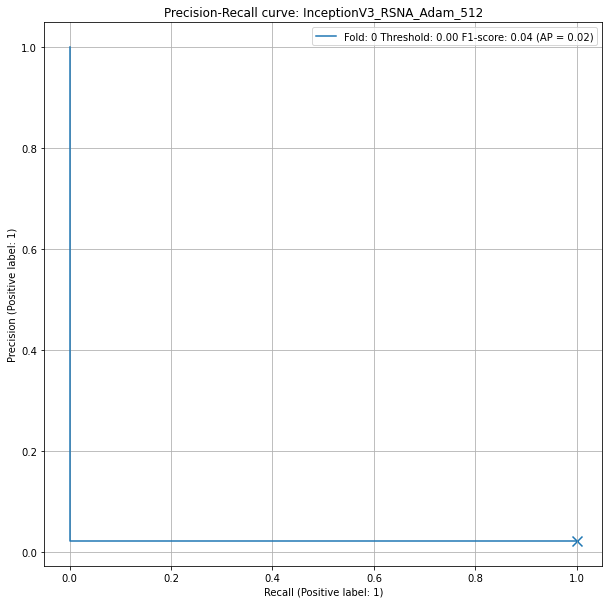

In [40]:
ev.vis_pr_curve(rsna_adam_512, col_name='InceptionV3_RSNA_Adam_512', fold_range=range(1))

/home/irinb/eval_model.py:200: RuntimeWarning: invalid value encountered in double_scalars
  proba_fscore = (1 + beta_squared) * (proba_precision * proba_recall) / (beta_squared * proba_precision + proba_recall)


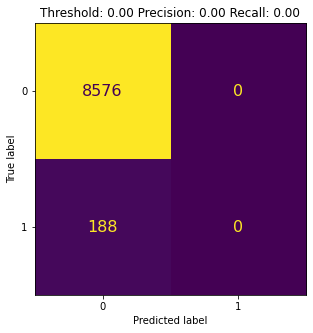

In [41]:
ev.vis_confusion_matrix(rsna_adam_512, col_name='InceptionV3_RSNA_Adam_512', fold_range=range(1))

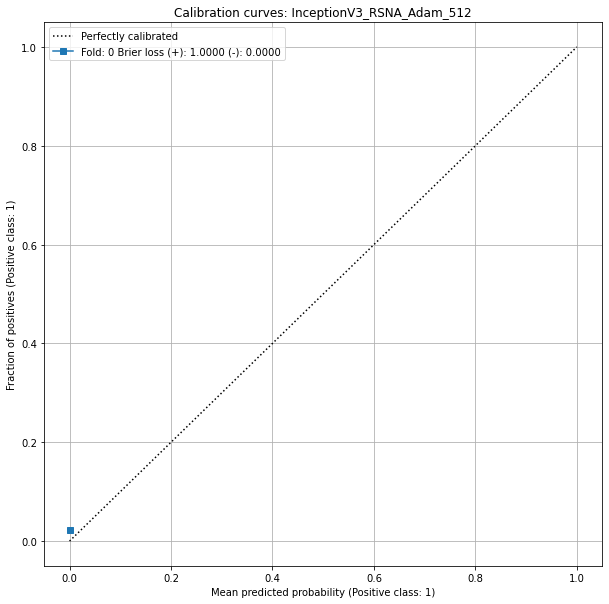

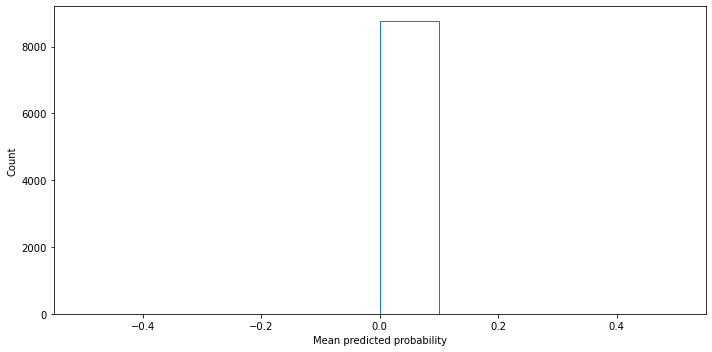

In [42]:
ev.vis_calibration_curve(rsna_adam_512, col_name='InceptionV3_RSNA_Adam_512', fold_range=range(1))

## Image resolution 1024 x 1024

**1st Candidate**
- Batch size: 16
- Optimizer: SGD with momentum 0.9
- Learning rate: 1e-3
- From epoch: 1
- Validation loss: 14.6250

In [43]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 313

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_1024_batch16_sgd_lr1e-3_epoch1_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
10/10 [==============================] - 43s 4s/step
---Getting predictions for batch  1
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  2
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  3
10/10 [==============================] - 41s 4s/step
---Getting predictions for batch  4
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  5
10/10 [==============================] - 41s 4s/step
---Getting predictions for batch  6
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  7
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  8
10/10 [==============================] - 41s 4s/step
---Getting predictions for batch  9
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  10
10/10 [==============================

In [44]:
rsna_sgd_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_SGD',
    img_size=IMG_SIZE
)

(8764,) (8764,) (8764,)
Saved to  InceptionV3_RSNA_SGD_1024.csv


In [45]:
rsna_sgd_1024.head()

image_id  cancer  InceptionV3_RSNA_SGD_1024_0
0   111020467       0                          0.0
1  1360770089       0                          0.0
2    21872985       0                          0.0
3  1924268326       0                          0.0
4  1332075298       0                          0.0

In [46]:
rsna_sgd_1024[rsna_sgd_1024.cancer==1].sample(5)

image_id  cancer  InceptionV3_RSNA_SGD_1024_0
8175  1231101161       1                          0.0
579    972684809       1                          0.0
4778  1663628589       1                          0.0
977   1586224451       1                          0.0
7639   806916891       1                          0.0

In [47]:
rsna_sgd_1024 = pd.read_csv('InceptionV3_RSNA_SGD_1024.csv')
rsna_sgd_1024_scores = ev.make_score_df(rsna_sgd_1024, col_name='InceptionV3_RSNA_SGD_1024', fold_range=range(1))
rsna_sgd_1024_scores

/home/irinb/eval_model.py:198: RuntimeWarning: invalid value encountered in double_scalars
  


model  threshold  proba_f1-score    pr_auc  roc_auc  \
0  InceptionV3_RSNA_SGD_1024_0        0.0               0  0.021451      0.5   

   f1-score  recall  precision       confusion_matrix    tn  fp   fn  tp  \
0       0.0     0.0        0.0  [[8576, 0], [188, 0]]  8576   0  188   0   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.978549             1.0             0.0

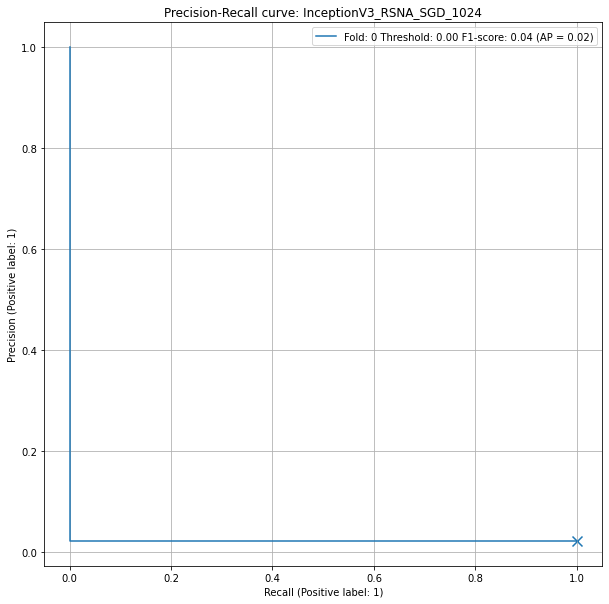

In [48]:
ev.vis_pr_curve(rsna_sgd_1024, col_name='InceptionV3_RSNA_SGD_1024', fold_range=range(1))

/home/irinb/eval_model.py:198: RuntimeWarning: invalid value encountered in double_scalars
  


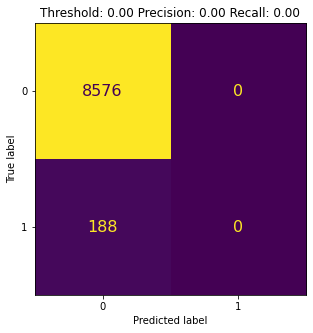

In [49]:
ev.vis_confusion_matrix(rsna_sgd_1024, col_name='InceptionV3_RSNA_SGD_1024', fold_range=range(1))

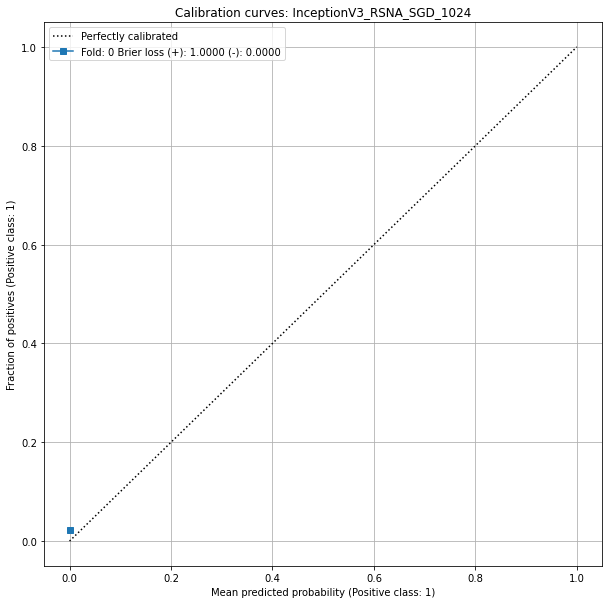

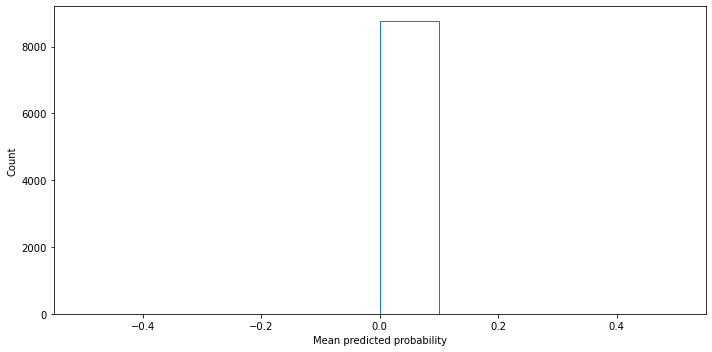

In [50]:
ev.vis_calibration_curve(rsna_sgd_1024, col_name='InceptionV3_RSNA_SGD_1024', fold_range=range(1))

**2nd Candidate**
- Batch size: 64
- Optimizer: Adam
- Learning rate: 1e-3
- From epoch: 1
- Validation loss: 253.7480

In [51]:
IMG_SIZE = (1024, 1024, 1)
BATCH_SIZE = 313

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/calibrate' 
EXTRACTOR_PATH = None
MODEL_PATH = None
N_COMPONENTS = None
RANDOM_STATE = 42

trained_inception = keras.models.load_model('models/inception_rsna_checkpoint/selected_models/rsna_1024_batch64_adam_lr1e-3_epoch1_frozen.hdf5')

img_id, y_true, y_pred_proba = ev.get_prediction_from_pipeline(
    img_ids = calib_img_ids,
    label_img_dict = splitter.labels,
    patient_img_dict = splitter.calibset,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE,
    
    img_size = IMG_SIZE,
    model_name = 'CNN',
    model_path = MODEL_PATH,
    
    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    n_components = N_COMPONENTS,
    
    fold_range = range(1),
    
    cnn = trained_inception,
    CNN_preprocess = tf.keras.applications.inception_v3.preprocess_input,
    
    random_state = 42,
    verbose = 1
)

Fold:  0
Using no feature extractor
---Getting predictions for batch  0
10/10 [==============================] - 43s 4s/step
---Getting predictions for batch  1
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  2
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  3
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  4
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  5
10/10 [==============================] - 41s 4s/step
---Getting predictions for batch  6
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  7
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  8
10/10 [==============================] - 42s 4s/step
---Getting predictions for batch  9
10/10 [==============================] - 41s 4s/step
---Getting predictions for batch  10
10/10 [==============================

In [52]:
rsna_adam_1024 = ev.make_prediction_df(
    img_id, y_true, y_pred_proba,
    feature_extractor=None, 
    model_name='InceptionV3_RSNA_Adam',
    img_size=IMG_SIZE
)

(8764,) (8764,) (8764,)
Saved to  InceptionV3_RSNA_Adam_1024.csv


In [53]:
rsna_adam_1024.head()

image_id  cancer  InceptionV3_RSNA_Adam_1024_0
0   111020467       0                           0.0
1  1360770089       0                           0.0
2    21872985       0                           0.0
3  1924268326       0                           0.0
4  1332075298       0                           0.0

In [54]:
rsna_adam_1024[rsna_adam_1024.cancer==1].sample(5)

image_id  cancer  InceptionV3_RSNA_Adam_1024_0
976    109045962       1                           0.0
5140  1563019139       1                           0.0
100     32033063       1                           0.0
7252  1280544598       1                           0.0
4364  1923100903       1                           0.0

In [55]:
rsna_adam_1024 = pd.read_csv('InceptionV3_RSNA_Adam_1024.csv')
rsna_adam_1024_scores = ev.make_score_df(rsna_adam_1024, col_name='InceptionV3_RSNA_Adam_1024', fold_range=range(1))
rsna_adam_1024_scores

/home/irinb/eval_model.py:198: RuntimeWarning: invalid value encountered in double_scalars
  


model  threshold  proba_f1-score    pr_auc  roc_auc  \
0  InceptionV3_RSNA_Adam_1024_0        0.0               0  0.021451      0.5   

   f1-score  recall  precision       confusion_matrix    tn  fp   fn  tp  \
0       0.0     0.0        0.0  [[8576, 0], [188, 0]]  8576   0  188   0   

   accuracy  pos_brier_loss  neg_brier_loss  
0  0.978549             1.0             0.0

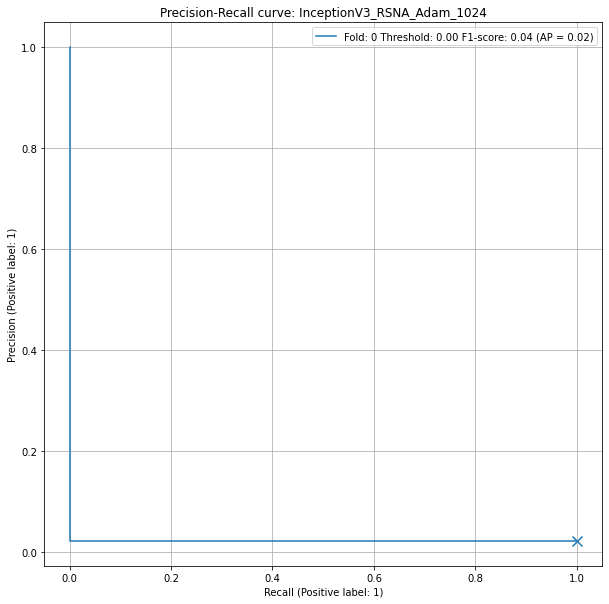

In [56]:
ev.vis_pr_curve(rsna_adam_1024, col_name='InceptionV3_RSNA_Adam_1024', fold_range=range(1))

/home/irinb/eval_model.py:198: RuntimeWarning: invalid value encountered in double_scalars
  


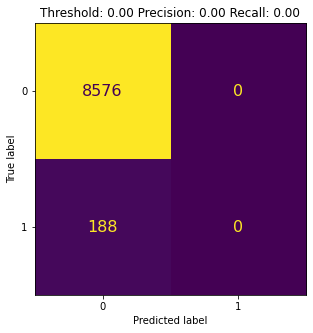

In [57]:
ev.vis_confusion_matrix(rsna_adam_1024, col_name='InceptionV3_RSNA_Adam_1024', fold_range=range(1))

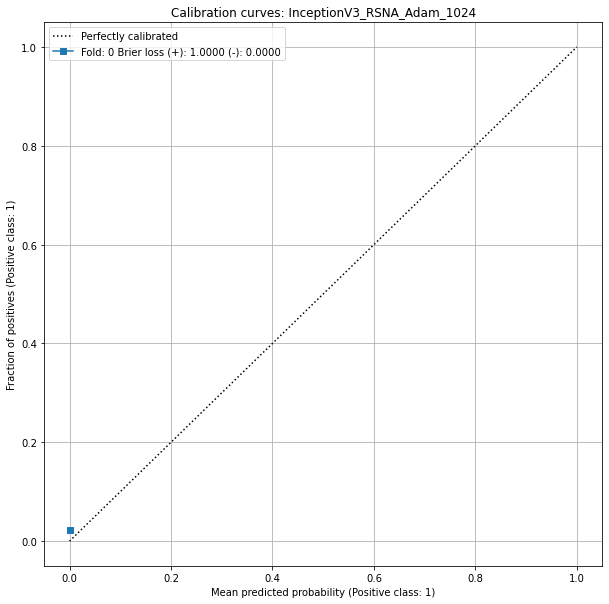

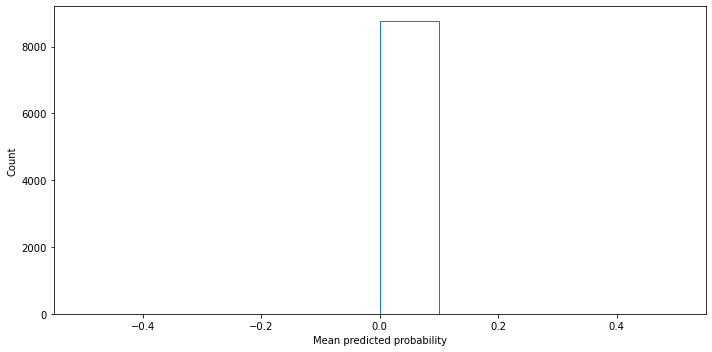

In [58]:
ev.vis_calibration_curve(rsna_adam_1024, col_name='InceptionV3_RSNA_Adam_1024', fold_range=range(1))